In [1]:
import awkward as ak
import matplotlib.pyplot as plt
import os, sys
import subprocess
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, ScoutingNanoAODSchema, ScoutingJMENanoAODSchema
from coffea.lookup_tools.lookup_base import lookup_base
import numpy as np
from coffea import processor, util
from hist import Hist
import hist
from coffea.analysis_tools import Weights, PackedSelection
from collections import defaultdict
import mplhep
import math
plt.style.use(mplhep.style.CMS)

from iminuit import cost, Minuit
from numba_stats import norm , crystalball
import numpy as np
from scipy.stats import multivariate_normal as mvnorm

In [3]:
def resolution_centered(h, epsilon=0.1):
    
    mpv_bin = np.argmax(h.values())

    values = h.values()
    weight = values[mpv_bin]
    thesum = h.sum()
    centers = h.axes[0].centers

    best_i = -1
    best_error = epsilon

    for i in range(1, 10): #math.floor(len(values) / 2)): 
        weight += values[mpv_bin + i]
        weight += values[mpv_bin - i]

        ratio = weight / thesum

        error = abs(ratio - 0.683) 
        if error < best_error:
            best_i = i
            best_error = error
                
    return centers[mpv_bin - best_i], centers[mpv_bin + best_i], 0.5 * (centers[mpv_bin + best_i] - centers[mpv_bin - best_i])

In [4]:
def resolution(h, wmin=-0.5, wmax=0.5, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = h.sum()

    # number of jets in each bin
    values = h.values()

    # bin centers
    centers = h.axes[0].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
            if abs(wy - 0.683) < epsilon:
                wx = points[j][0] - points[i][0]
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    width = wx
    return low, high, 0.5 * (high - low)

In [42]:
lep = util.load("outfiles/Run3Summer22EE/fulllumi/jer_ScoutingPFMonitor_Run2022F-CHS_nonHadronicTriggers_double_noMatching.coffea")[0]
had = util.load("outfiles/Run3Summer22EE/fulllumi/jer_ScoutingPFMonitor_Run2022F_jetid.coffea")[0]

/tmp/ipykernel_31/2402240269.py:5: RuntimeWarning: invalid value encountered in sqrt
  return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))


[None, None]

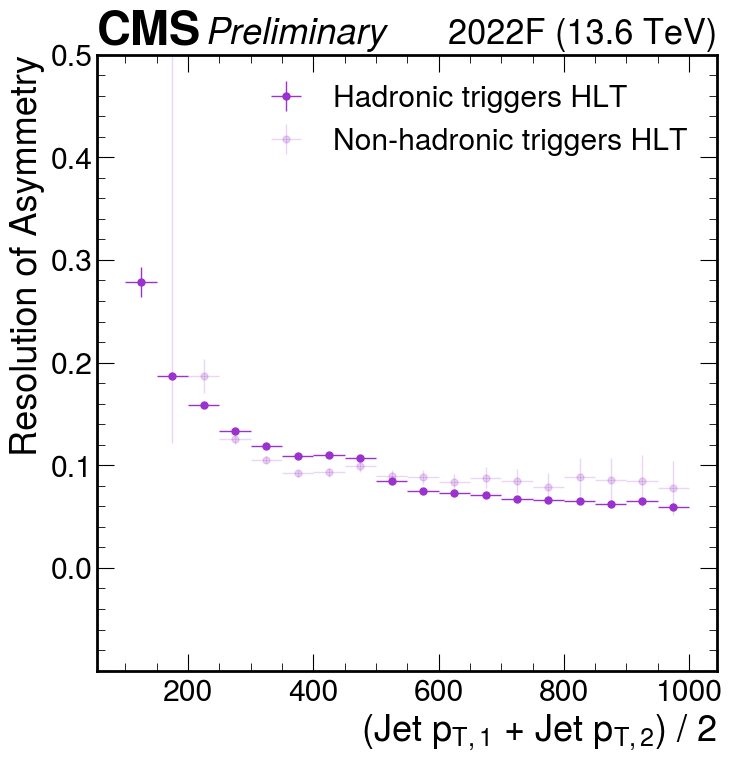

In [43]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        
    return err

fig, ax = plt.subplots(figsize=(8,8))

hmean_s_lep = lep["scouting_mean"].project("pt_ave") #[::hist.rebin(2)]
hmean_o_lep = lep["offline_mean"].project("pt_ave") #[::hist.rebin(2)]
hmean_s_had = had["scouting_mean"].project("pt_ave") #[::hist.rebin(2)]
hmean_o_had = had["offline_mean"].project("pt_ave") #[::hist.rebin(2)]
binwidth = hmean_s_lep.axes[0].centers[2] - hmean_s_lep.axes[0].centers[1]

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

ax.errorbar(
    hmean_s_had.axes[0].centers,
    err(hmean_s_had),
    xerr=binwidth/2,
    yerr=err_err(hmean_s_had),
    label="Hadronic triggers HLT",
    color="#9A32CD",
    **data_err_opts,
)

ax.errorbar(
    hmean_s_lep.axes[0].centers,
    err(hmean_s_lep),
    xerr=binwidth/2,
    yerr=err_err(hmean_s_lep)*10,
    label="Non-hadronic triggers HLT",
    color="#9A32CD",
    **data_err_opts,
    alpha=0.2,
)

ax.legend(loc="best")
mplhep.cms.label(ax=ax, data=True, year="2022F", com=13.6, label="Preliminary")
ax.set_ylabel(r"Resolution of Asymmetry")
ax.set_xlabel(r"(Jet $p_{T,1}$ + Jet $p_{T,2}$) / 2")
ax.set_ylim(-0.1, 0.5)
plt.setp(ax.get_yticklabels()[0], visible=False) 

# jet + gamma

(0.0, 2.0)

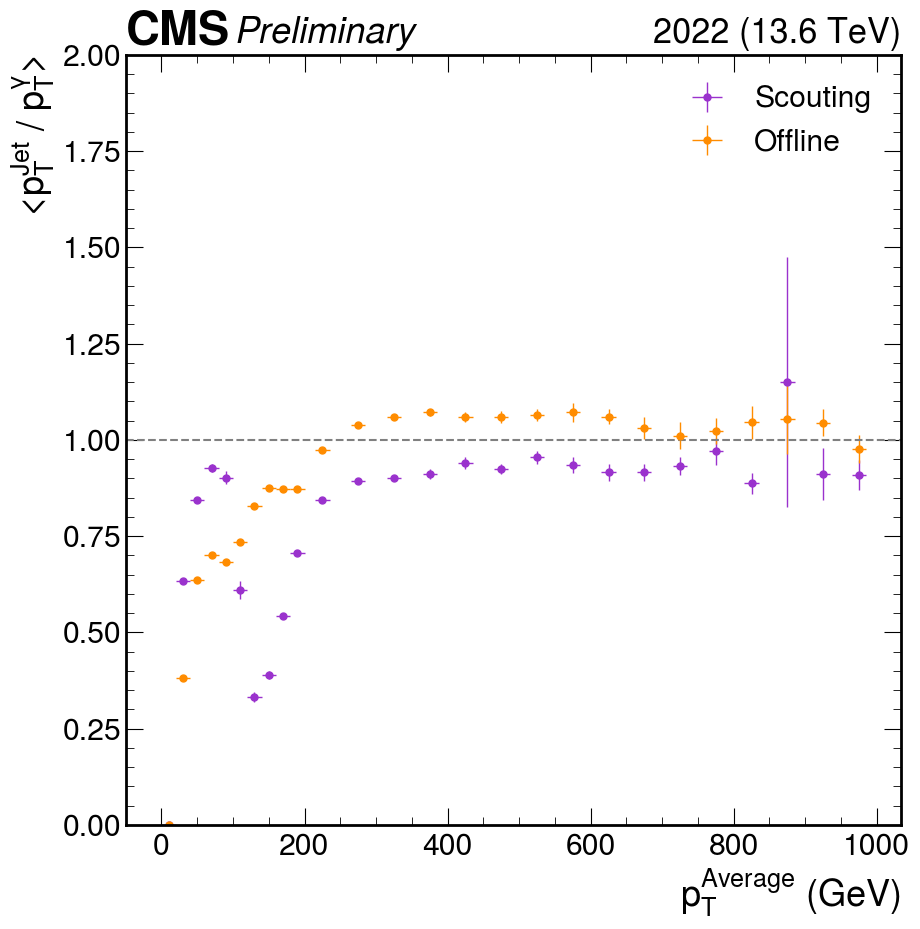

In [102]:
output = util.load("outfiles/2022/jer_photon_ScoutingPFMonitor_2022-CHS_simple-binning.coffea")[0]

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

fig, ax = plt.subplots()

h_s = output["scouting_mean"][{"dataset" : sum}]
h_o = output["offline_mean"][{"dataset" : sum}]
binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

ax.errorbar(
    h_s.axes[0].centers,
    h_s.values(),
    xerr=binwidth/2,
    yerr=err(h_s) / np.sqrt(h_s.counts()),
    **data_err_opts,
    color="#9A32CD",
    label="Scouting"
)

ax.errorbar(
    h_o.axes[0].centers,
    h_o.values(),
    xerr=binwidth/2,
    yerr=err(h_o) / np.sqrt(h_o.counts()),
    **data_err_opts,
    color="#FF8C00",
    label="Offline"
)

mplhep.cms.label(ax=ax, data=True, year="2022", com=13.6, label="Preliminary")
ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
ax.set_ylabel(r"<$p_T^{Jet}$ / $p_T^{\gamma}$>")
ax.axhline(1, color='gray',ls='--')
ax.legend(loc="best")
ax.set_ylim(0, 2)
#ax.set_xscale("log")

In [103]:
output = util.load("outfiles/2022/jer_photon_ScoutingPFMonitor_2022-CHS_simple-binning.coffea")[0]

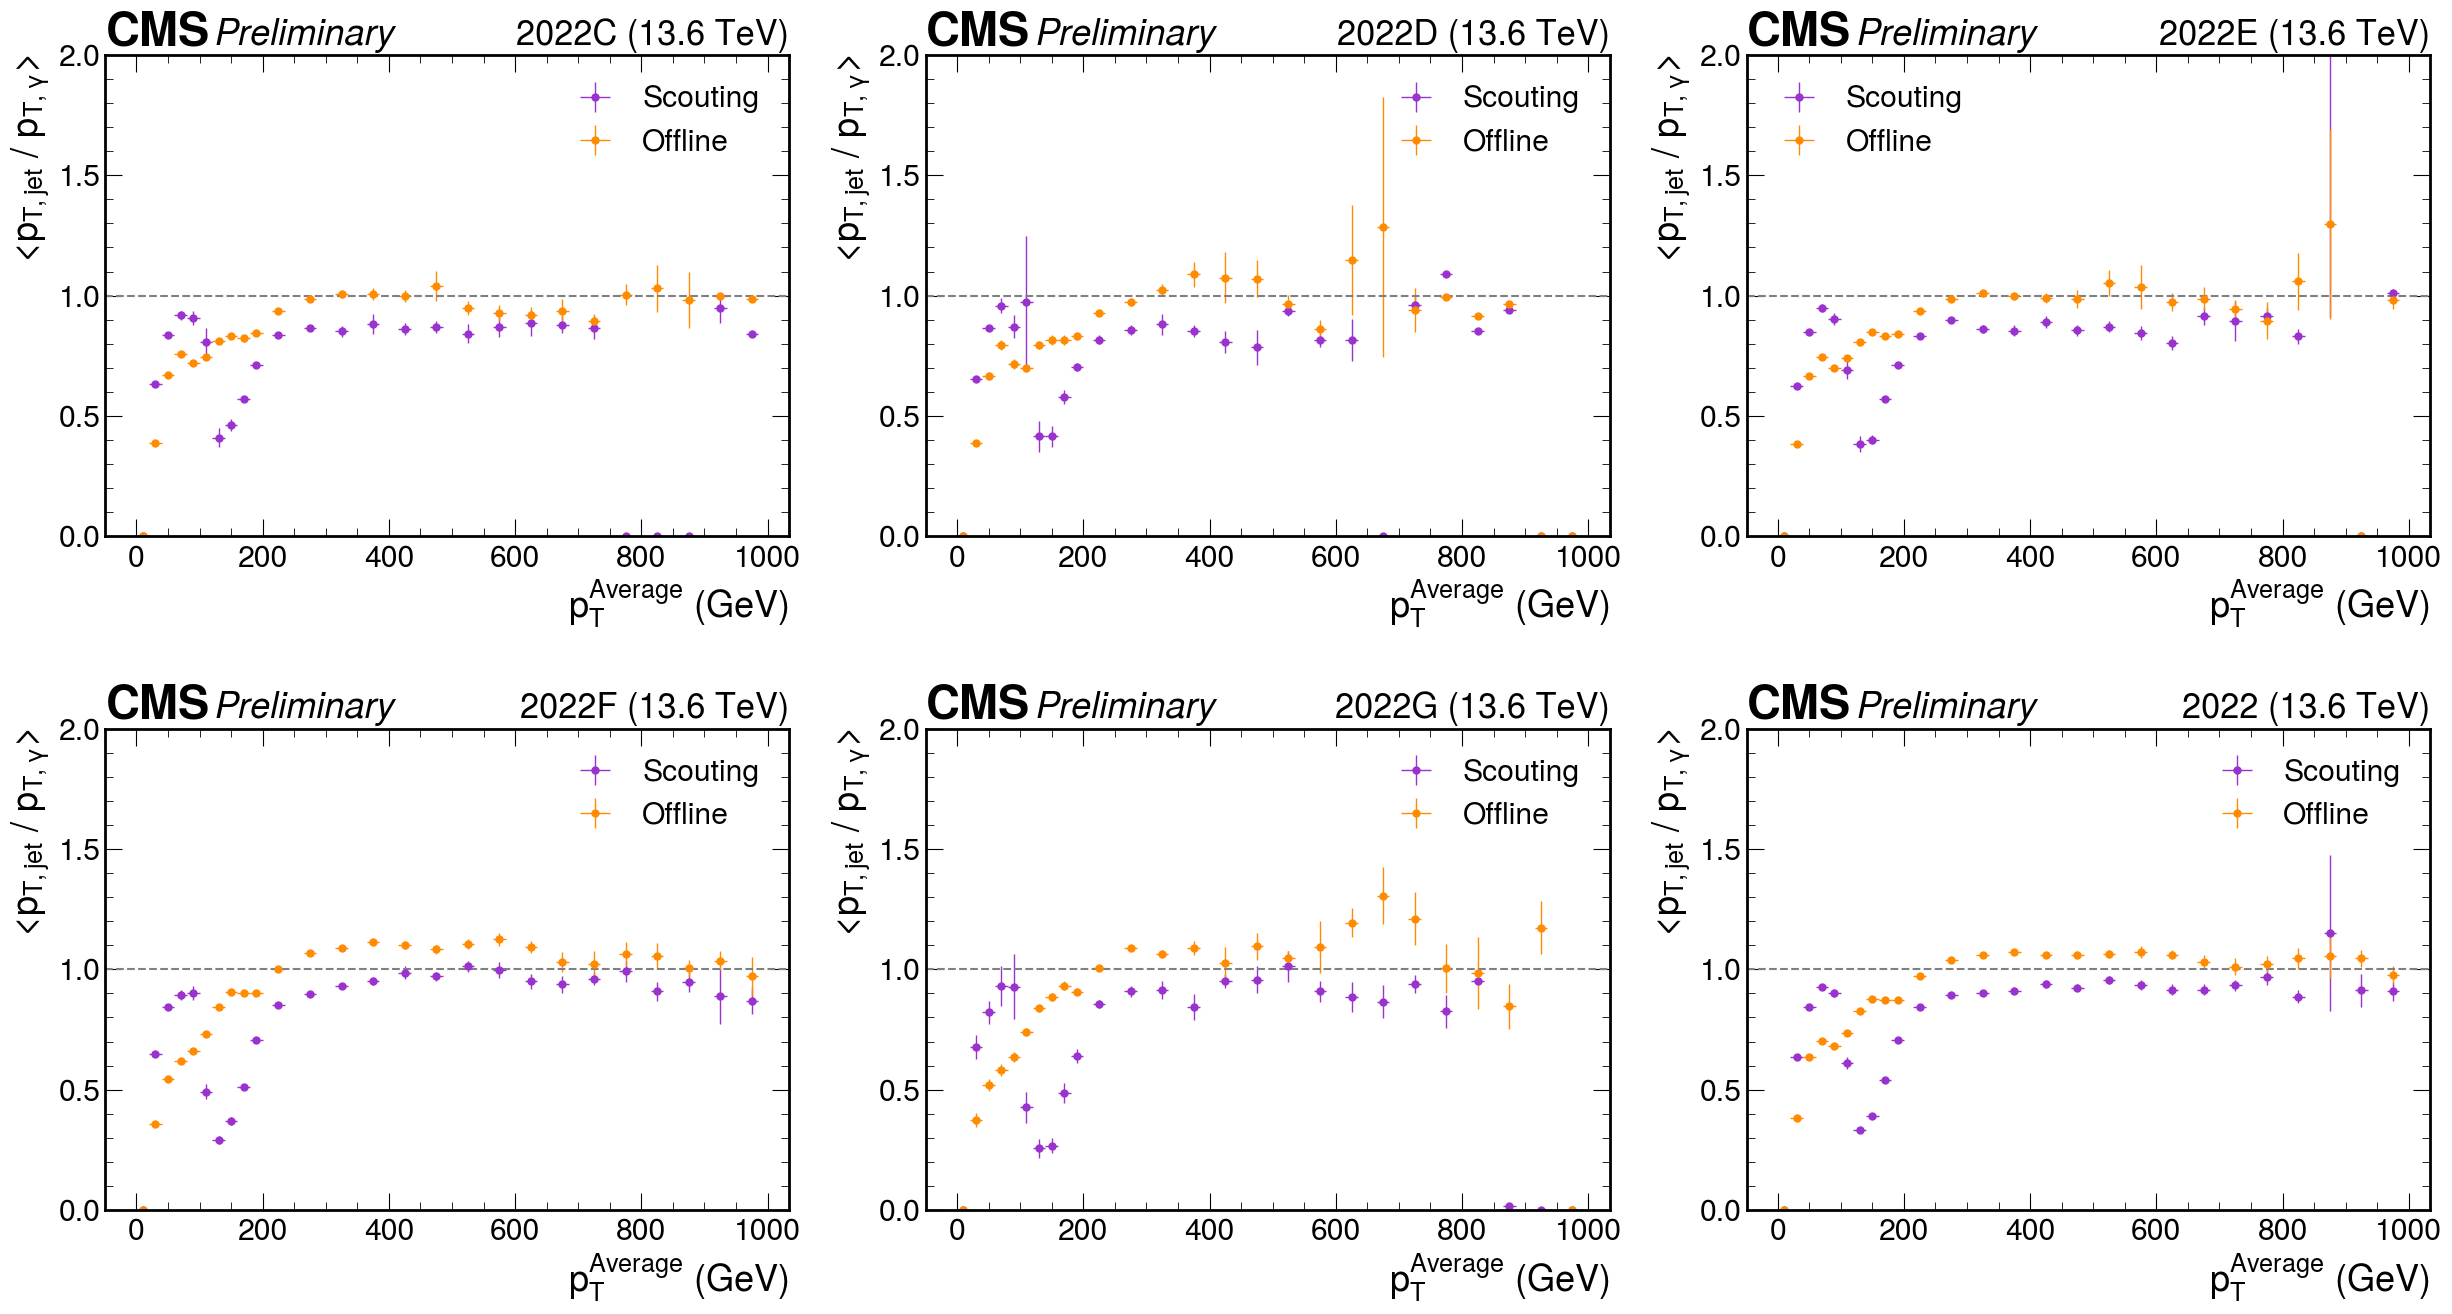

In [105]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]

    h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

    ax.errorbar(
        h_s.axes[0].centers,
        h_s.values(),
        xerr=binwidth/2,
        yerr=err(h_s) / np.sqrt(h_s.counts()),
        **data_err_opts,
        color="#9A32CD",
        label="Scouting"
    )

    ax.errorbar(
        h_o.axes[0].centers,
        h_o.values(),
        xerr=binwidth/2,
        yerr=err(h_o) / np.sqrt(h_o.counts()),
        **data_err_opts,
        color="#FF8C00",
        label="Offline"
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Preliminary")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"<$p_{T, jet}$ / $p_{T, \gamma}$>")
    ax.axhline(1, color='gray',ls='--')
    ax.legend(loc="best")
    ax.set_ylim(0, 2)
    
    column += 1
    if column > 2:
        column = 0
        row += 1

/tmp/ipykernel_32/873099374.py:5: RuntimeWarning: invalid value encountered in sqrt
  return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))


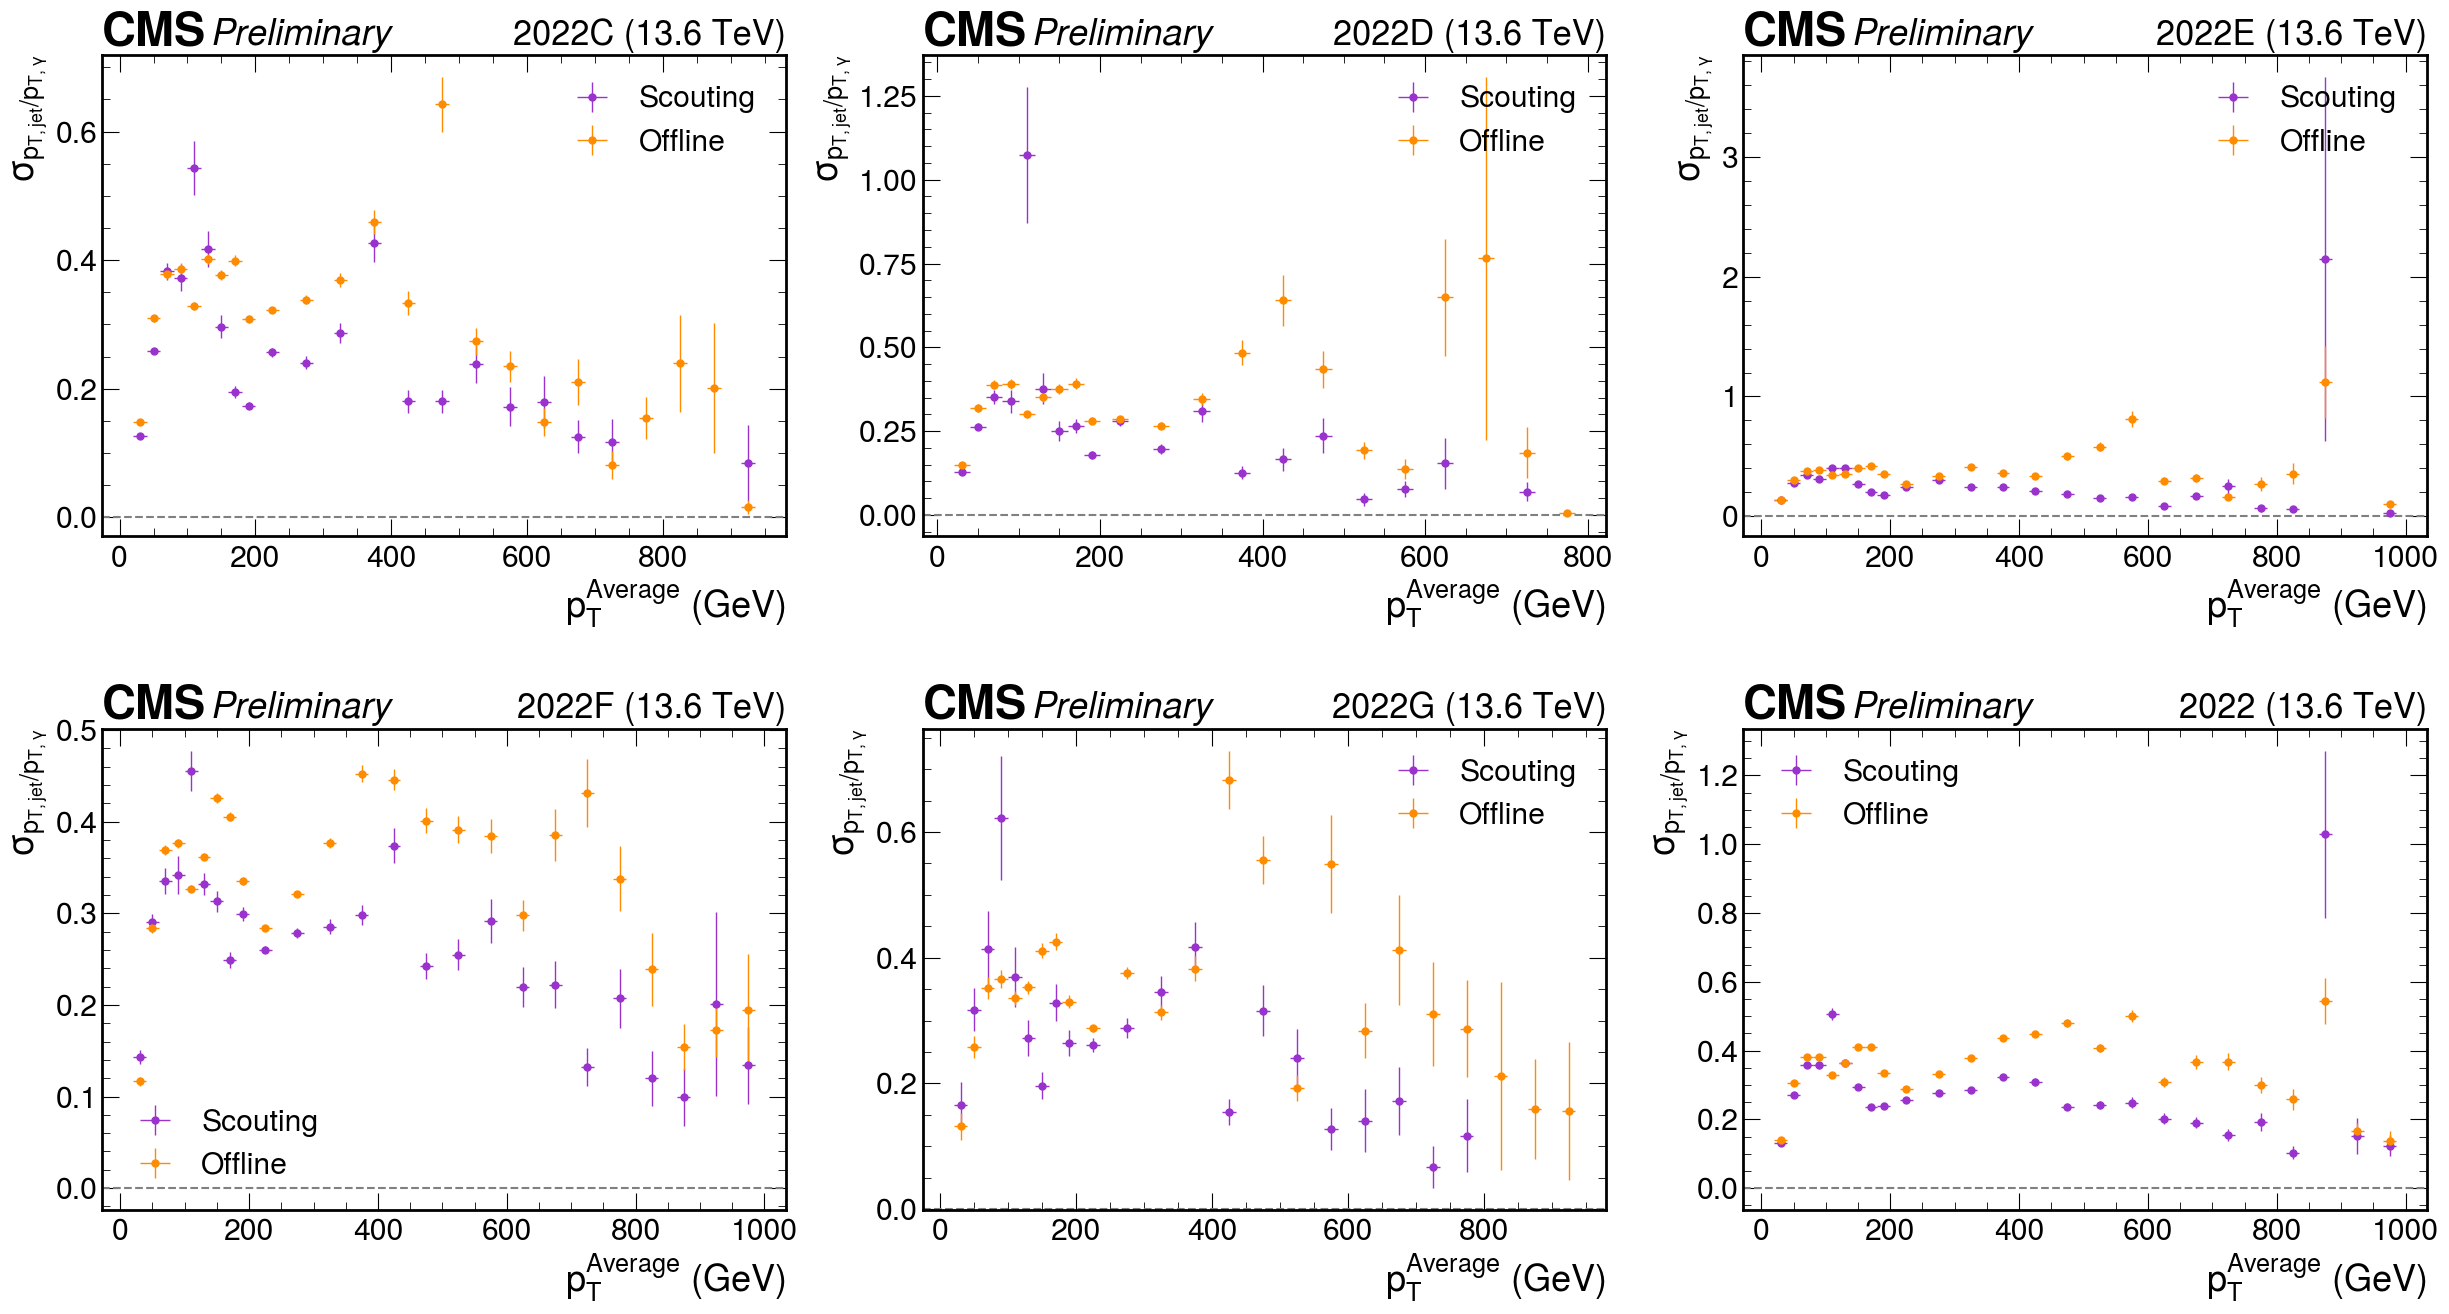

In [109]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]

    h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

    ax.errorbar(
        h_s.axes[0].centers,
        err(h_s),
        xerr=binwidth/2,
        yerr=err_err(h_s),
        **data_err_opts,
        color="#9A32CD",
        label="Scouting"
    )

    ax.errorbar(
        h_o.axes[0].centers,
        err(h_o),
        xerr=binwidth/2,
        yerr=err_err(h_o),
        **data_err_opts,
        color="#FF8C00",
        label="Offline"
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Preliminary")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_{p_{T, jet} / p_{T, \gamma}}$")
    ax.axhline(0, color='gray',ls='--')
    ax.legend(loc="best")
    #ax.set_ylim(0, 1)
    
    column += 1
    if column > 2:
        column = 0
        row += 1

/tmp/ipykernel_32/694642358.py:5: RuntimeWarning: invalid value encountered in sqrt
  return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))


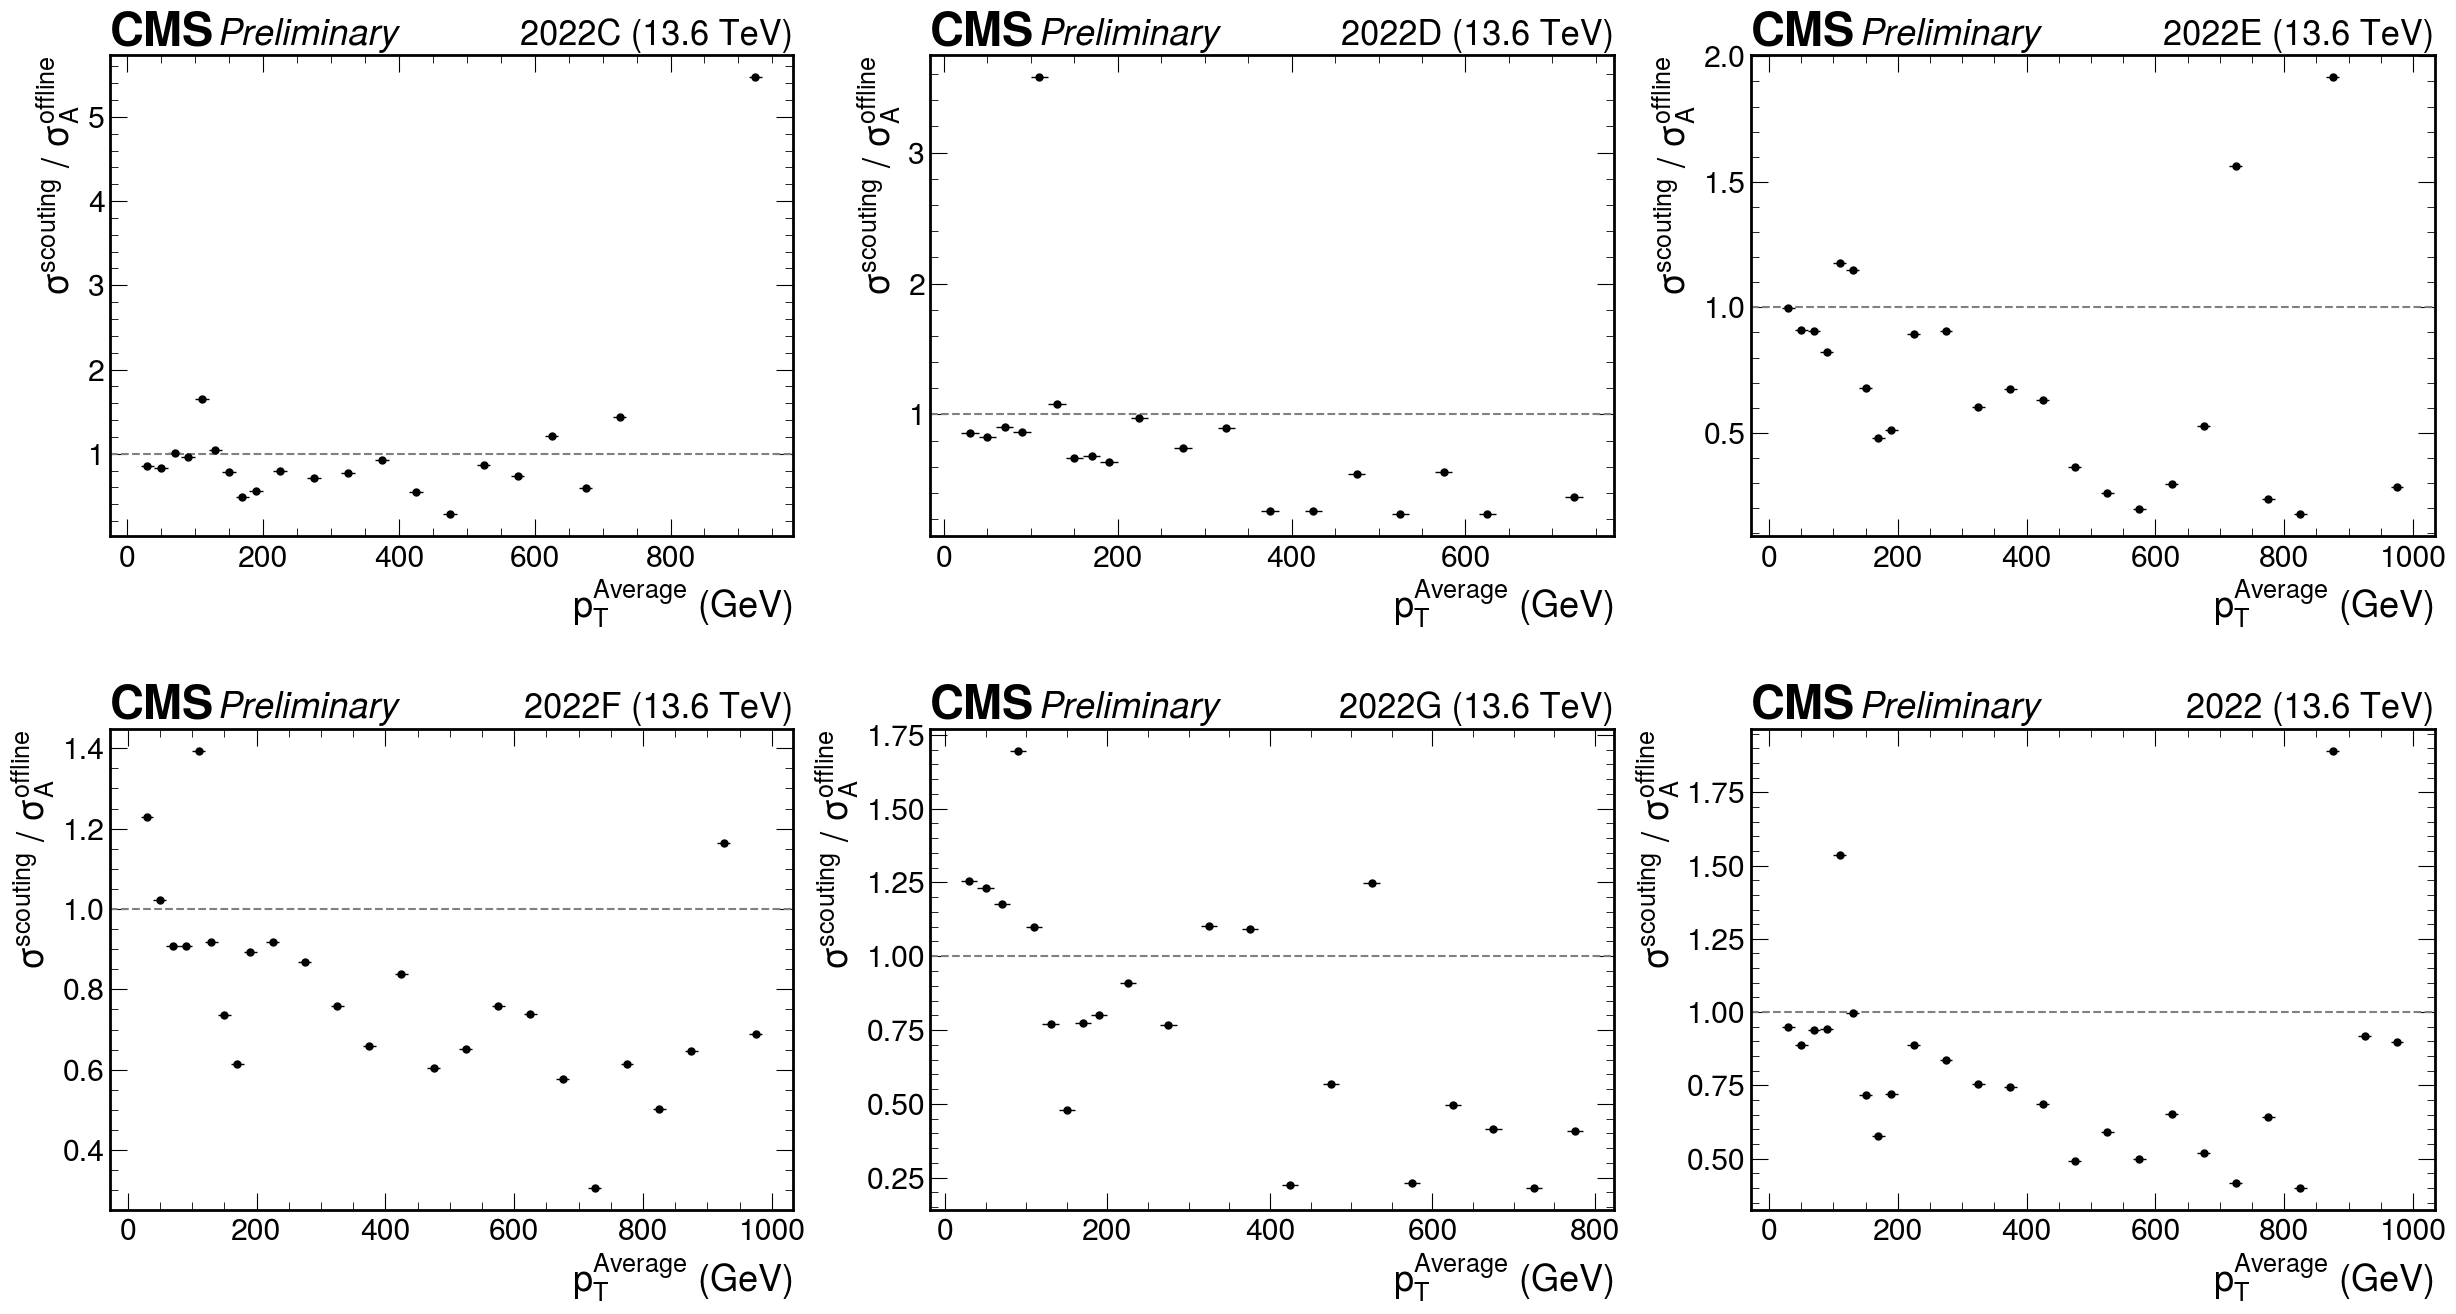

In [111]:
def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]

    h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

    ax.errorbar(
        h_s.axes[0].centers,
        err(h_s)/err(h_o),
        xerr=binwidth/2,
        yerr=err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o)),
        **data_err_opts,
        color="black"
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Preliminary")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma^{scouting}$ / $\sigma_A^{offline}$")
    ax.axhline(1, color='gray',ls='--')
    #ax.set_ylim(0, 1.5)
    
    column += 1
    if column > 2:
        column = 0
        row += 1

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


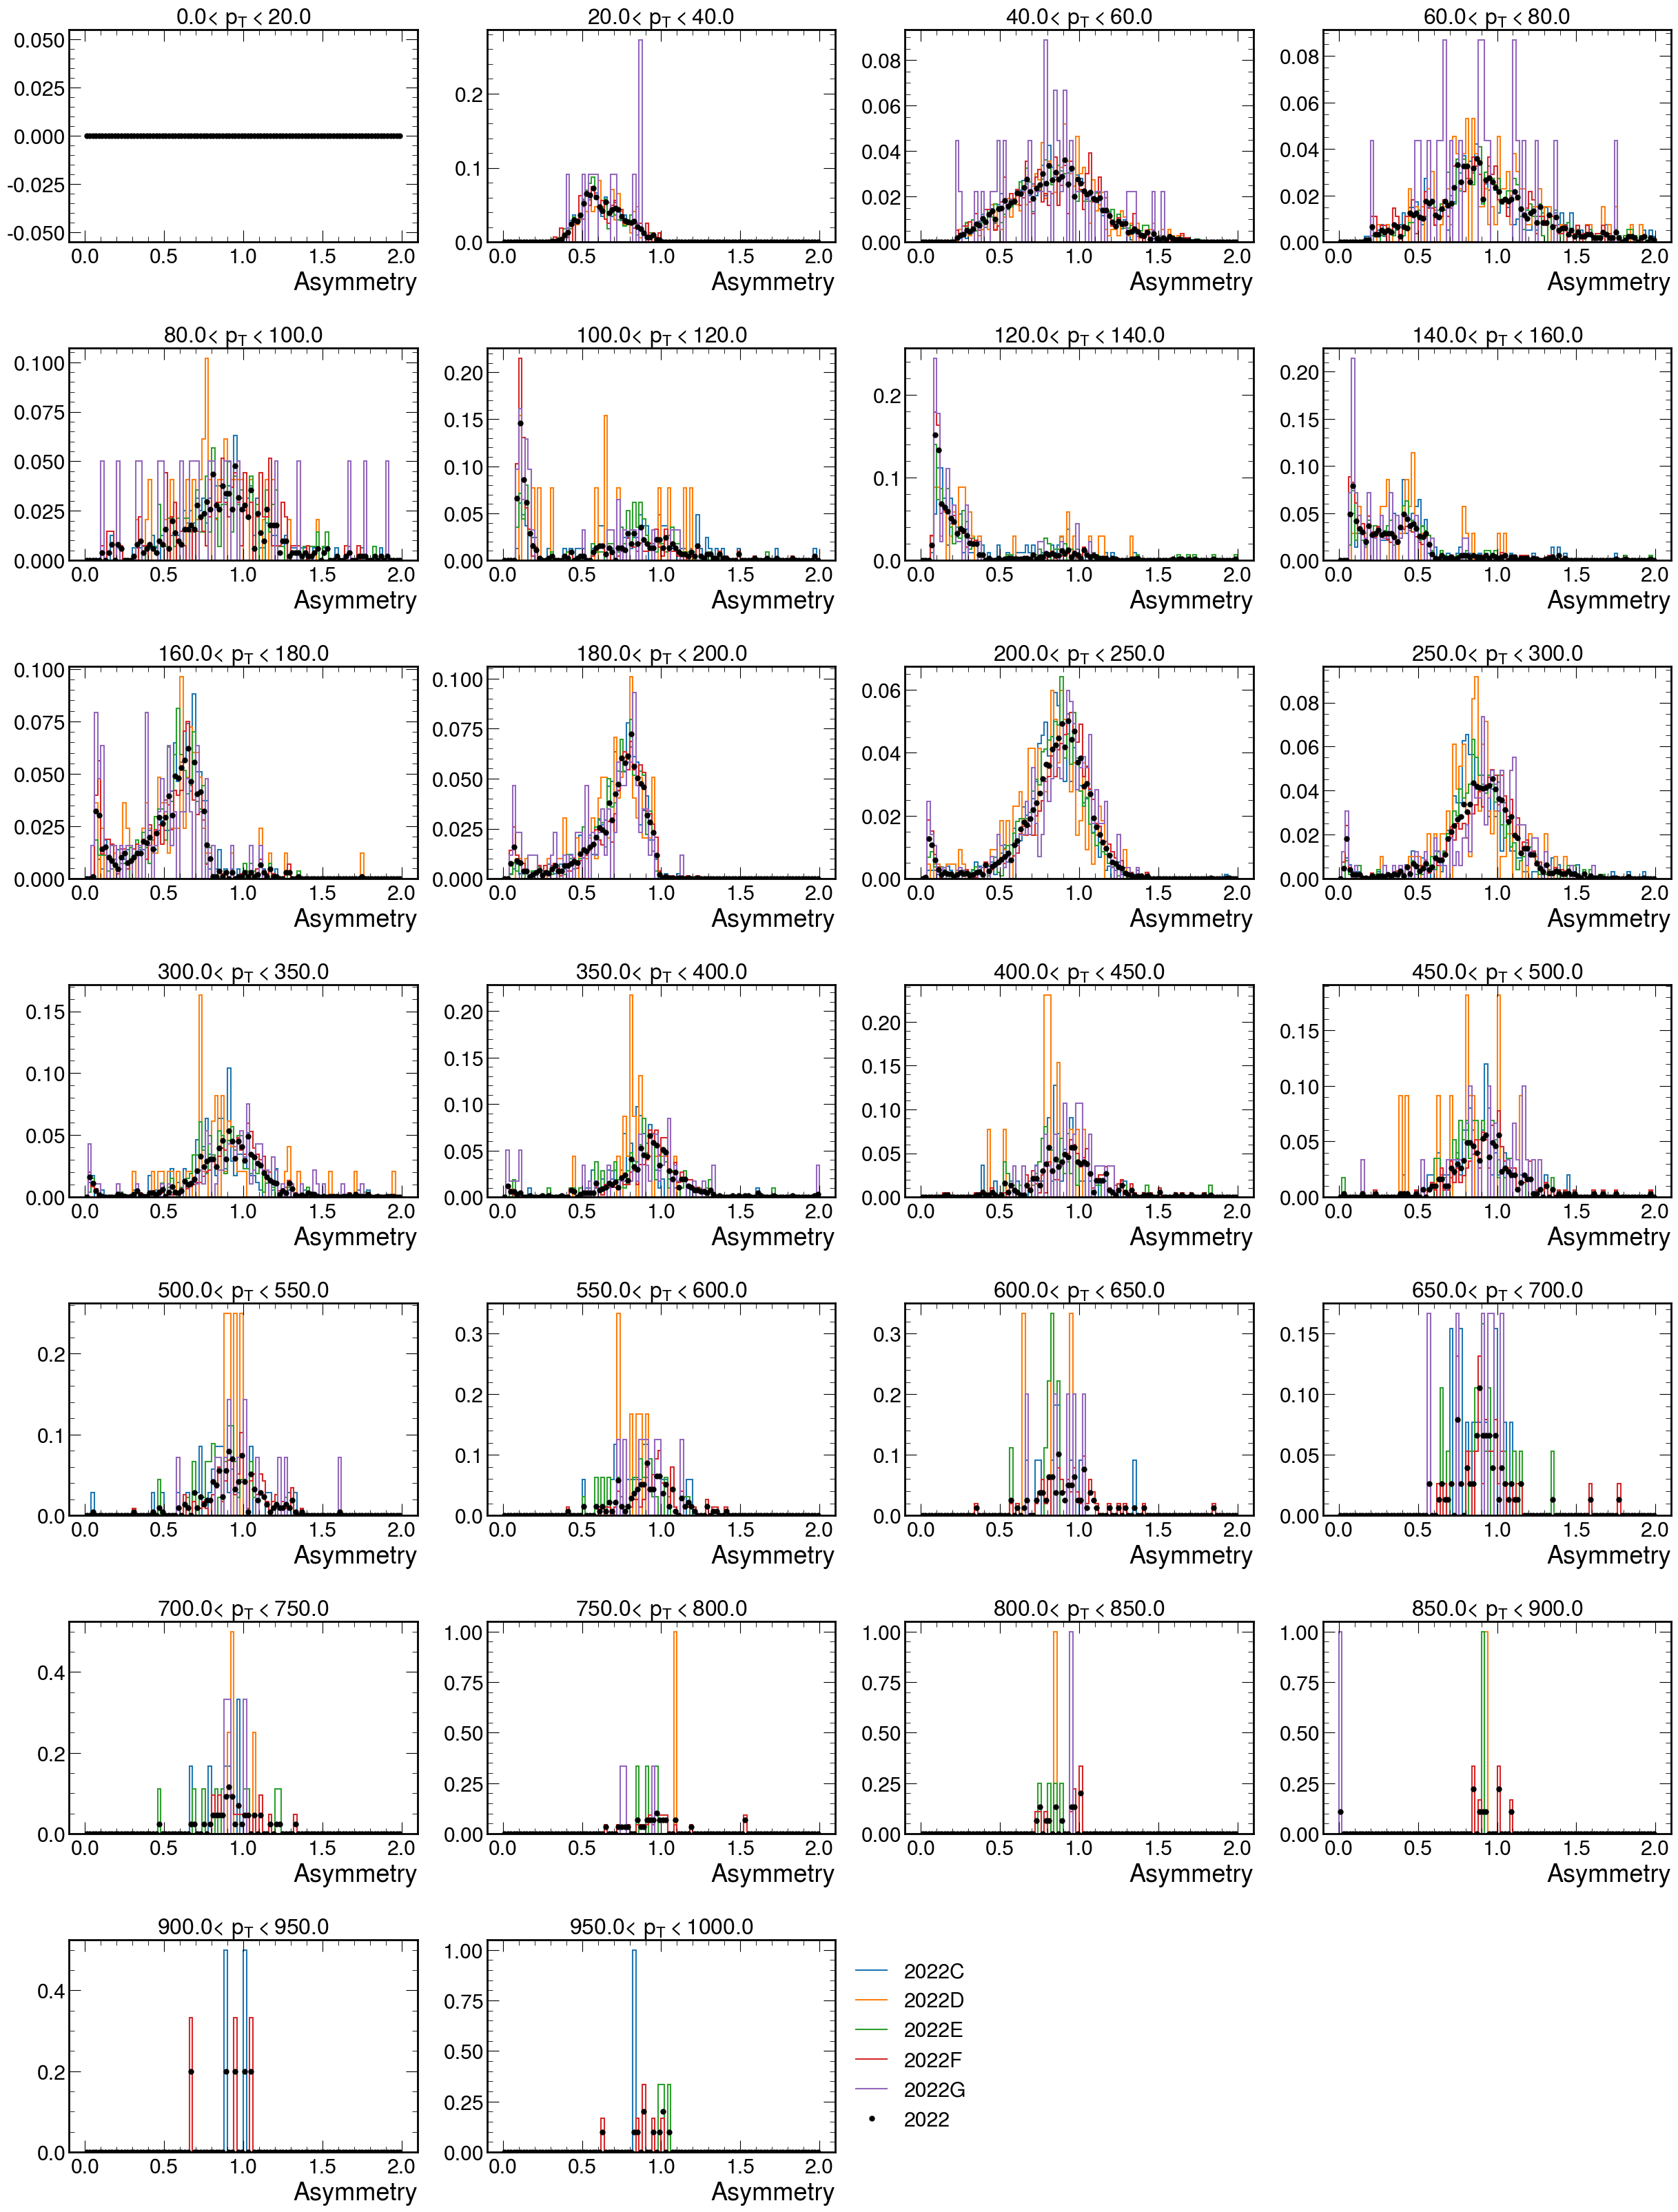

In [113]:
rec = "scouting"

centers = output[rec].project("pt_ave").axes[0].centers
edges = output[rec].project("pt_ave").axes[0].edges
        
fig, axs = plt.subplots(7, 4, figsize=(30,40))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

row = 0
column = 0

for i, _ in enumerate(centers):

    ax = axs[row, column]
    
    for era in ["C", "D", "E", "F", "G", ""]:
        
        h = output[rec][{"dataset" : sum if not era else hist.loc("2022" + era), "pt_ave" : i}]
        h *= 1 / h.sum() if h.sum() != 0 else 1
        
        data_opts = {
            "histtype" : "step",
            "yerr" : False,
            #"alpha" : 0.5,
        }
        
        if not era:
            data_opts["color"] = "black"
            data_opts["marker"] = "."
            data_opts["linestyle"] = "none"
            data_opts["histtype"] = "errorbar"

        if i == (len(centers) - 1):
            mplhep.histplot(h, ax=ax, label="2022" + era, **data_opts)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            mplhep.histplot(h, ax=ax, **data_opts)
            
        ax.set_title(f"{edges[i]}" + r"< $p_T <$" + f"{edges[i+1]}", fontsize=23)
        ax.set_xlabel("Asymmetry")
        ax.set_ylabel("")
        
    column += 1
    if column > 3:
        column = 0
        row += 1
        
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

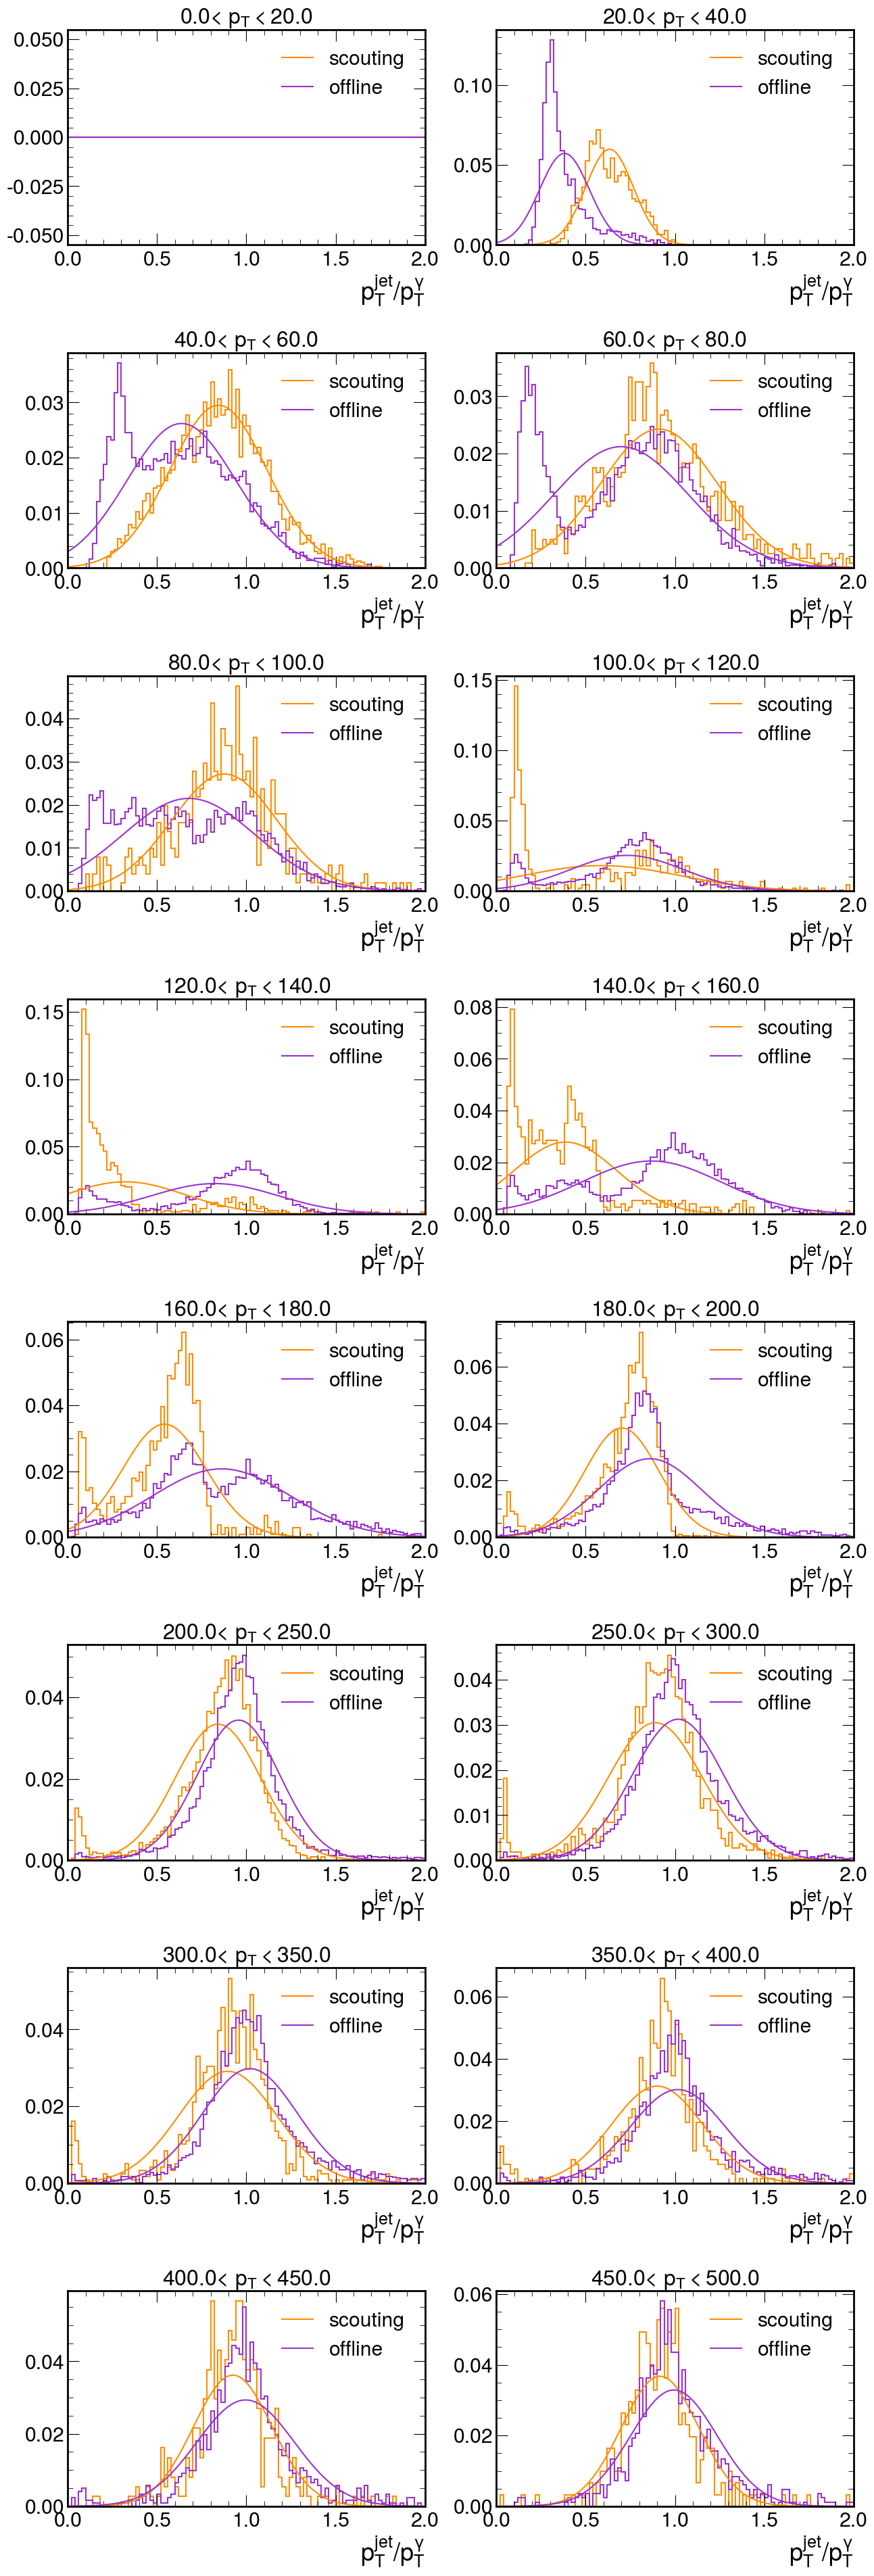

In [19]:
res_scouting = []
res_offline = []

def crystalball_cdf(x, alpha, n, mean, sigma):
    return crystalball.cdf(x, alpha, n, mean, sigma)

def gauss_cdf(x, mean, sigma):
    return norm.cdf(x, mean, sigma)

def get_centers_edges(c):
    n = c._masked[..., 0] if c._bztrafo else c._masked
    ne = (c._masked[..., 1] if c._bztrafo else c._masked) ** 0.5
    xe = c.xe
    cx = 0.5 * (xe[1:] + xe[:-1])
    if c.mask is not None:
        cx = cx[c.mask]
        
    return cx, xe

def get_prediction(c, args):
    return c.prediction(args)

output = util.load("outfiles/2022/jer_photon_ScoutingPFMonitor_2022-CHS_simple-binning.coffea")[0]

fig, axs = plt.subplots(10, 2, figsize=(15,60))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

row = 0
column = 0

centers = output["scouting"].project("pt_ave").axes[0].centers
edges = output["scouting"].project("pt_ave").axes[0].edges

for i, center in enumerate(centers):
    
#     if i < 10:
#         continue
#     if i > 10:
#         break
    if centers[i] > 500:
        continue
    
    for rec in ["scouting", "offline"]:

        ax = axs[row, column]
        h = output[rec][{"pt_ave" : i, "dataset" : sum}]
        h *= 1 / h.sum() if h.sum() != 0 else 1
        _v = h.values()
        _c = h.axes[0].centers
        _e = h.axes[0].edges
        
        colour = "#FF8C00" if rec == "scouting" else "#9A32CD"

        mplhep.histplot(h, ax=ax, color=colour)

        # crystal ball
        c = cost.BinnedNLL(_v, _e, crystalball_cdf)
        m = Minuit(c, alpha=1, n=2, mean=0, sigma=0.3)
        m.migrad()
        if rec == "scouting":
            res_scouting.append([m.values[3], m.errors[3]])
        else:
            res_offline.append([m.values[3], m.errors[3]])

        cx, xe = get_centers_edges(c)
        mu = get_prediction(c, tuple(m.values))
        ax.plot(cx, mu, c=colour, label="scouting" if rec == "scouting" else "offline")

    ax.legend(loc='best') 
    ax.set_title(f"{edges[i]}" + r"< $p_T <$" + f"{edges[i+1]}", fontsize=23)
    ax.set_xlabel(r"$p_T^{jet} / p_T^\gamma$")
    ax.set_ylabel("")
    ax.set_xlim(0, 2)

    column += 1
    if column > 1:
        column = 0
        row += 1
        
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

# dijet

In [3]:
output = util.load("outfiles/2022/jer_dijet_ScoutingPFMonitor_2022-CHS_had.coffea")[0]

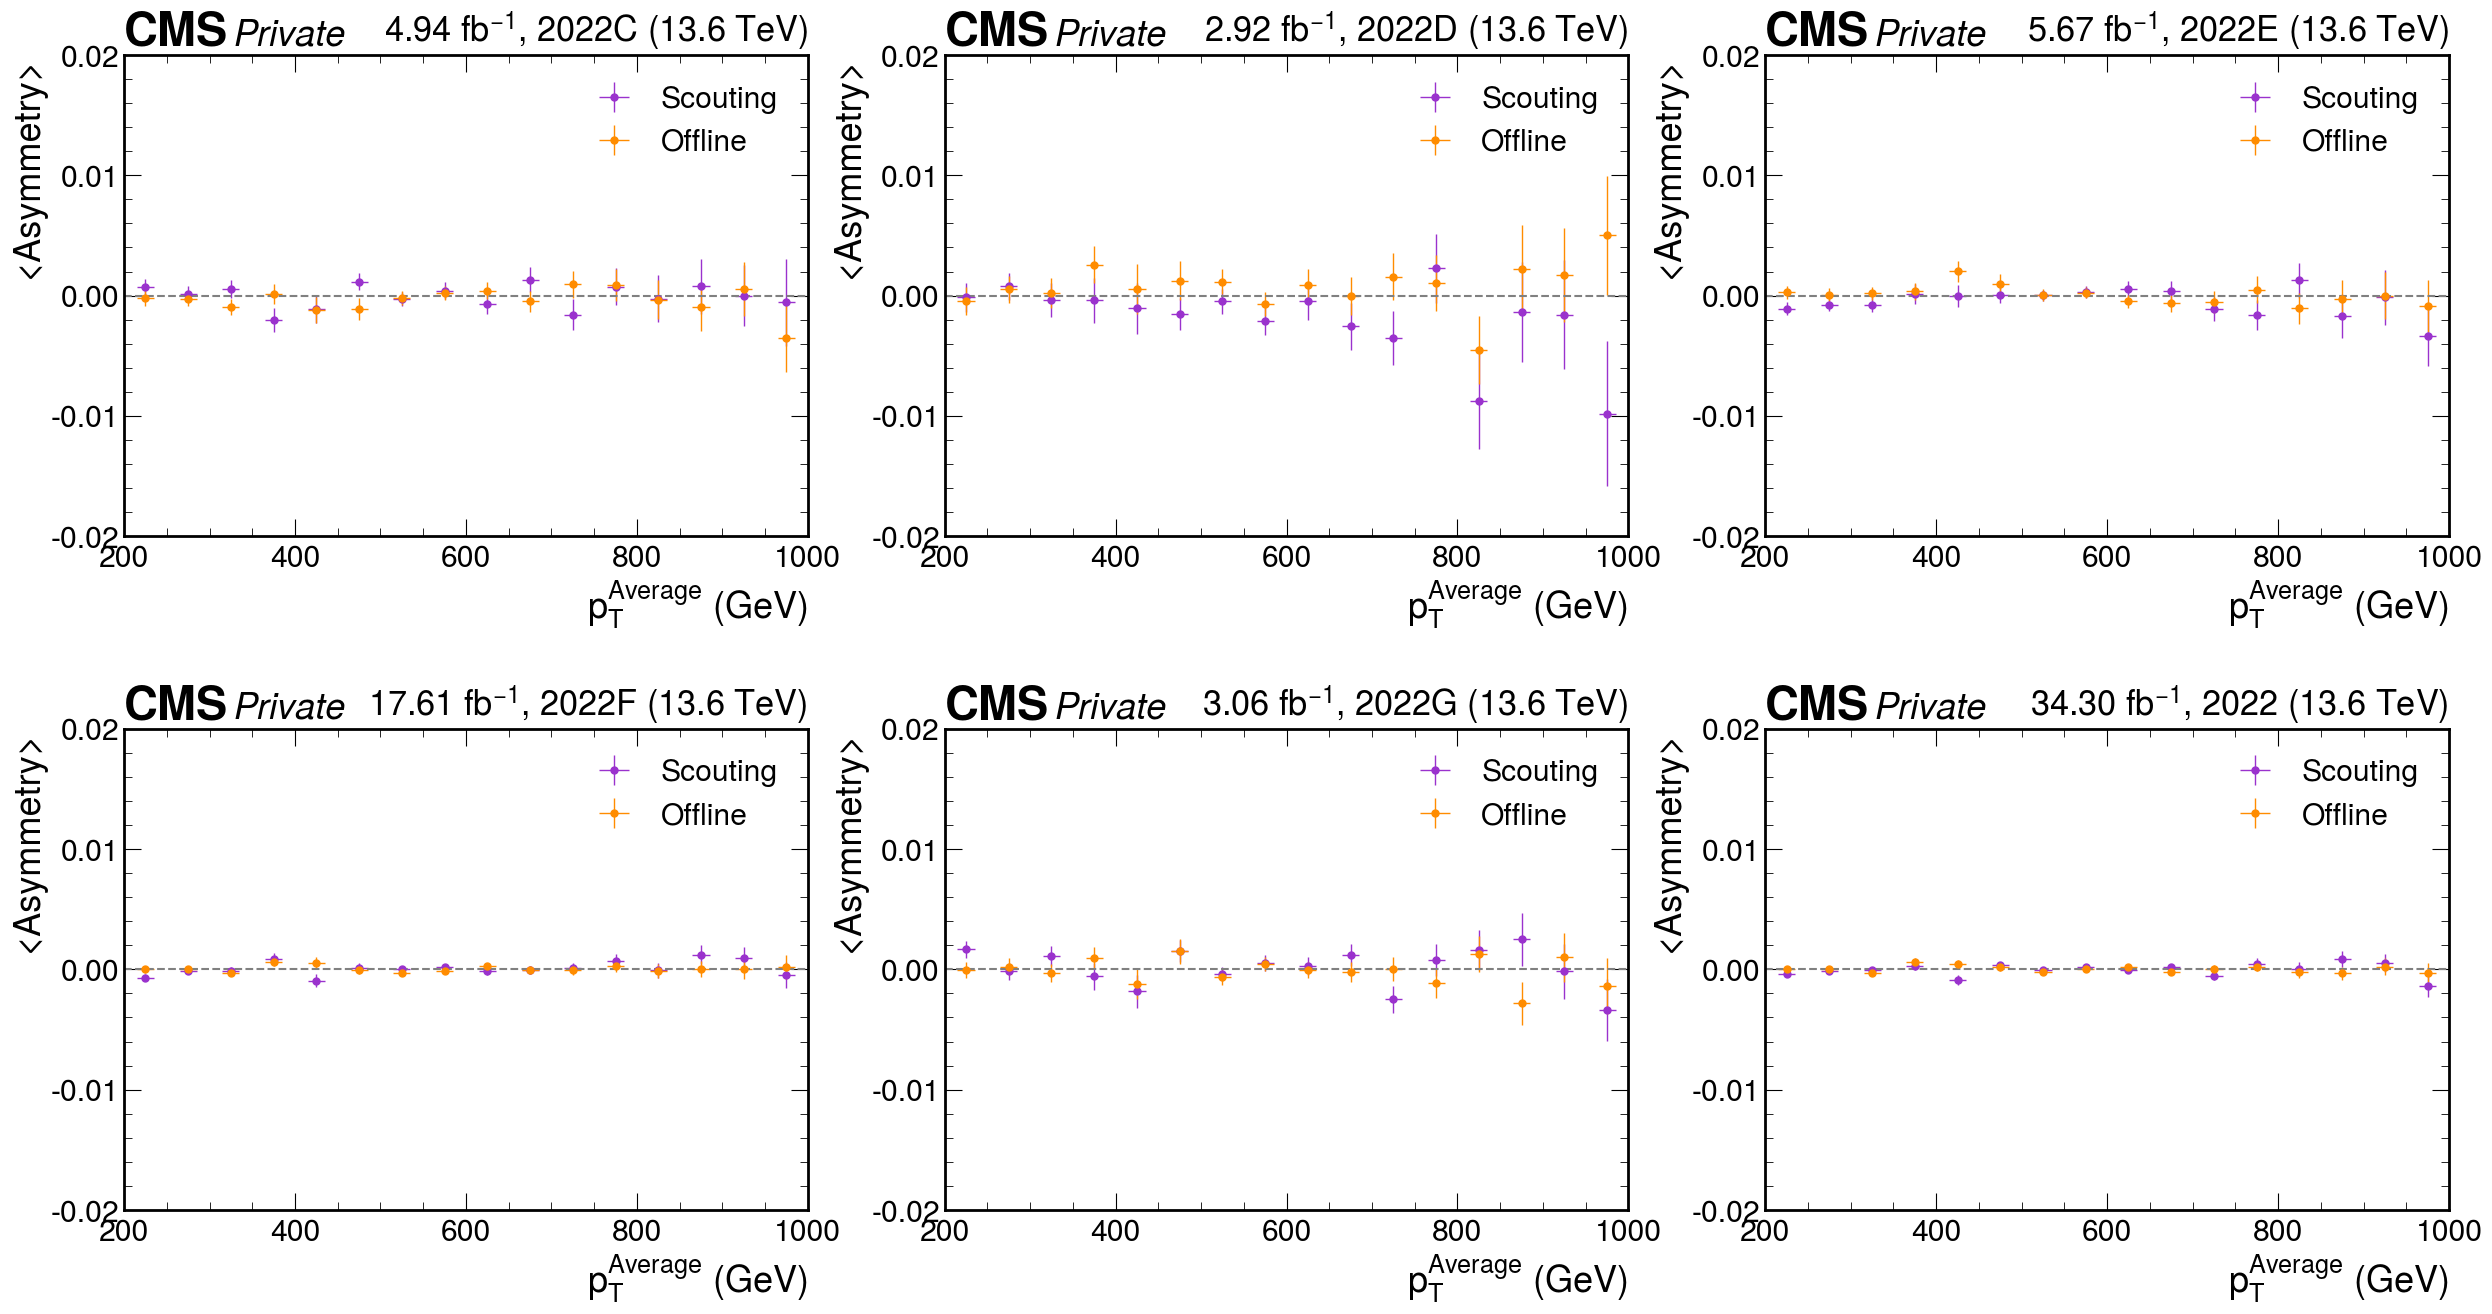

In [16]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]

    h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

    ax.errorbar(
        h_s.axes[0].centers,
        h_s.values(),
        xerr=binwidth/2,
        yerr=err(h_s) / np.sqrt(h_s.counts()),
        **data_err_opts,
        color="#9A32CD",
        label="Scouting"
    )

    ax.errorbar(
        h_o.axes[0].centers,
        h_o.values(),
        xerr=binwidth/2,
        yerr=err(h_o) / np.sqrt(h_o.counts()),
        **data_err_opts,
        color="#FF8C00",
        label="Offline"
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"<Asymmetry>")
    ax.axhline(0, color='gray',ls='--')
    ax.legend(loc="best")
    ax.set_ylim(-0.02, 0.02)
    ax.set_xlim(200, 1000)
    
    column += 1
    if column > 2:
        column = 0
        row += 1

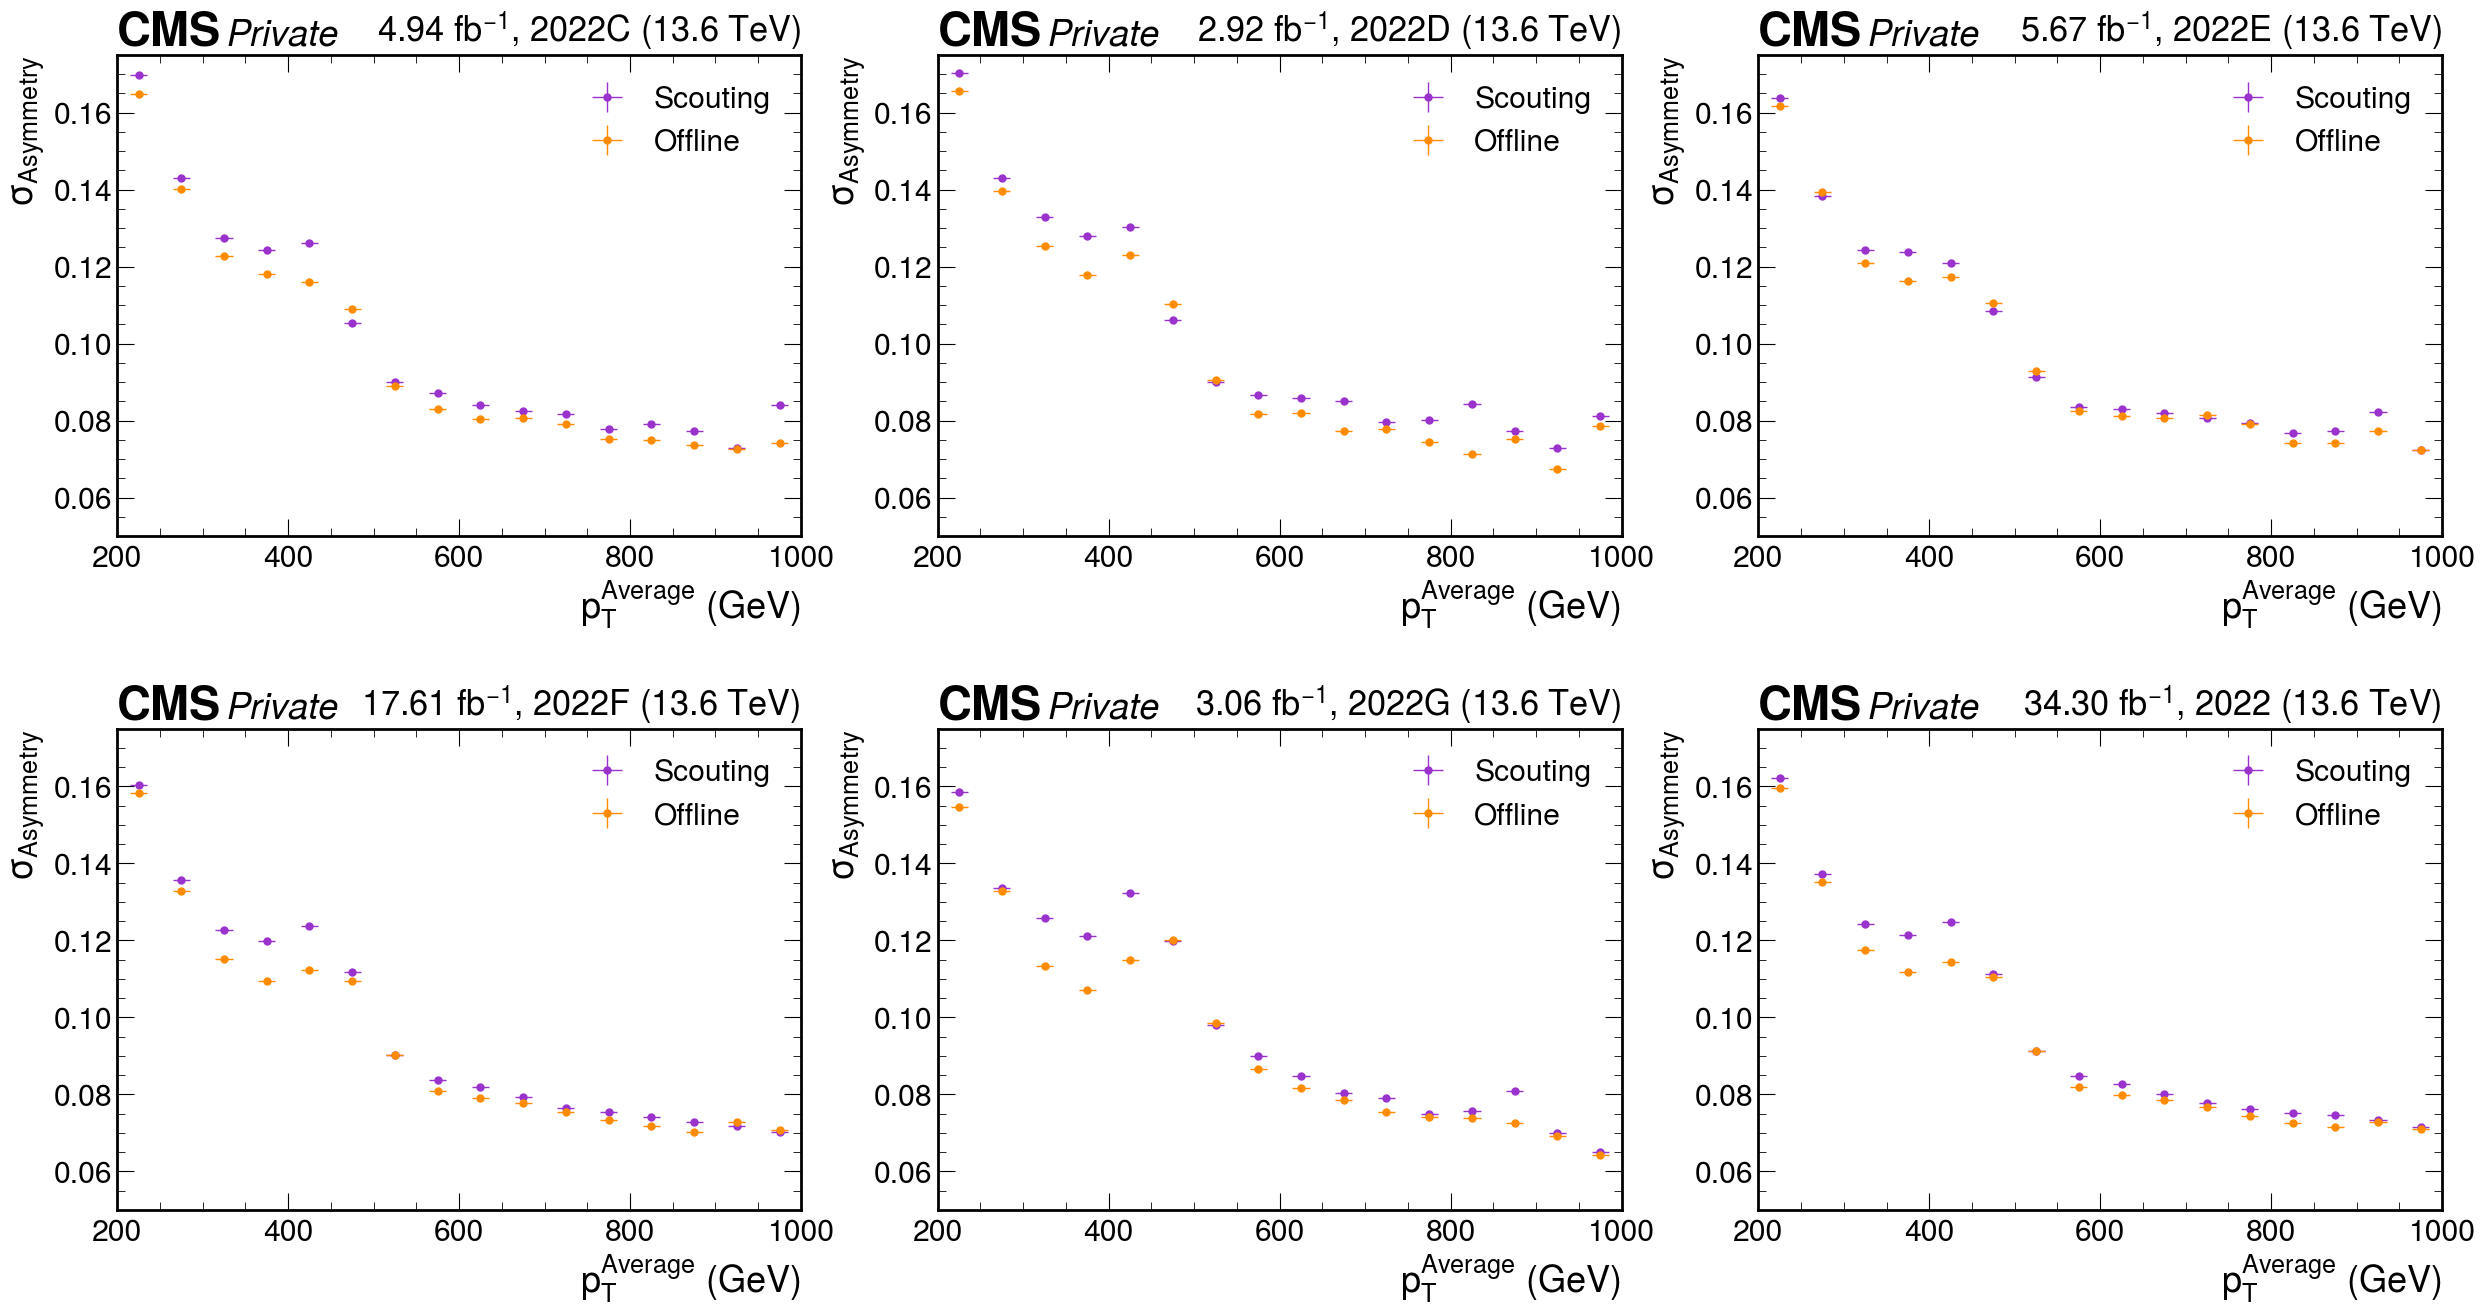

In [5]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist)**2 / np.sqrt(2 * meanhist.counts())

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]

    h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

    ax.errorbar(
        h_s.axes[0].centers,
        err(h_s),
        xerr=binwidth/2,
        yerr=[err * 1 for err in err_err(h_s)],
        **data_err_opts,
        color="#9A32CD",
        label="Scouting"
    )

    ax.errorbar(
        h_o.axes[0].centers,
        err(h_o),
        xerr=binwidth/2,
        yerr=[err * 1 for err in err_err(h_o)],
        **data_err_opts,
        color="#FF8C00",
        label="Offline"
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_{Asymmetry}$")
    ax.axhline(0, color='gray',ls='--')
    ax.legend(loc="best")
    ax.set_ylim(0.05, 0.175)
    ax.set_xlim(200, 1000)
    
    column += 1
    if column > 2:
        column = 0
        row += 1

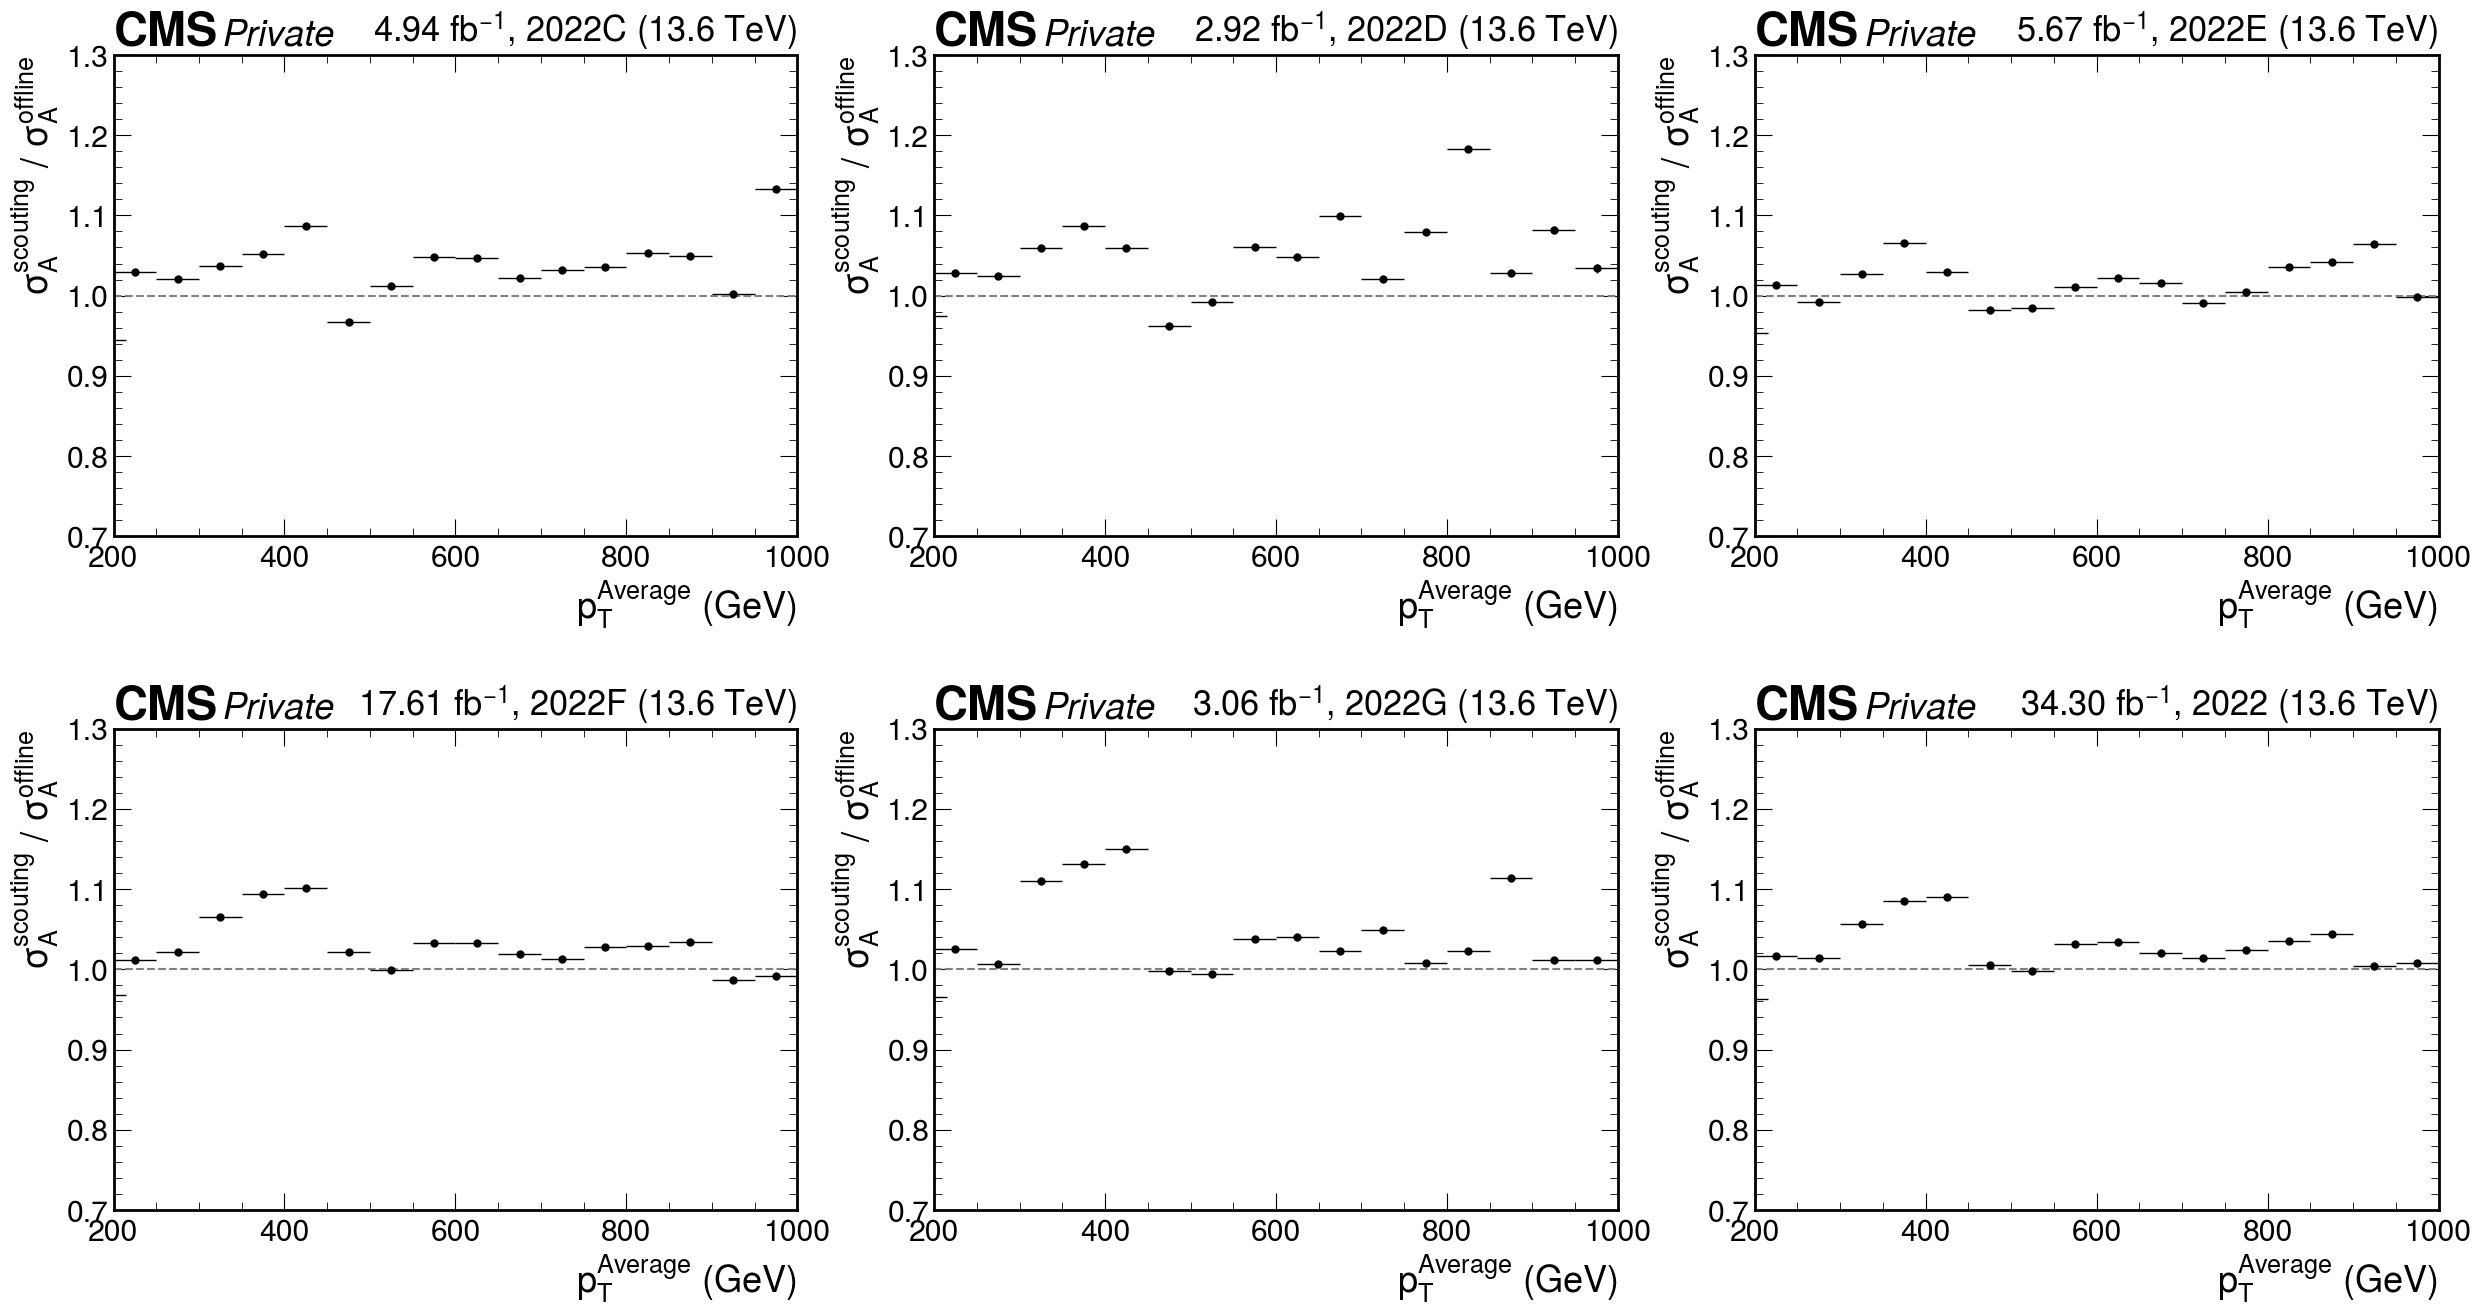

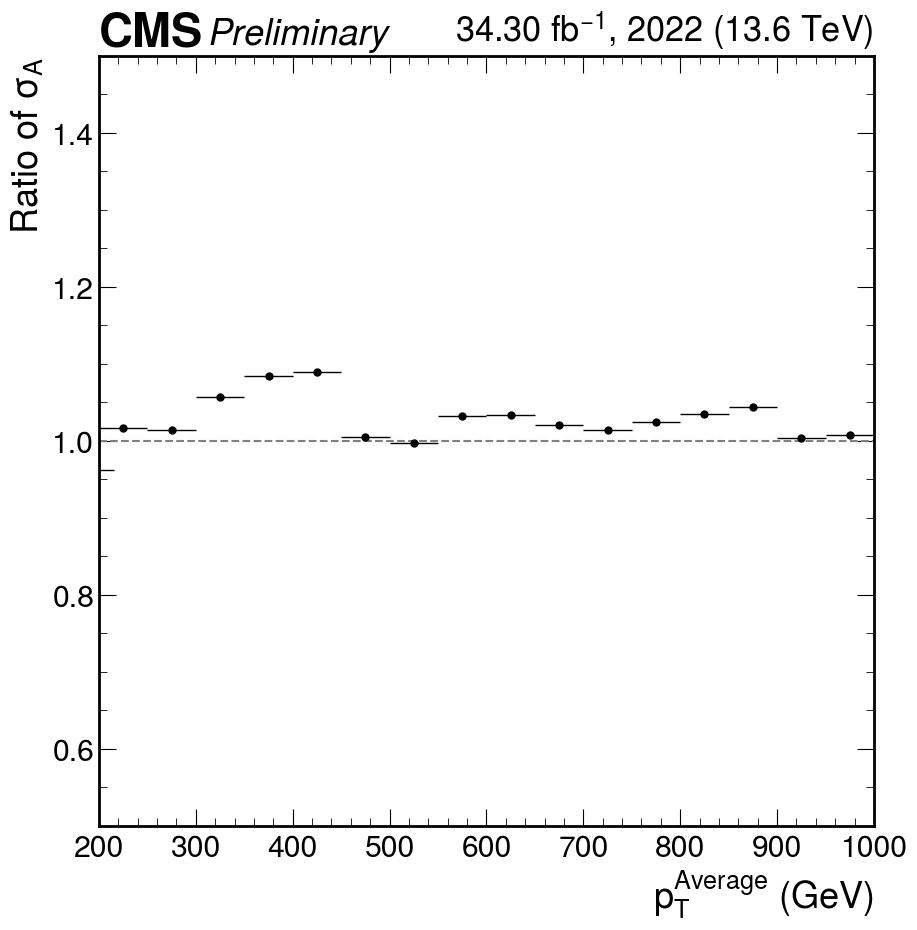

In [7]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist)**2 / np.sqrt(2 * meanhist.counts())

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
    
    return err

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]

    h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
    binwidth = h_s.axes[0].centers[-1] - h_s.axes[0].centers[-2]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

    ax.errorbar(
        h_s.axes[0].centers,
        err(h_s)/err(h_o),
        xerr=binwidth/2,
        yerr=[err * 1 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
        **data_err_opts,
        color="black"
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_A^{scouting}$ / $\sigma_A^{offline}$")
    ax.axhline(1, color='gray',ls='--')
    ax.set_ylim(0.7, 1.3)
    ax.set_xlim(200, 1000)
    
    column += 1
    if column > 2:
        column = 0
        row += 1
        
    if not era:
        fig, ax = plt.subplots(figsize=(10,10))

        ax.errorbar(
            h_s.axes[0].centers,
            err(h_s)/err(h_o),
            xerr=binwidth/2,
            yerr=[err * 1 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
            **data_err_opts,
            color="black"
        )

        mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Preliminary", lumi=f"{lumi[era]:.2f}")
        ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
        ax.set_ylabel(r"Ratio of $\sigma_A$")
        ax.axhline(1, color='gray',ls='--')
        ax.set_ylim(0.5, 1.5)
        ax.set_xlim(200, 1000)

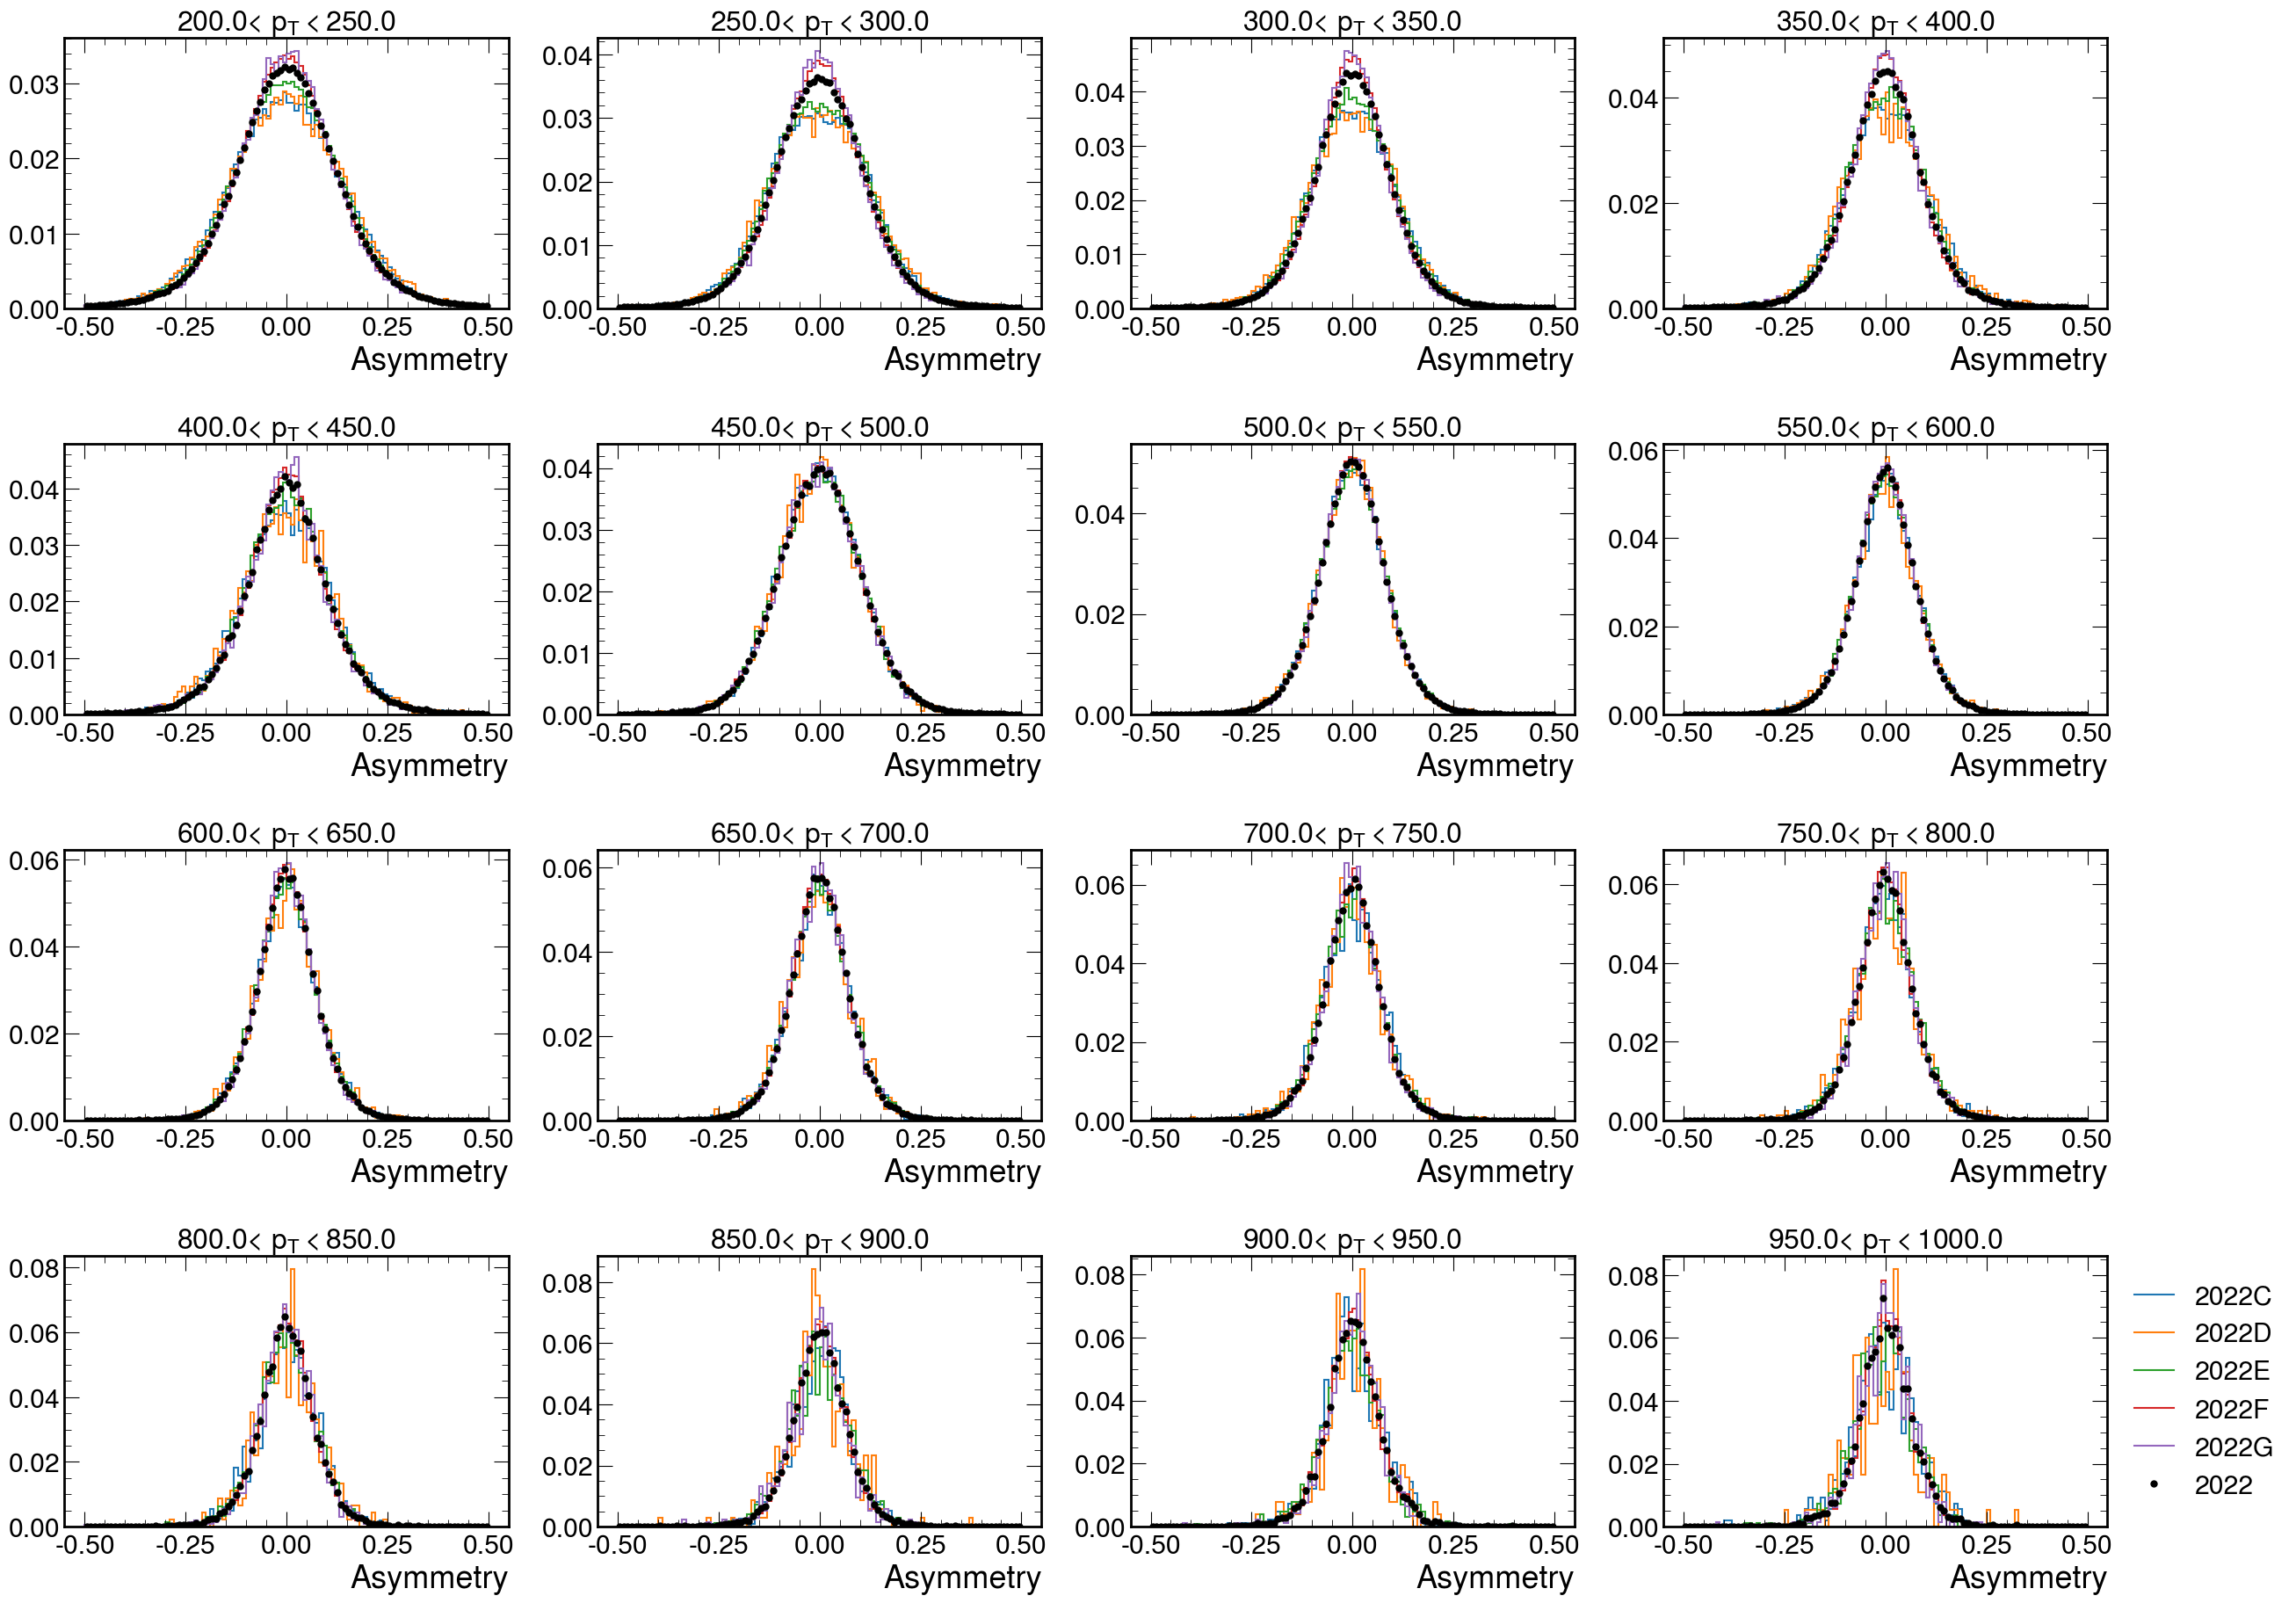

In [30]:
rec = "scouting"

centers = output[rec].project("pt_ave").axes[0].centers
edges = output[rec].project("pt_ave").axes[0].edges
        
fig, axs = plt.subplots(7, 4, figsize=(30,40))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

row = 0
column = 0

for i, _ in enumerate(centers):
    
    if centers[i] < 200:
        continue

    ax = axs[row, column]
    
    for era in ["C", "D", "E", "F", "G", ""]:
        
        h = output[rec][{"dataset" : sum if not era else hist.loc("2022" + era), "pt_ave" : i}]
        h *= 1 / h.sum() if h.sum() != 0 else 1
        
        data_opts = {
            "histtype" : "step",
            "yerr" : False,
            #"alpha" : 0.5,
        }
        
        if not era:
            data_opts["color"] = "black"
            data_opts["marker"] = "."
            data_opts["linestyle"] = "none"
            data_opts["histtype"] = "errorbar"

        if i == (len(centers) - 1):
            mplhep.histplot(h, ax=ax, label="2022" + era, **data_opts)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            mplhep.histplot(h, ax=ax, **data_opts)
            
        ax.set_title(f"{edges[i]}" + r"< $p_T <$" + f"{edges[i+1]}", fontsize=23)
        ax.set_xlabel("Asymmetry")
        ax.set_ylabel("")
        
    column += 1
    if column > 3:
        column = 0
        row += 1
        
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

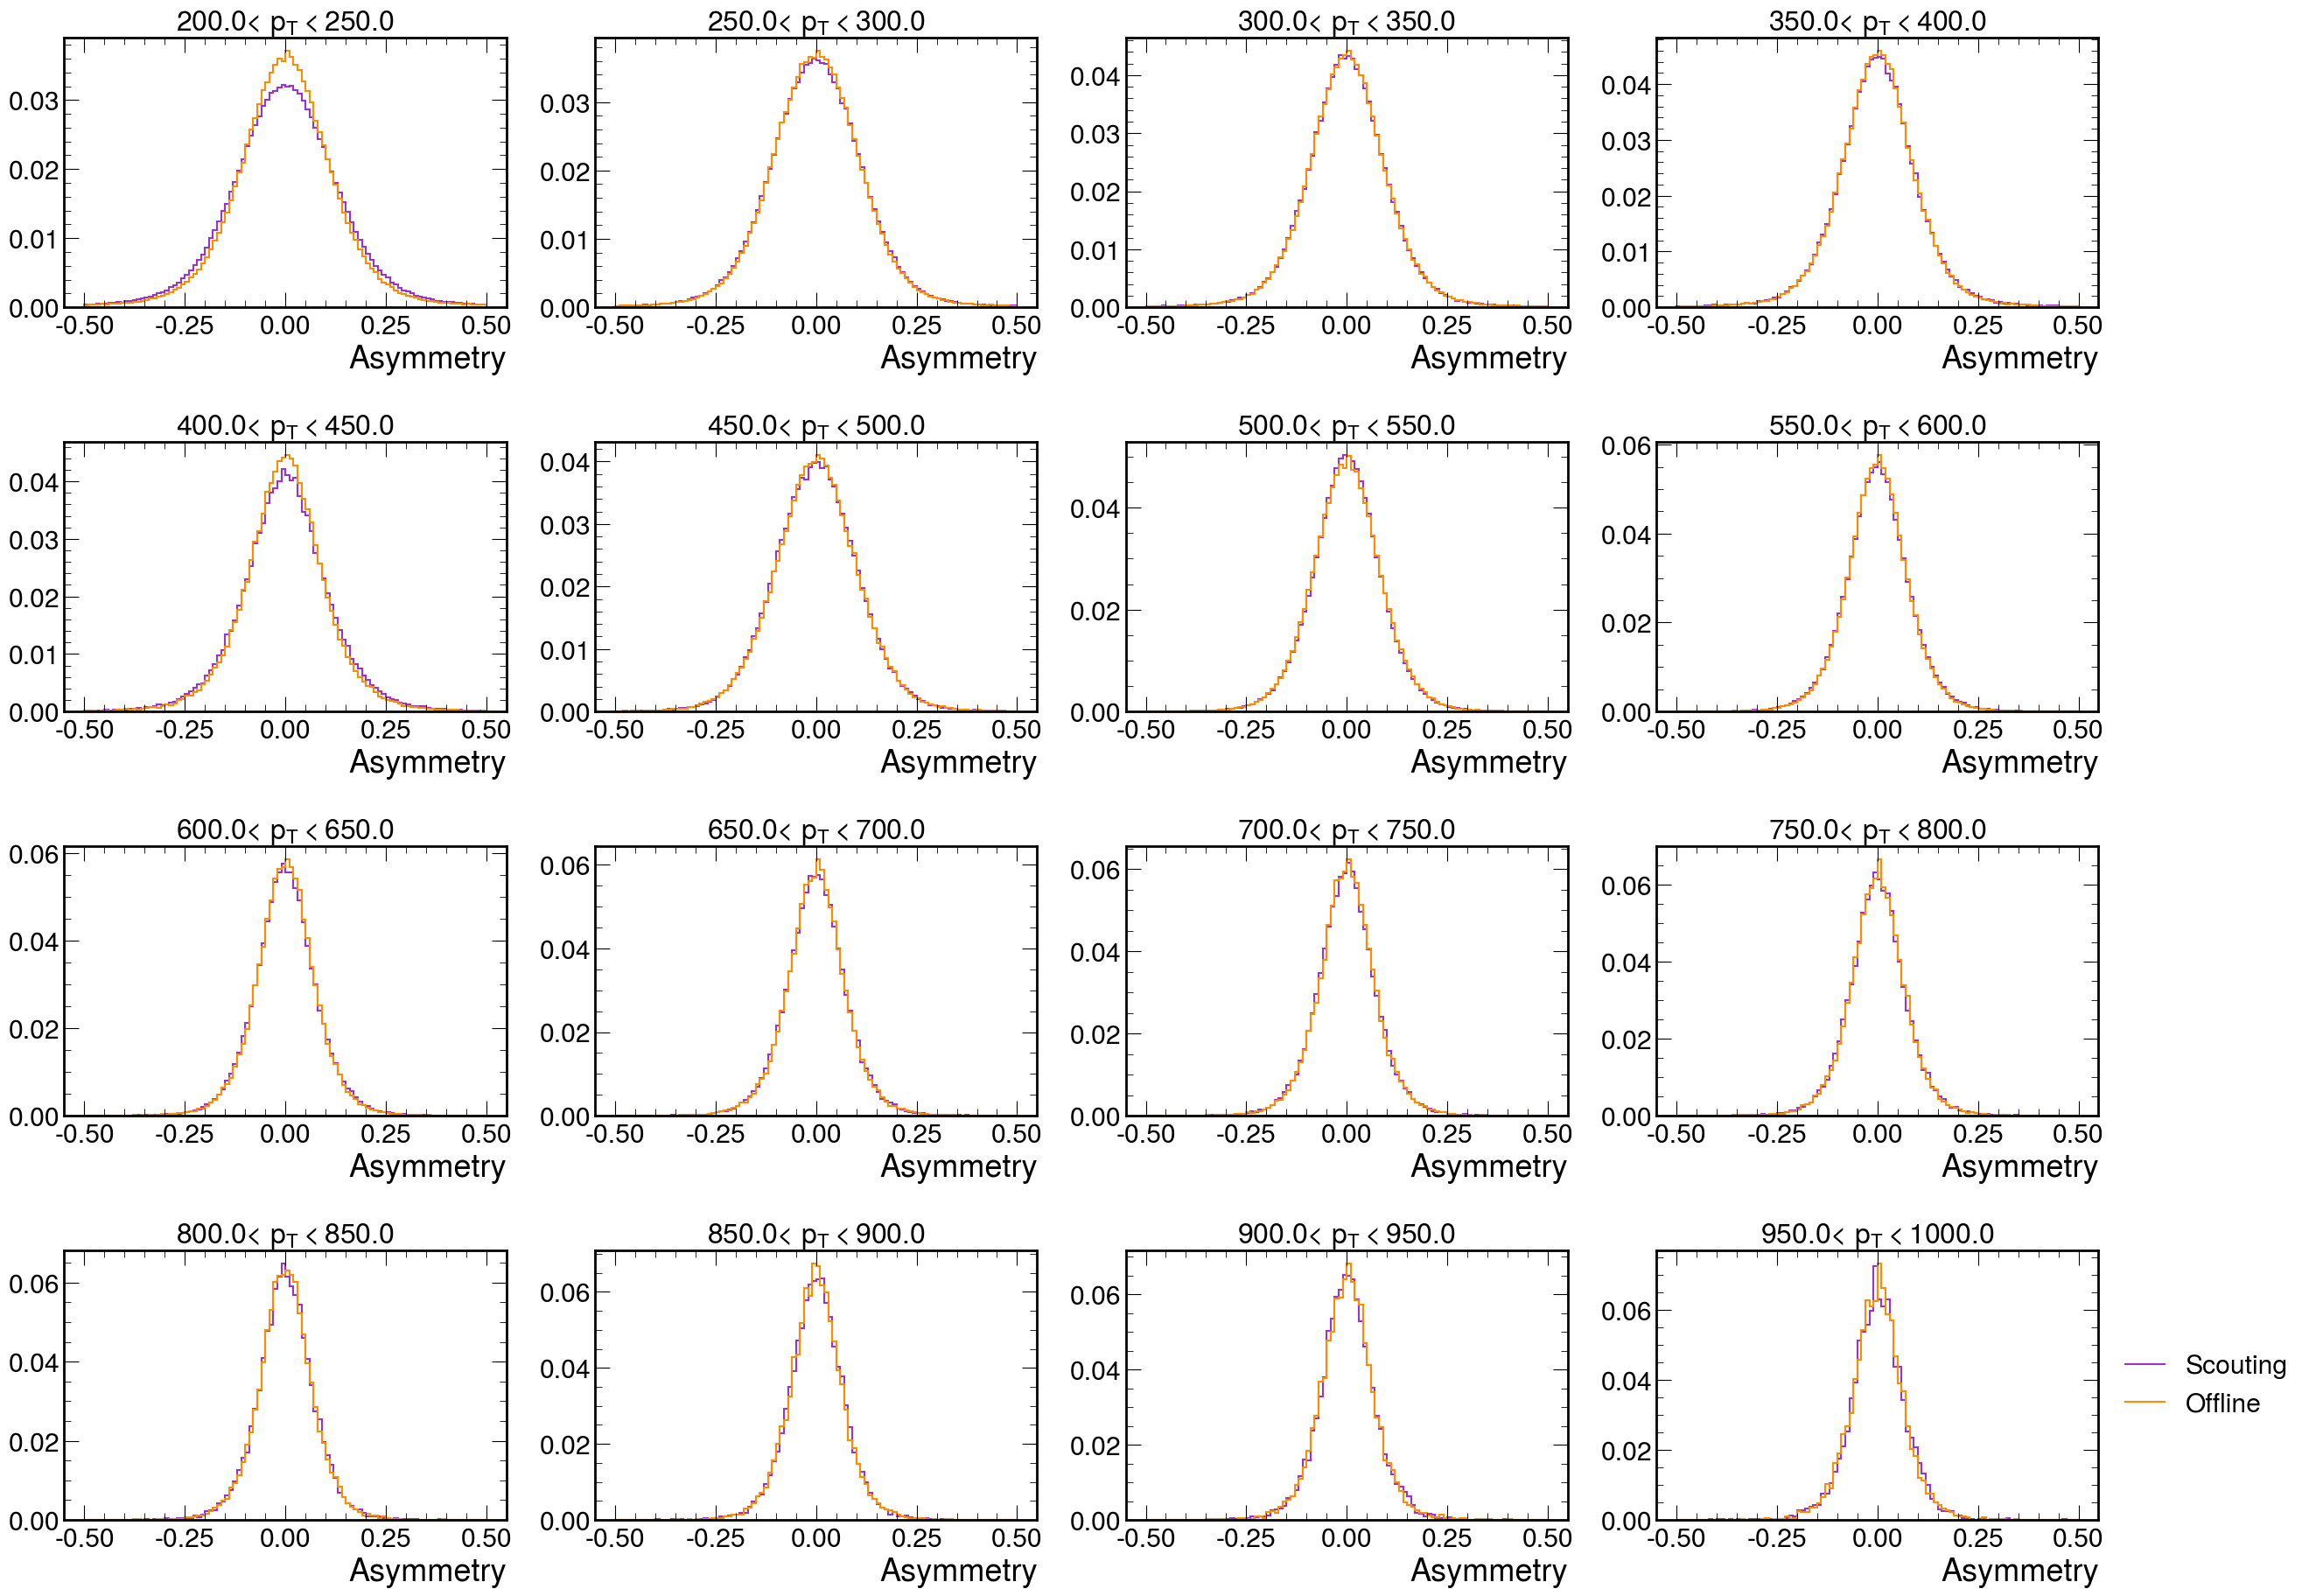

In [37]:
centers = output[rec].project("pt_ave").axes[0].centers
edges = output[rec].project("pt_ave").axes[0].edges
        
fig, axs = plt.subplots(7, 4, figsize=(30,40))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

row = 0
column = 0

for i, _ in enumerate(centers):
    
    if centers[i] < 200:
        continue

    ax = axs[row, column]
    
    for rec in ["scouting", "offline"]:
        
        h = output[rec][{"dataset" : sum, "pt_ave" : i}]
        h *= 1 / h.sum() if h.sum() != 0 else 1
        
        data_opts = {
            "histtype" : "step",
            "yerr" : False,
            "color" : "#FF8C00" if rec == "offline" else "#9A32CD",
        }

        if i == (len(centers) - 1):
            mplhep.histplot(h, ax=ax, label=rec.capitalize(), **data_opts)
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            mplhep.histplot(h, ax=ax, **data_opts)
            
        ax.set_title(f"{edges[i]}" + r"< $p_T <$" + f"{edges[i+1]}", fontsize=23)
        ax.set_xlabel("Asymmetry")
        ax.set_ylabel("")
        
    column += 1
    if column > 3:
        column = 0
        row += 1
        
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

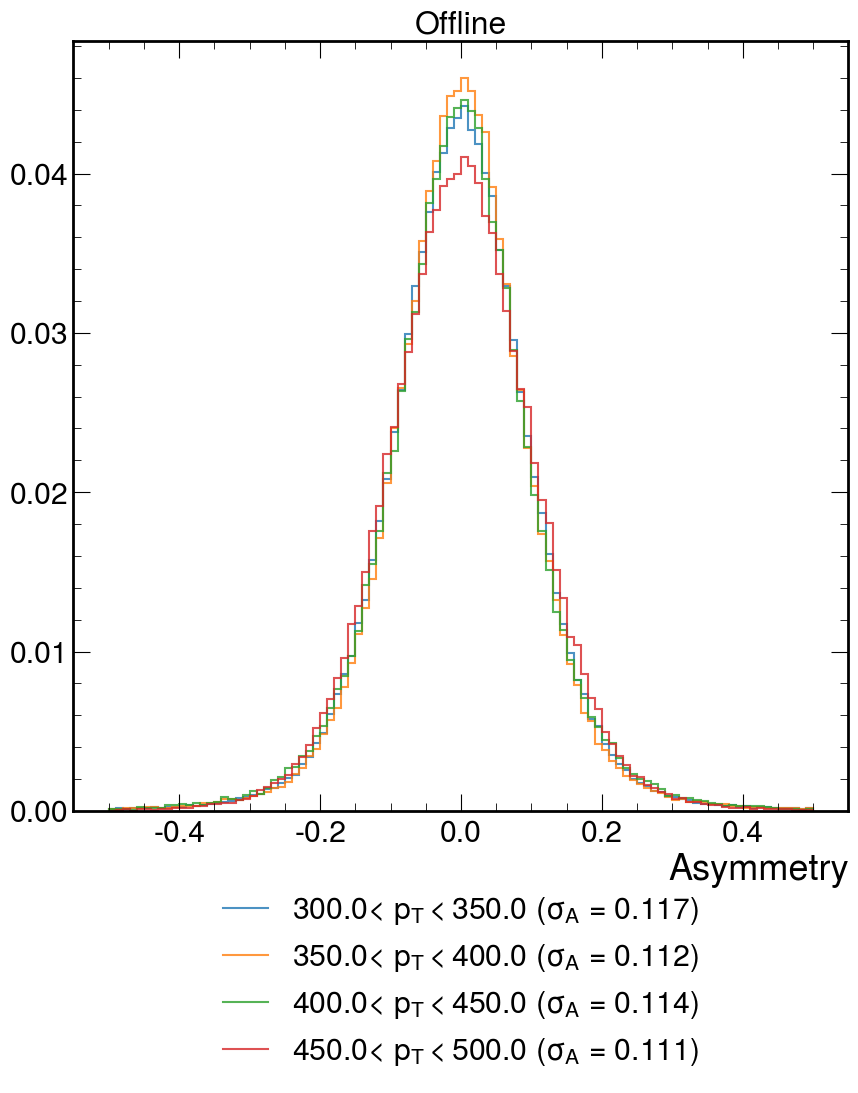

In [77]:
rec = "offline"

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

centers = output[rec].project("pt_ave").axes[0].centers
edges = output[rec].project("pt_ave").axes[0].edges
        
fig, ax = plt.subplots(figsize=(10,10))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

row = 0
column = 0

h_mean = output[rec + "_mean"][{"dataset" : sum}]
res = err(h_mean)

for i in [12, 13, 14, 15]:

    h = output[rec][{"dataset" : sum, "pt_ave" : i}]
    h_mean = output[rec + "_mean"][{"dataset" : sum, "pt_ave" : i}]
    h *= 1 / h.sum() if h.sum() != 0 else 1

    data_opts = {
        "histtype" : "step",
        "yerr" : False,
        "alpha" : 0.8,
    }
    
    label = f"{edges[i]}" + r"< $p_T <$" + f"{edges[i+1]}" + r" ($\sigma_A$ = "+ f"{res[i]:.3f})"

    mplhep.histplot(h, ax=ax, label=label, **data_opts)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07), ncol=1)

    ax.set_title(rec.capitalize(), fontsize=23)
    ax.set_xlabel("Asymmetry")
    ax.set_ylabel("")

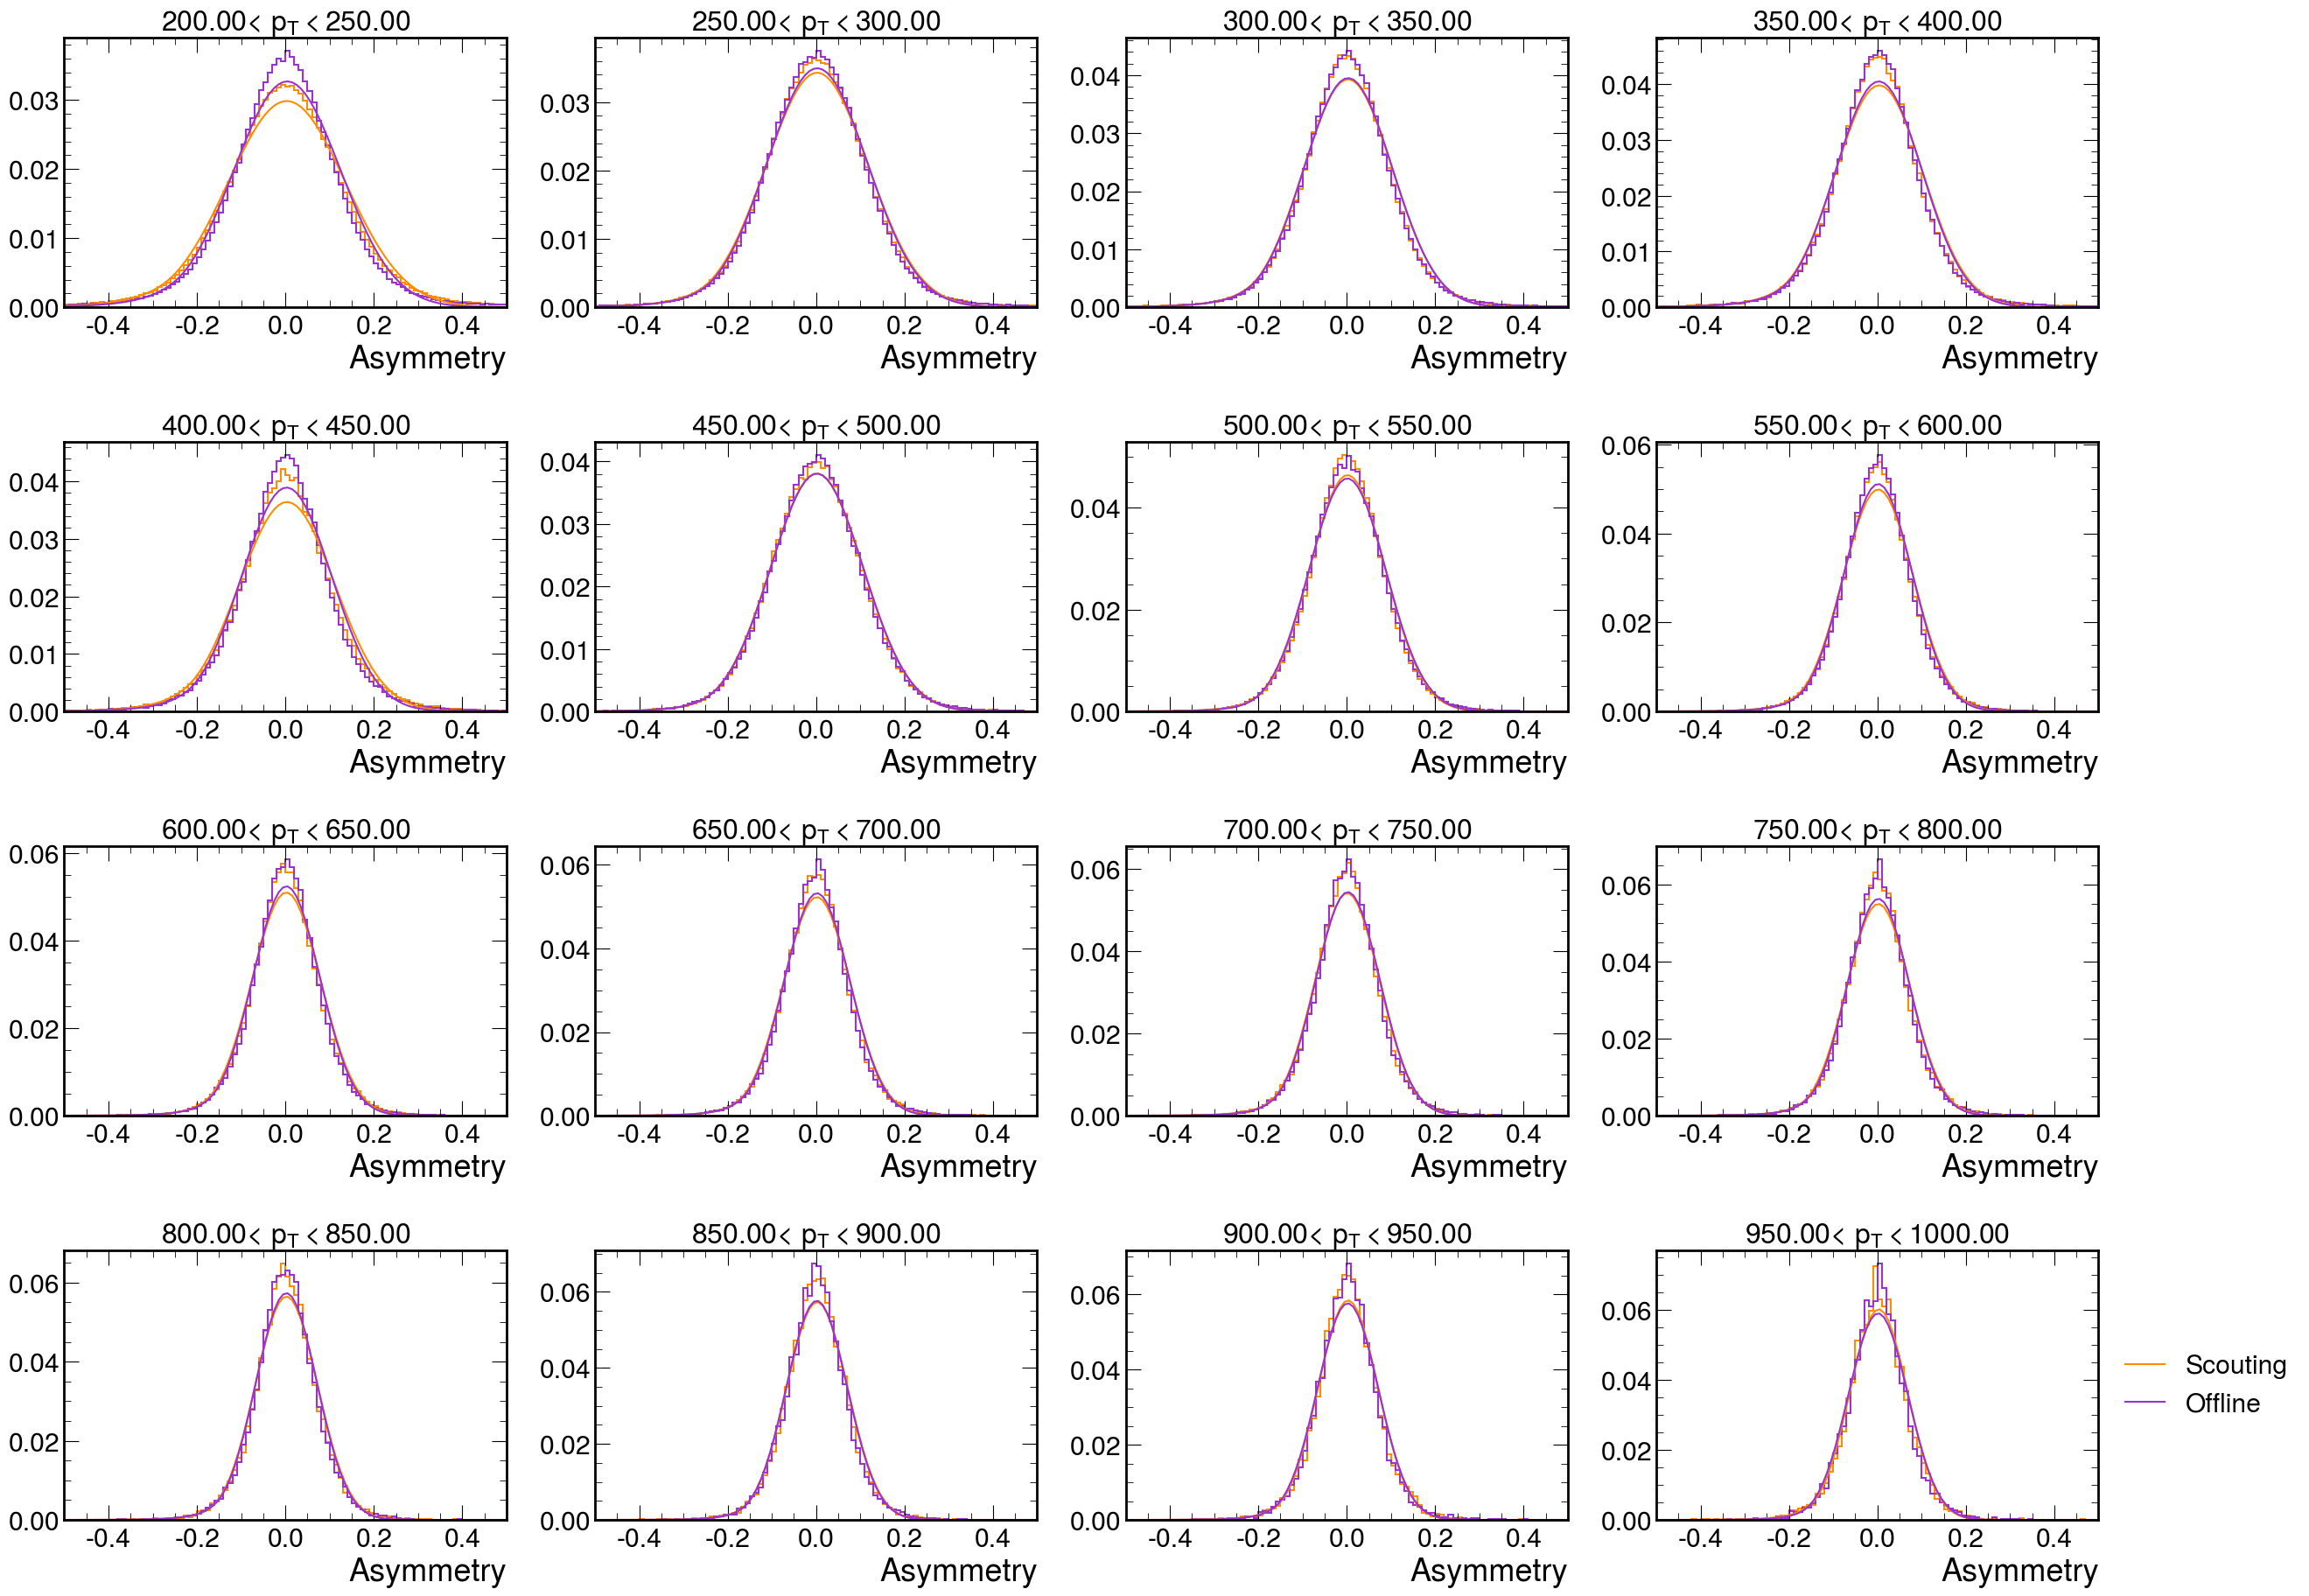

In [52]:
res = dict()
gauss = False

def crystalball_cdf(x, alpha, n, mean, sigma):
    return crystalball.cdf(x, alpha, n, mean, sigma)

def gauss_cdf(x, mean, sigma):
    return norm.cdf(x, mean, sigma)

def get_centers_edges(c):
    n = c._masked[..., 0] if c._bztrafo else c._masked
    ne = (c._masked[..., 1] if c._bztrafo else c._masked) ** 0.5
    xe = c.xe
    cx = 0.5 * (xe[1:] + xe[:-1])
    if c.mask is not None:
        cx = cx[c.mask]
        
    return cx, xe

def get_prediction(c, args):
    return c.prediction(args)

#fig, axs = plt.subplots(10, 2, figsize=(15,60))
fig, axs = plt.subplots(7, 4, figsize=(30,40))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

centers = output["scouting"].project("pt_ave").axes[0].centers
edges = output["scouting"].project("pt_ave").axes[0].edges
  
for era in ["C", "D", "E", "F", "G", ""]: 

    res[era] = {
        "scouting" : [],
        "offline" : []
    }
    
    row = 0
    column = 0
    
    for i, center in enumerate(centers):

        if centers[i] < 200:
            continue

        for rec in ["scouting", "offline"]:

            ax = axs[row, column]
            h = output[rec][{"dataset" : sum if not era else hist.loc("2022" + era), "pt_ave" : i}]
            h *= 1 / h.sum()
            _v = h.values()
            _c = h.axes[0].centers
            _e = h.axes[0].edges

            colour = "#FF8C00" if rec == "scouting" else "#9A32CD"

            if not gauss:
                # crystal ball
                c = cost.BinnedNLL(_v, _e, crystalball_cdf)
                m = Minuit(c, alpha=1, n=2, mean=0, sigma=0.3)
                sigma_i = 3
            else:
                # gauss
                c = cost.BinnedNLL(_v, _e, gauss_cdf)
                m = Minuit(c, mean=0, sigma=0.3)
                sigma_i = 1
            m.migrad()
            res[era][rec].append([m.values[sigma_i], m.errors[sigma_i]])

            cx, xe = get_centers_edges(c)
            mu = get_prediction(c, tuple(m.values))

            if not era:
                mplhep.histplot(h, ax=ax, color=colour)
                if i == (len(centers) - 1):
                    ax.plot(cx, mu, c=colour, label=rec.capitalize())
                    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                else:
                    ax.plot(cx, mu, c=colour)

        ax.set_title(f"{edges[i]:.2f}" + r"< $p_T <$" + f"{edges[i+1]:.2f}", fontsize=23)
        ax.set_xlabel("Asymmetry")
        ax.set_ylabel("")
        ax.set_xlim(-0.5, 0.5)

        column += 1
        if column > 3: # 1
            column = 0
            row += 1
        
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

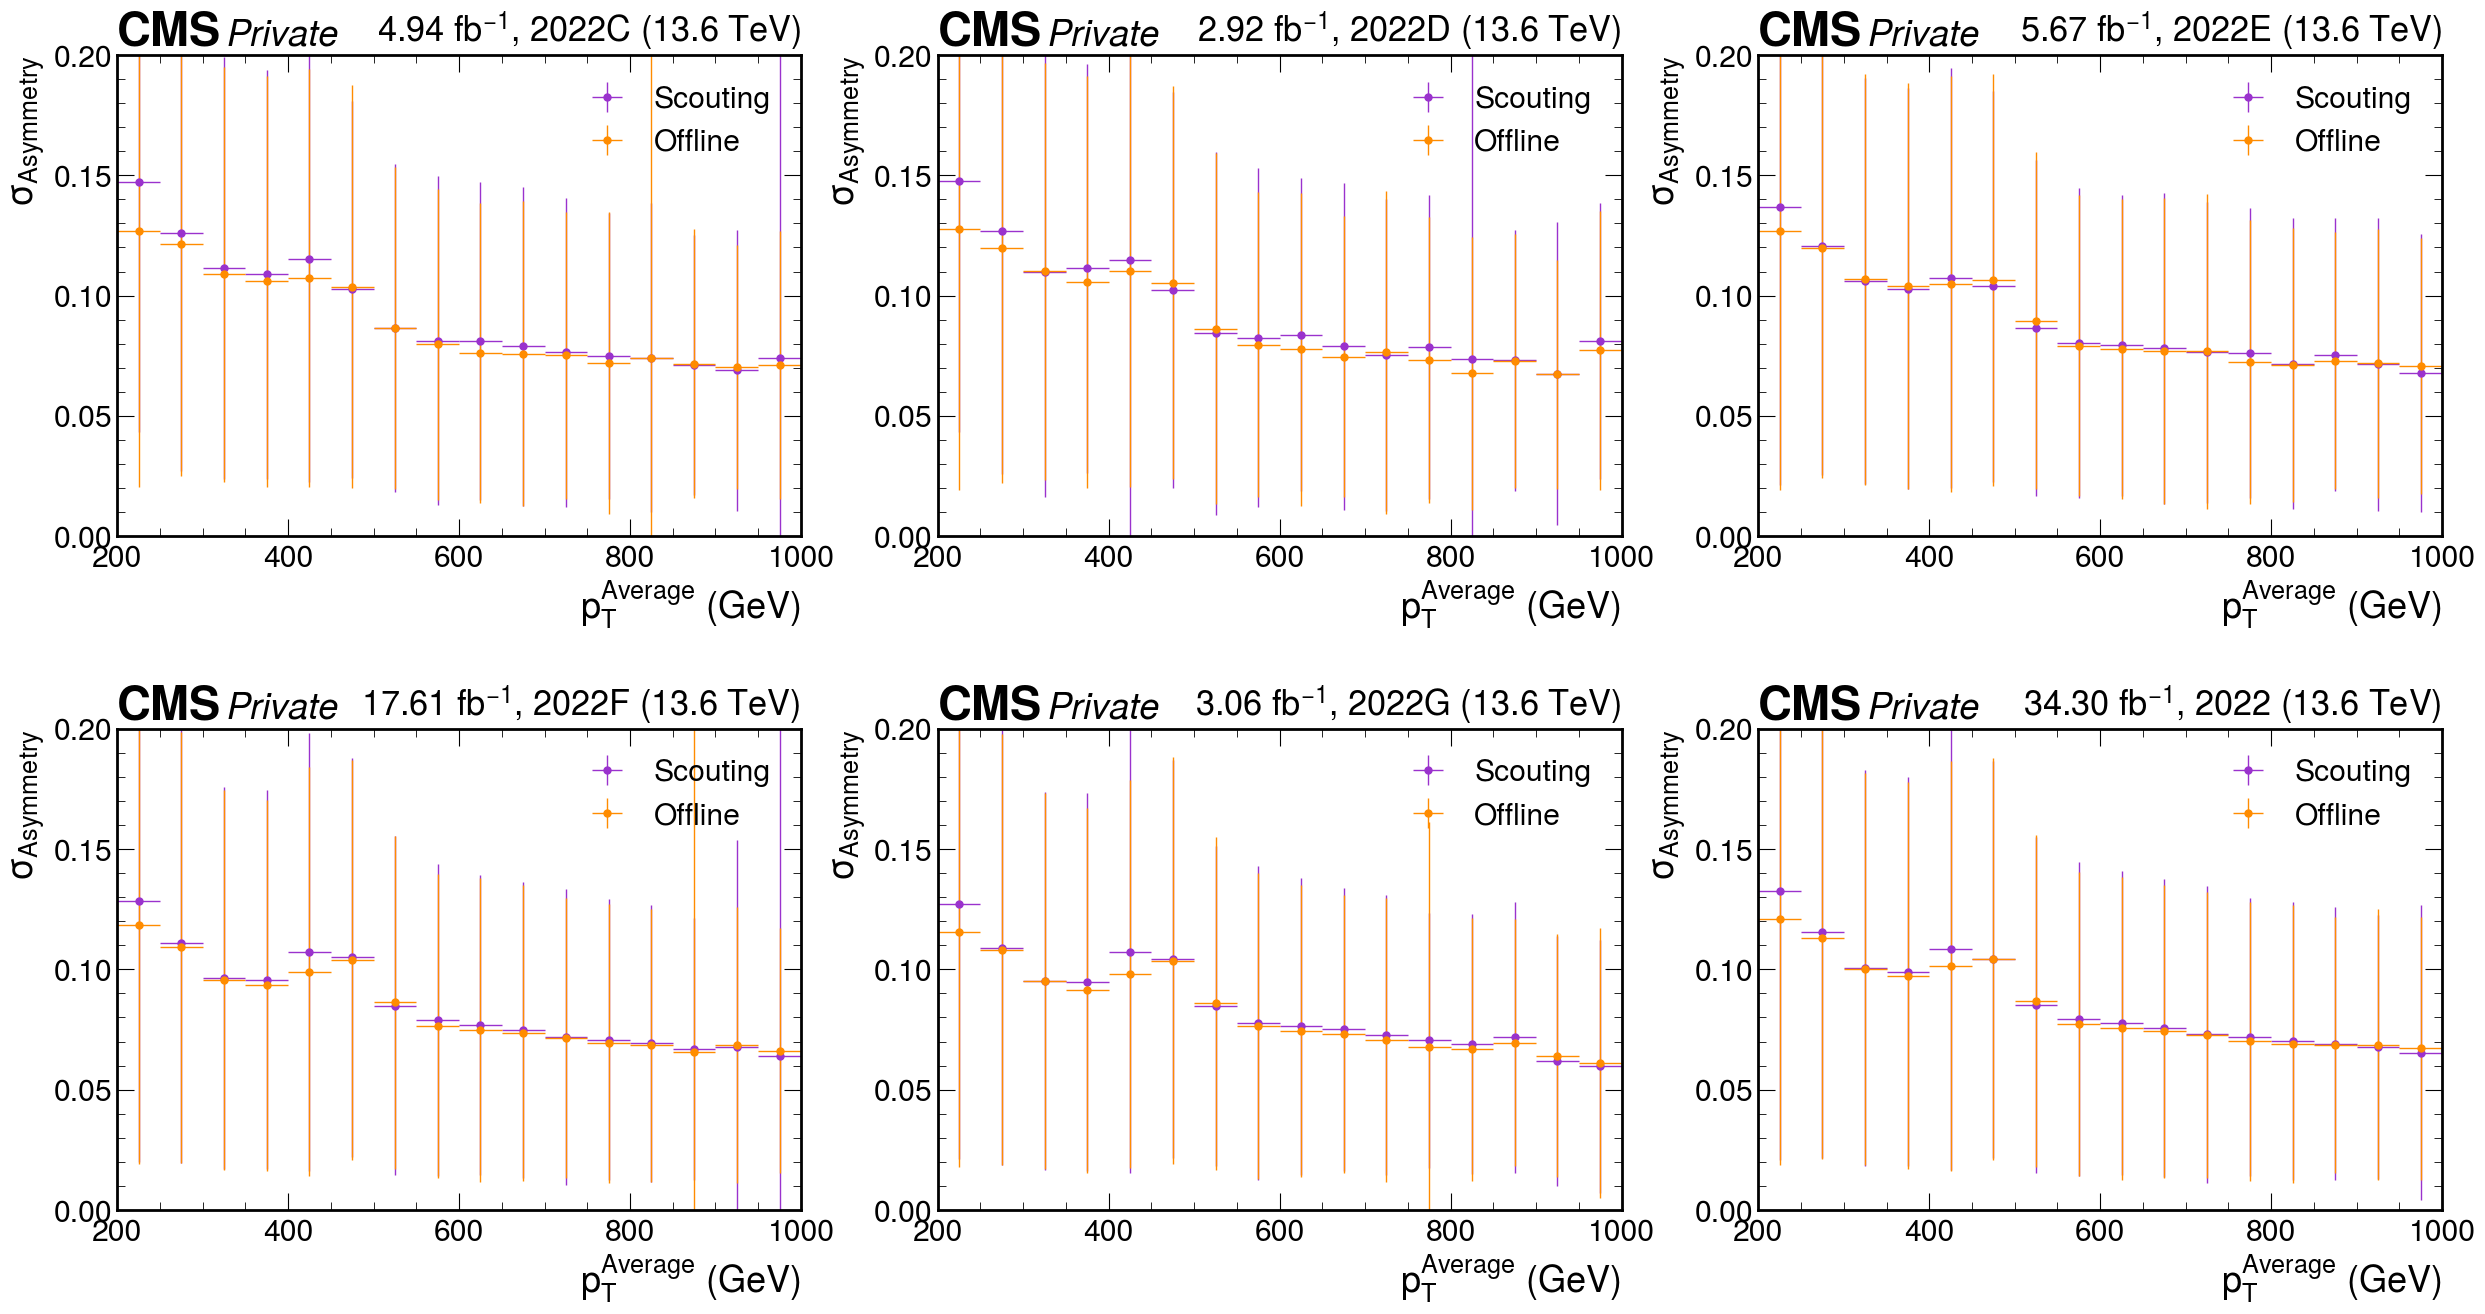

In [92]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

yerr_fit = True

def err_err(res, n):
    return 5 * res / np.sqrt(2 * (n - 1))

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]

    centers = output["scouting_mean"].project("pt_ave").axes[0].centers[10:]
    binwidth = centers[2] - centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }
    
    if yerr_fit:
        yerr_s = [r[1] for r in res[era]["scouting"]]
        yerr_o = [r[1] for r in res[era]["offline"]]
    else:
        n = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}].project("pt_ave").counts()[10:]
        yerr_s = err_err(
            np.array([r[0] for r in res[era]["scouting"]]),
            np.array(n)
        )
        n = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}].project("pt_ave").counts()[10:]
        yerr_o = err_err(
            np.array([r[0] for r in res[era]["offline"]]),
            np.array(n)
        )

    ax.errorbar(
        centers,
        [r[0] for r in res[era]["scouting"]],
        xerr=binwidth/2,
        yerr=yerr_s,
        **data_err_opts,
        color="#9A32CD",
        label="Scouting"
    )

    ax.errorbar(
        centers,
        [r[0] for r in res[era]["offline"]],
        xerr=binwidth/2,
        yerr=yerr_o,
        **data_err_opts,
        color="#FF8C00",
        label="Offline"
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_{Asymmetry}$")
    ax.legend(loc="best")
    ax.set_ylim(0, 0.2)
    ax.set_xlim(200, 1000)
    
    column += 1
    if column > 2:
        column = 0
        row += 1

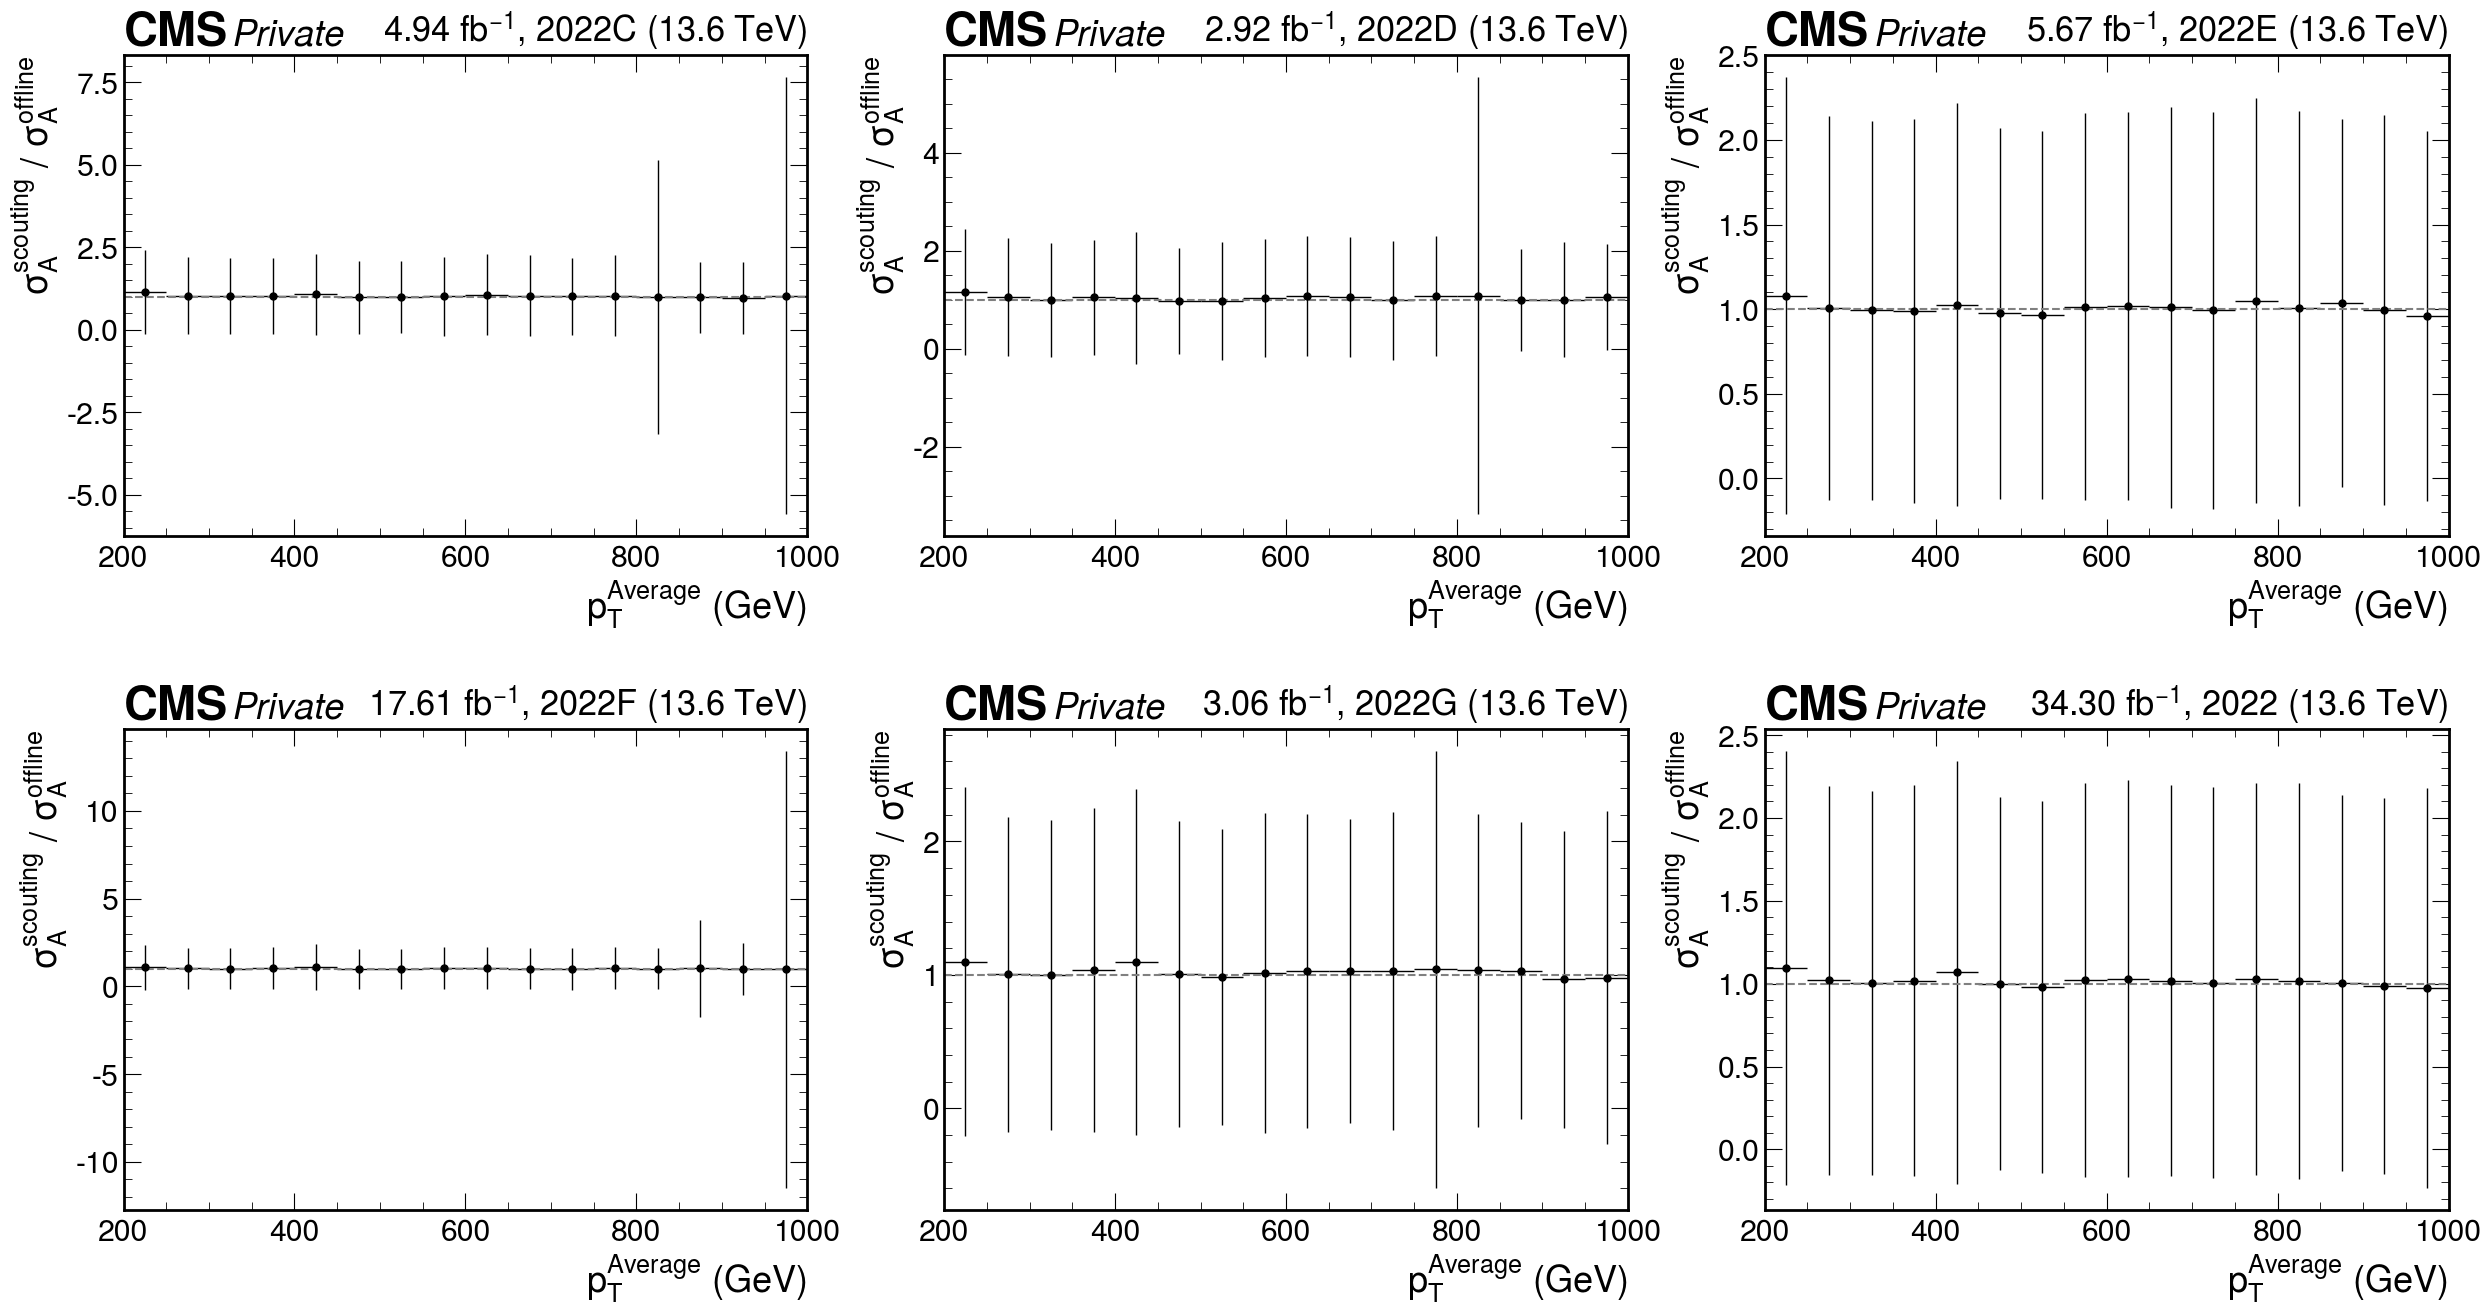

In [67]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

yerr_fit = True

def err_err(res, n):
    return 5 * res / np.sqrt(2 * (n - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
    
    return err

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]

    centers = [c for c in output["scouting_mean"].project("pt_ave").axes[0].centers if c > 200]
    binwidth = centers[2] - centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }
    
    if yerr_fit:
        yerr = err_prop(
            np.array([r[0] for r in res[era]["scouting"]]),
            np.array([r[0] for r in res[era]["offline"]]),
            np.array([r[1] for r in res[era]["scouting"]]),
            np.array([r[1] for r in res[era]["offline"]]),
        )
    else:
        n = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}].project("pt_ave").counts()[10:]
        err_s = err_err(
            np.array([r[0] for r in res[era]["scouting"]]),
            np.array(n)
        )
        n = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}].project("pt_ave").counts()[10:]
        err_o = err_err(
            np.array([r[0] for r in res[era]["offline"]]),
            np.array(n)
        )
        yerr = err_prop(
            np.array([r[0] for r in res[era]["scouting"]]),
            np.array([r[0] for r in res[era]["offline"]]),
            np.array(err_s),
            np.array(err_o),
        )

    ax.errorbar(
        centers,
        np.array([r[0] for r in res[era]["scouting"]]) / np.array([r[0] for r in res[era]["offline"]]),
        xerr=binwidth/2,
        yerr=yerr,
        **data_err_opts,
        color="black",
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_A^{scouting}$ / $\sigma_A^{offline}$")
    ax.axhline(1, color='gray',ls='--')
    #ax.set_ylim(0.05, 0.175)
    ax.set_xlim(200, 1000)
    
    column += 1
    if column > 2:
        column = 0
        row += 1

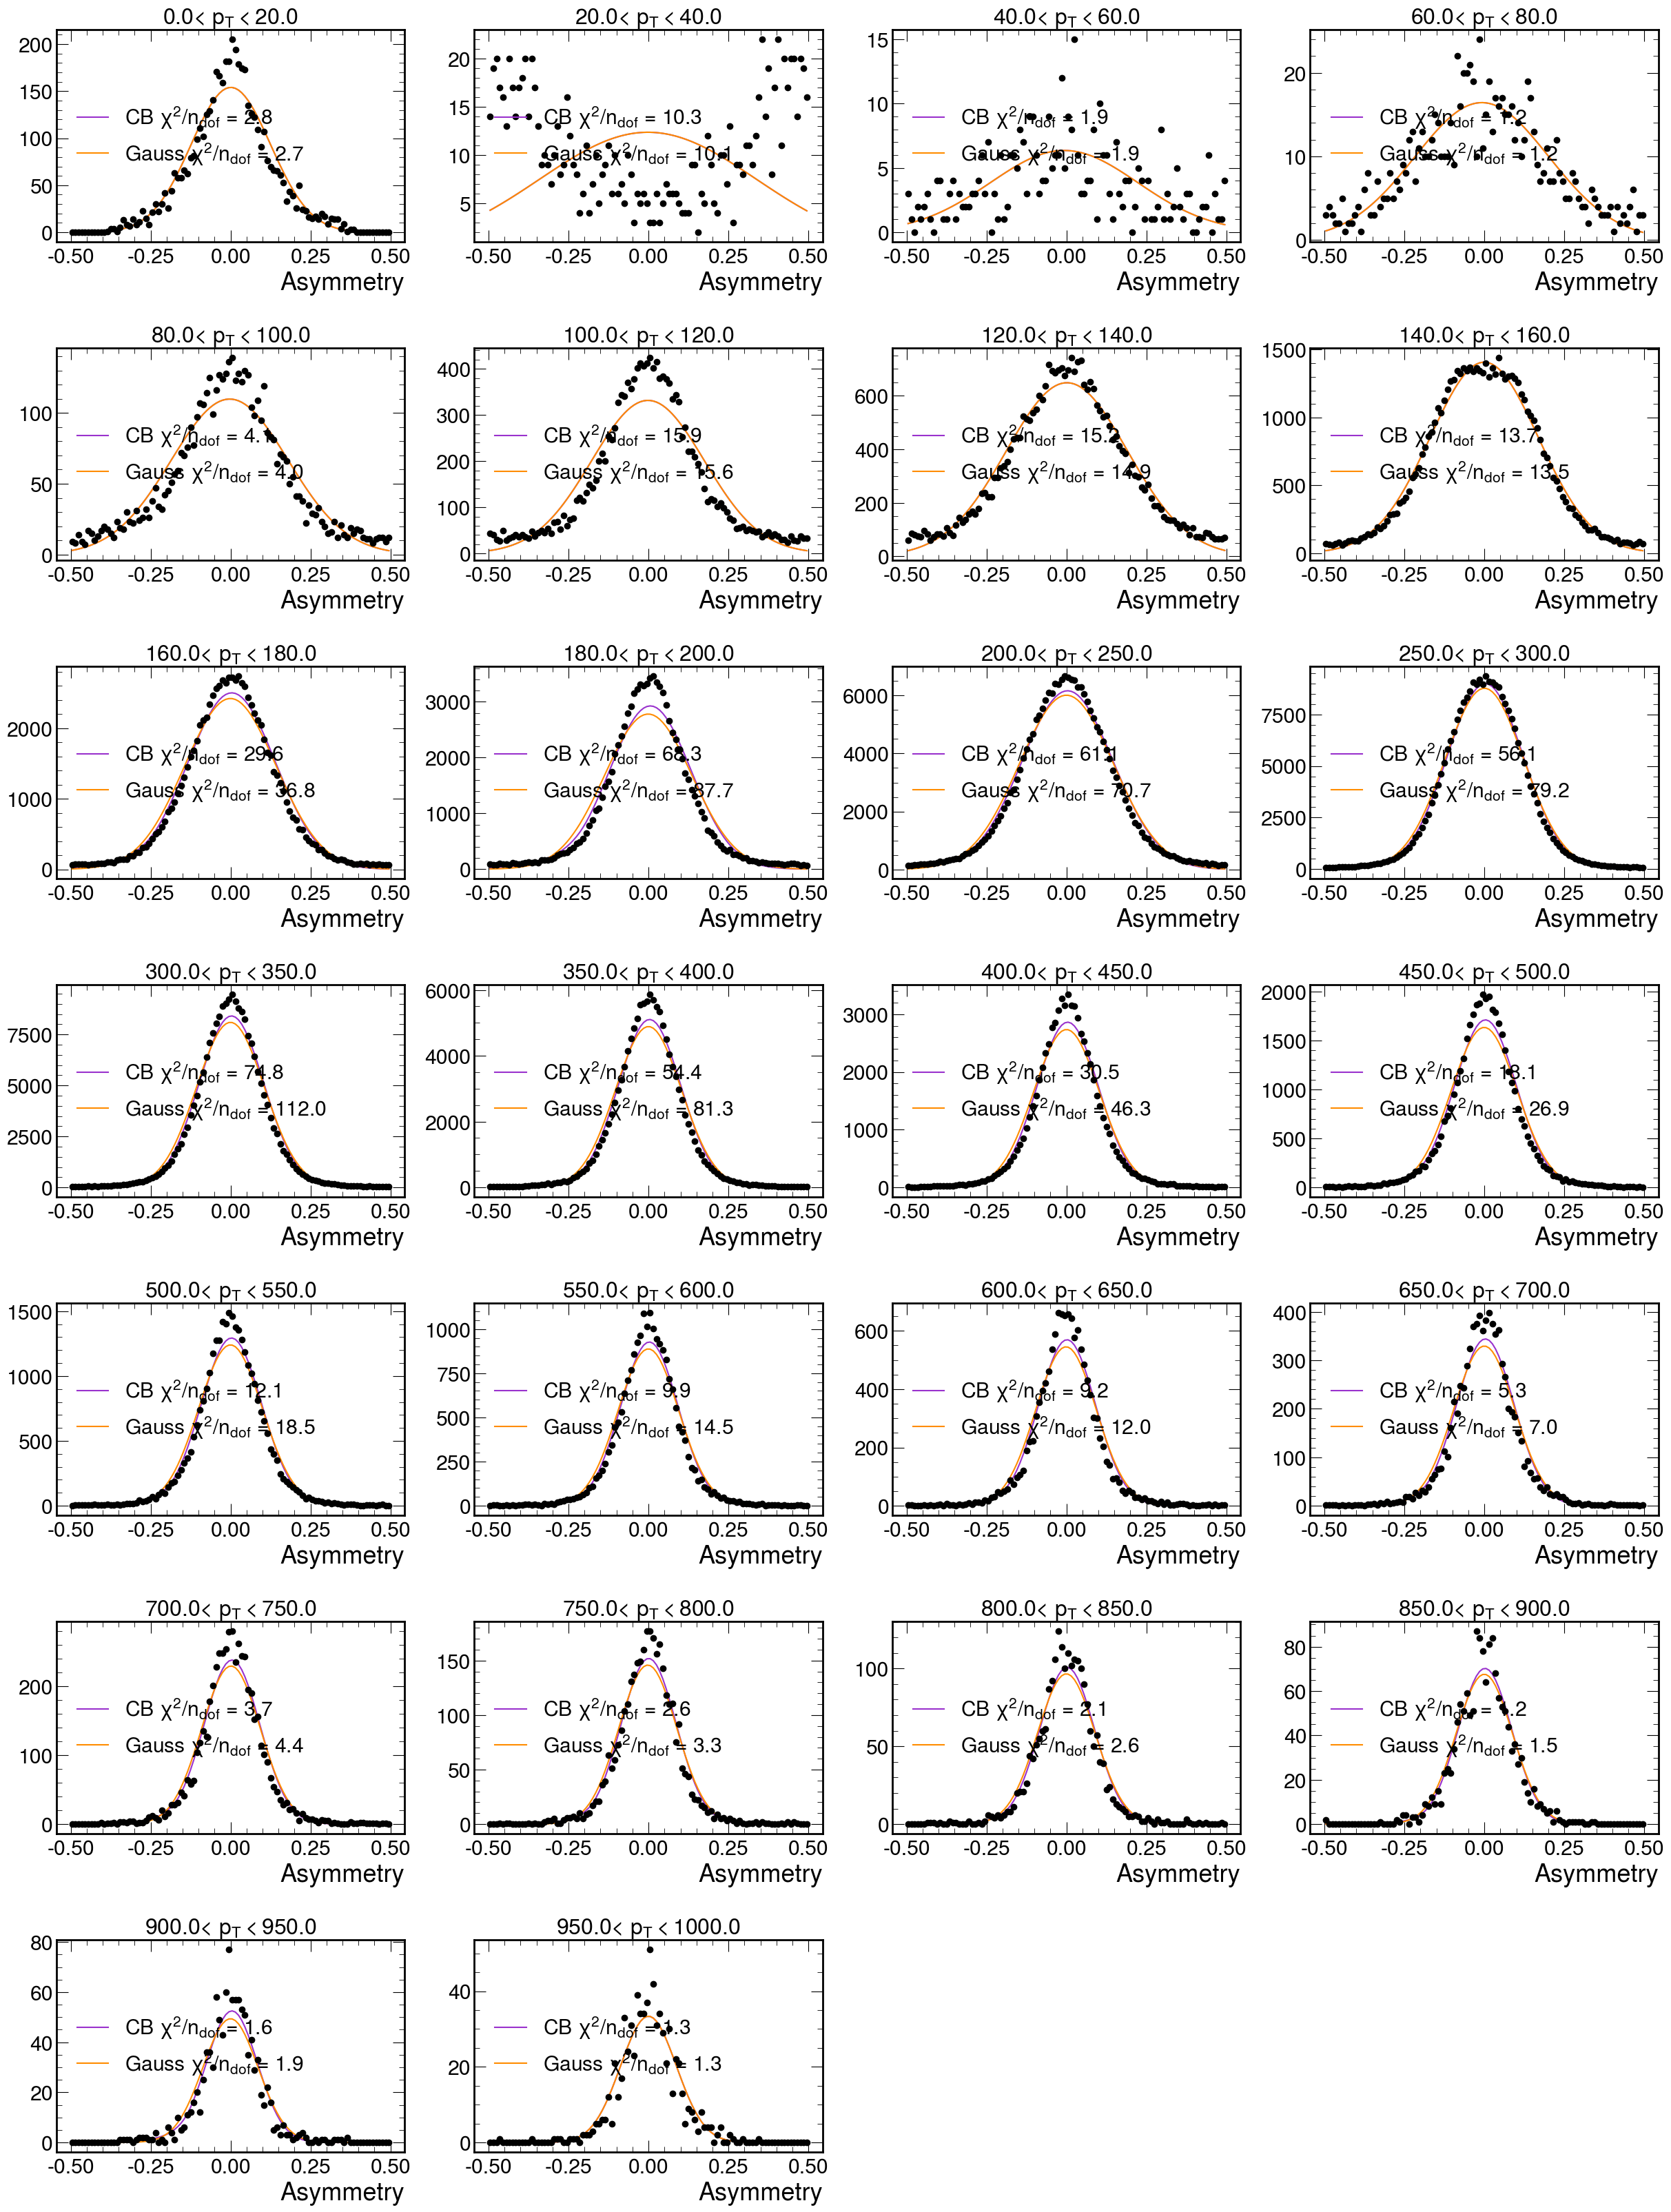

In [98]:
res_cb = []
res_gauss = []

def crystalball_cdf(x, alpha, n, mean, sigma):
    return crystalball.cdf(x, alpha, n, mean, sigma)

def gauss_cdf(x, mean, sigma):
    return norm.cdf(x, mean, sigma)

def get_centers_edges(c):
    n = c._masked[..., 0] if c._bztrafo else c._masked
    ne = (c._masked[..., 1] if c._bztrafo else c._masked) ** 0.5
    xe = c.xe
    cx = 0.5 * (xe[1:] + xe[:-1])
    if c.mask is not None:
        cx = cx[c.mask]
        
    return cx, xe

def get_prediction(c, args):
    return c.prediction(args)

output = util.load("outfiles/2022/jer_dijet_ScoutingPFMonitor_2022-CHS_nonhad.coffea")[0]

rec = "offline"
centers = output[rec].project("pt_ave").axes[0].centers
edges = output[rec].project("pt_ave").axes[0].edges

fig, axs = plt.subplots(7, 4, figsize=(30,40))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

row = 0
column = 0

for i, center in enumerate(centers):
    
    ax = axs[row, column]
    h = output[rec][{"dataset" : sum, "pt_ave" : i}]
    _v = h.values()
    _c = h.axes[0].centers
    _e = h.axes[0].edges
    
    ax.errorbar(_c, _v, fmt="ok")
    
    # crystal ball
    c = cost.BinnedNLL(_v, _e, crystalball_cdf)
    m = Minuit(c, alpha=1, n=2, mean=0, sigma=0.3)
    m.migrad()
    res_cb.append([m.values[3], m.errors[3]])
    fit_info = [f"CB $\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fmin.reduced_chi2:.1f}"]
#     for p, v, e in zip(m.parameters, m.values, m.errors):
#         fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    
    cx, xe = get_centers_edges(c)
    mu = get_prediction(c, tuple(m.values))
    ax.plot(cx, mu, c="#9A32CD", label="\n".join(fit_info),)
    
    # gauss
    c = cost.BinnedNLL(_v, _e, gauss_cdf)
    m = Minuit(c, mean=0, sigma=0.3)
    m.migrad()
    res_gauss.append([m.values[1], m.errors[1]])
    fit_info = [f"Gauss $\\chi^2$/$n_\\mathrm{{dof}}$ = {m.fmin.reduced_chi2:.1f}"]
#     for p, v, e in zip(m.parameters, m.values, m.errors):
#         fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    
    cx, xe = get_centers_edges(c)
    mu = get_prediction(c, tuple(m.values))
    ax.plot(cx, mu, c="#FF8C00", label="\n".join(fit_info),)
    
    ax.legend(loc='center left') 
    ax.set_title(f"{edges[i]}" + r"< $p_T <$" + f"{edges[i+1]}", fontsize=23)
    ax.set_xlabel("Asymmetry")
    ax.set_ylabel("")
    
    column += 1
    if column > 3:
        column = 0
        row += 1
        
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))        

for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

(200.0, 1000.0)

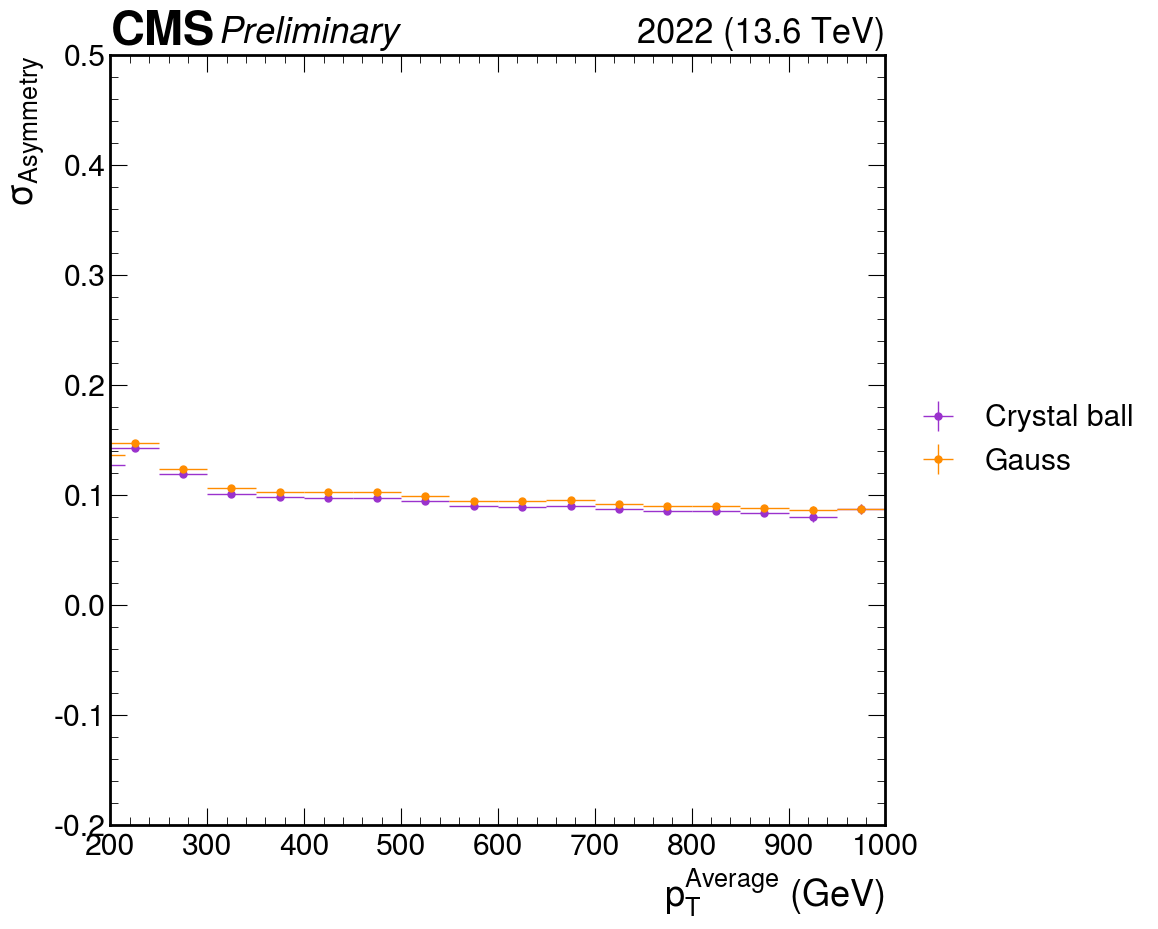

In [99]:
def err_err(s, n):
    return s / np.sqrt(2 * (n - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)

fig, ax = plt.subplots()

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

binwidth = centers[-1] - centers[-2]

s = np.array([res[0] for res in res_cb])
serr = np.array([res[1] for res in res_cb])
n = np.array([output[rec][{"dataset" : sum, "pt_ave" : i}].sum() for i in range(len(centers))])
yerr = err_err(s, n)

ax.errorbar(
    centers,
    s,
    xerr=binwidth/2,
    yerr=yerr + serr,
    **data_err_opts,
    color="#9A32CD",
    label="Crystal ball"
)

s = np.array([res[0] for res in res_gauss])
serr = np.array([res[1] for res in res_gauss])
n = np.array([output[rec][{"dataset" : sum, "pt_ave" : i}].sum() for i in range(len(centers))])
yerr = err_err(s, n)

ax.errorbar(
    centers,
    [res[0] for res in res_gauss],
    xerr=binwidth/2,
    yerr=yerr + serr,
    **data_err_opts,
    color="#FF8C00",
    label="Gauss"
)

mplhep.cms.label(ax=ax, data=True, year="2022", com=13.6, label="Preliminary")
ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
ax.set_ylabel(r"$\sigma_{Asymmetry}$")
# ax.axhline(1, color='gray',ls='--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(-0.2, 0.5)
ax.set_xlim(200, 1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(200.0, 1000.0)

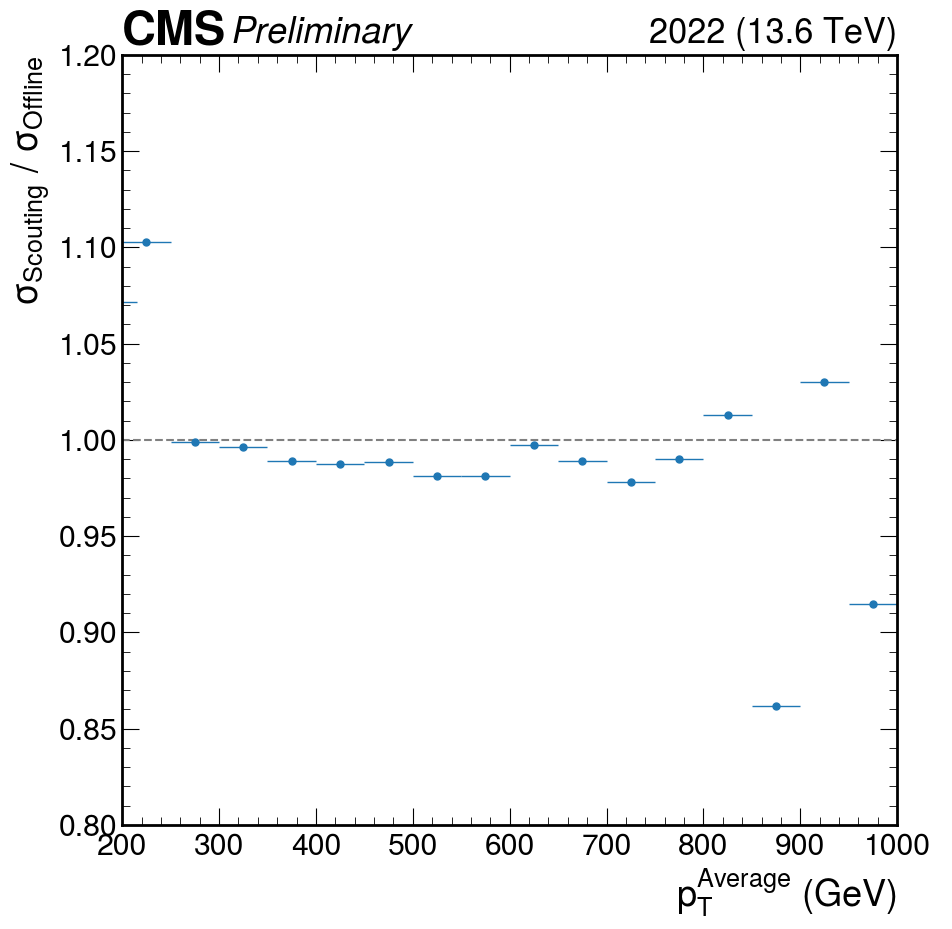

In [110]:
def err_err(s, n):
    return s / np.sqrt(2 * (n - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)

fig, ax = plt.subplots()

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

binwidth = centers[-1] - centers[-2]

s = np.array([res[0] for res in res_scouting])
o = np.array([res[0] for res in res_offline])
serr = np.array([res[1] for res in res_scouting])
oerr = np.array([res[1] for res in res_offline])
yerr=err_prop(s, o, serr, oerr)

ax.errorbar(
    centers,
    s / o,
    xerr=binwidth/2,
    yerr=yerr,
    **data_err_opts,
)


mplhep.cms.label(ax=ax, data=True, year="2022", com=13.6, label="Preliminary")
ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
ax.set_ylabel(r"$\sigma_{Scouting}$ / $\sigma_{Offline}$")
ax.axhline(1, color='gray',ls='--')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylim(0.8, 1.2)
ax.set_xlim(200, 1000)

In [2]:
output = util.load("outfiles/2022/jer_dijet_ScoutingPFMonitor_2022F-CHS_had.coffea")[0]

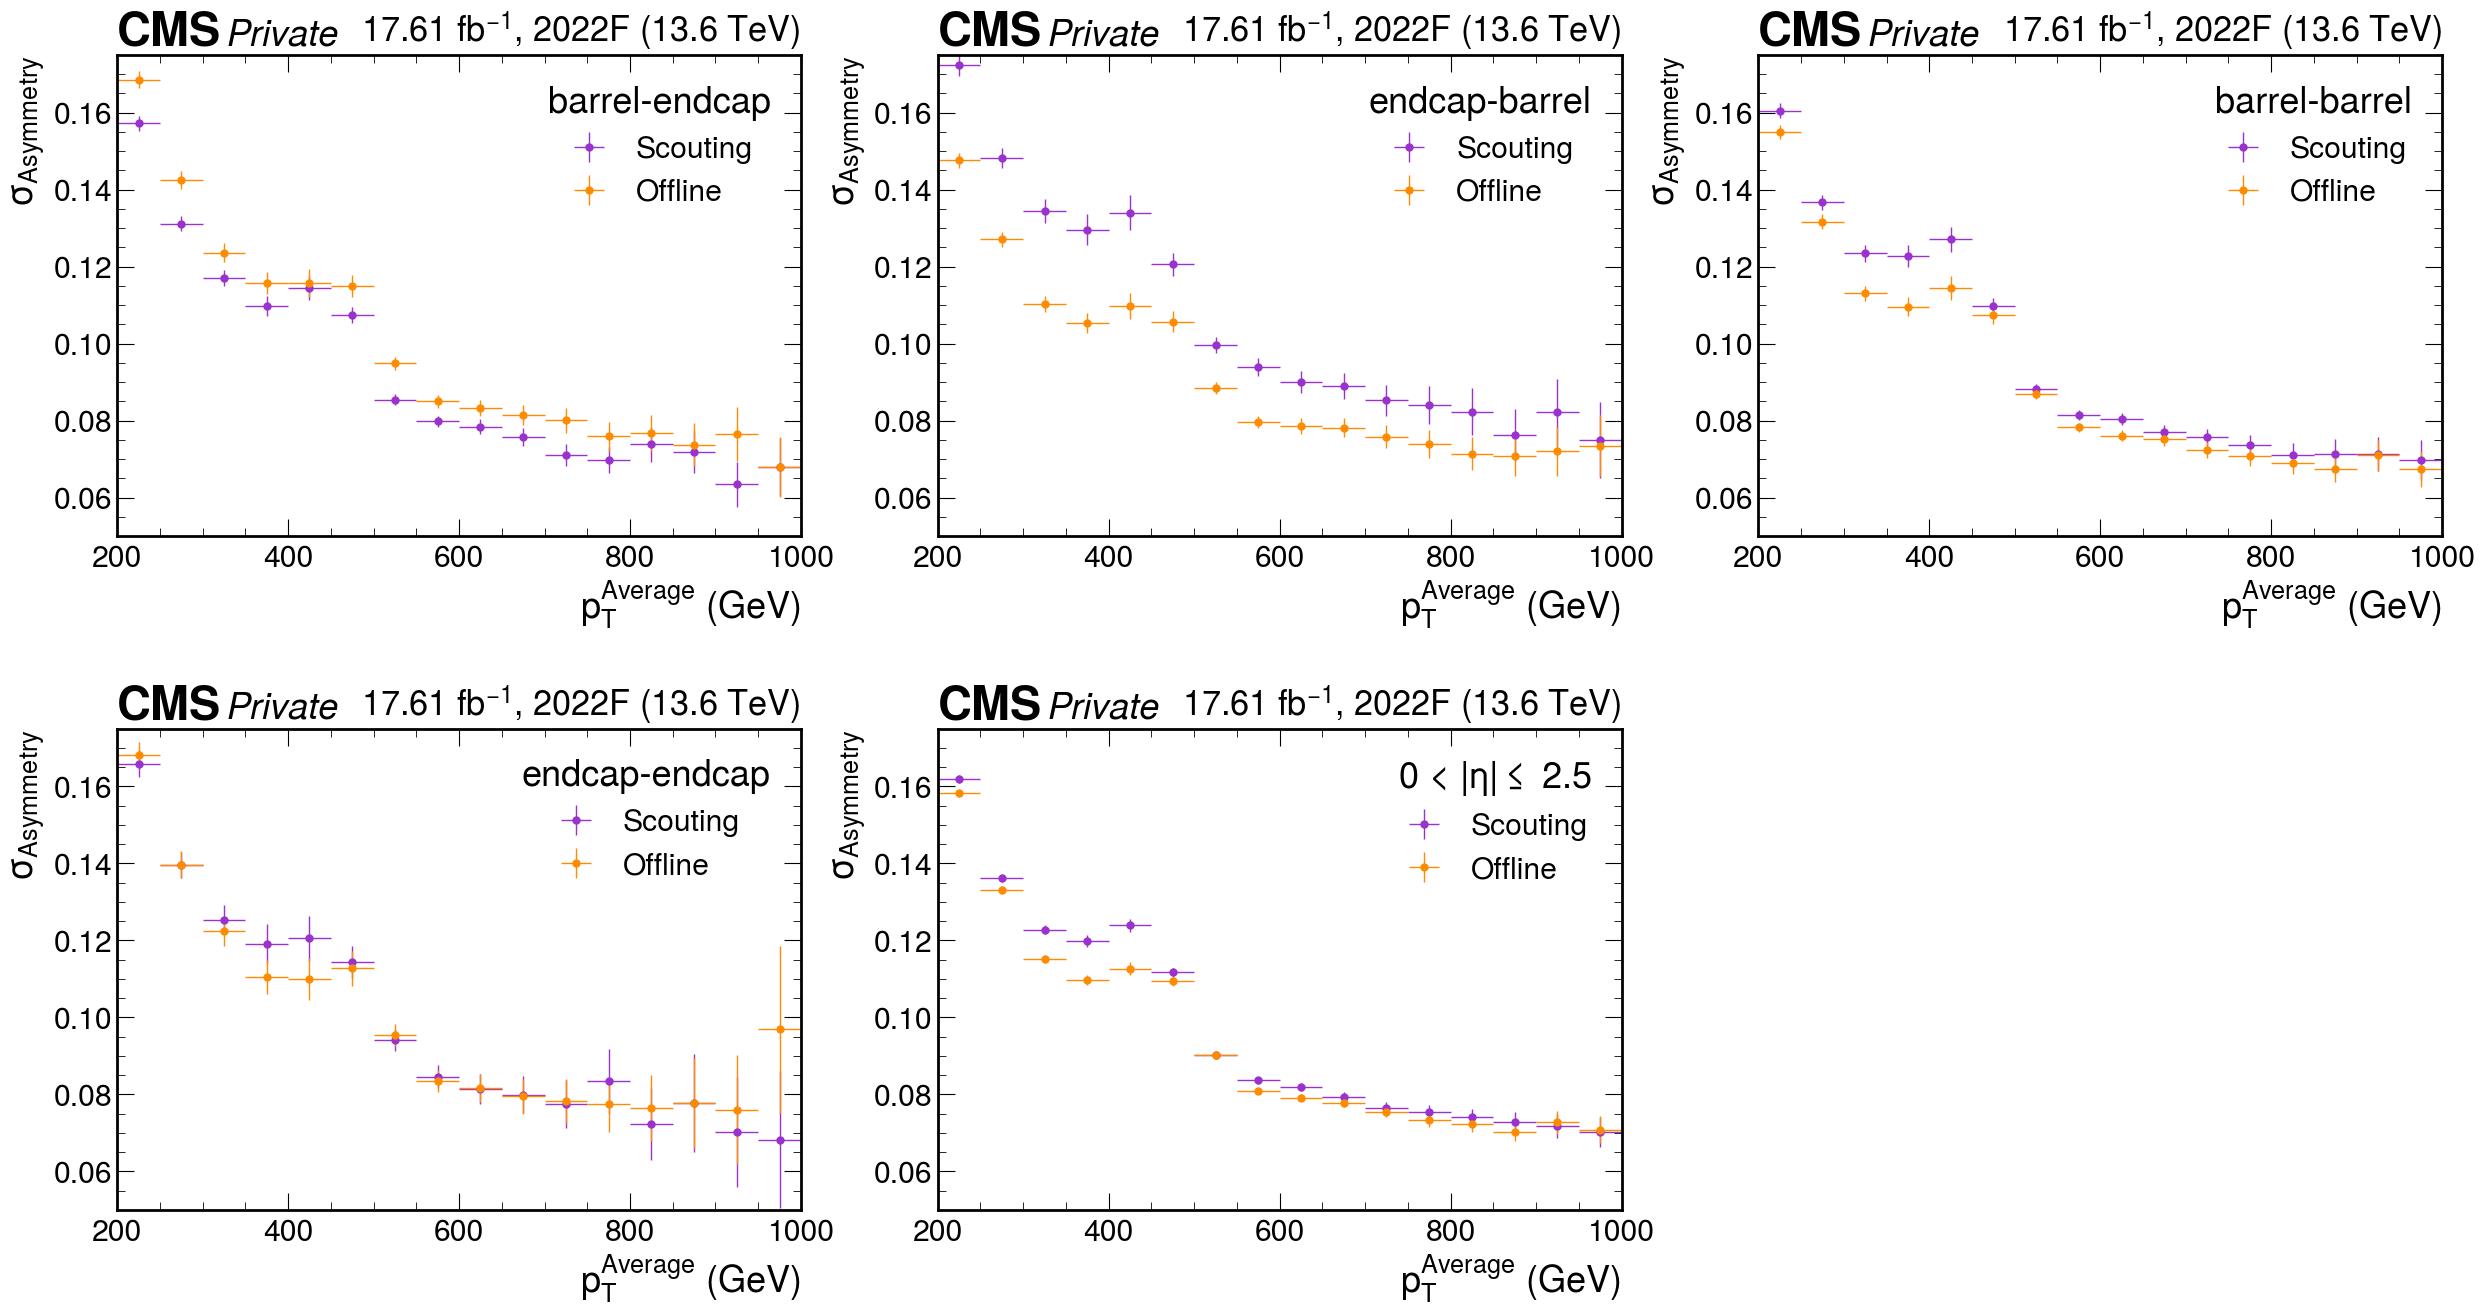

In [122]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

axes = output["scouting"].project("eta1").axes[0]

title = {
    (0, 1) : "barrel-endcap",
    (1, 0) : "endcap-barrel",
    (0, 0) : "barrel-barrel",
    (1, 1) : "endcap-endcap",
    (-1, -1) : r"0 < |$\eta|\leq$ 2.5",
}

for era in ["F"]:
    
    for i, j in [(0, 1), (1, 0), (0, 0), (1, 1), (-1, -1)]:
    
        ax = axs[row, column]

        h_s = output["scouting_mean"][:,::hist.rebin(2),::hist.rebin(2),:,:,:][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "eta1" : i if i >= 0 else sum,
                                      "eta2" : j if i >= 0 else sum,
                                      "phi1" : sum,
                                      "phi2" : sum,
                                      }]
        
        h_o = output["offline_mean"][:,::hist.rebin(2),::hist.rebin(2),:,:,:][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "eta1" : i if i >= 0 else sum,
                                      "eta2" : j if i >= 0 else sum,
                                      "phi1" : sum,
                                      "phi2" : sum,
                                     }]
        binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

        data_err_opts = {
                    'linestyle': 'none',
                    'marker': '.',
                    'markersize': 10.,
                    'elinewidth': 1,
                }
        
        if sum(h_s.counts()) == 0:
            continue

        ax.errorbar(
            h_s.axes[0].centers,
            err(h_s),
            xerr=binwidth/2,
            yerr=[err * 5 for err in err_err(h_s)],
            **data_err_opts,
            color="#9A32CD",
            label="Scouting"
        )

        ax.errorbar(
            h_o.axes[0].centers,
            err(h_o),
            xerr=binwidth/2,
            yerr=[err * 5 for err in err_err(h_o)],
            **data_err_opts,
            color="#FF8C00",
            label="Offline"
        )

        mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
        ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
        ax.set_ylabel(r"$\sigma_{Asymmetry}$")
        ax.axhline(0, color='gray',ls='--')
        ax.legend(loc="best", title=title[(i, j)])
        ax.set_ylim(0.05, 0.175)
        ax.set_xlim(200, 1000)

        column += 1
        if column > 2:
            column = 0
            row += 1
            
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

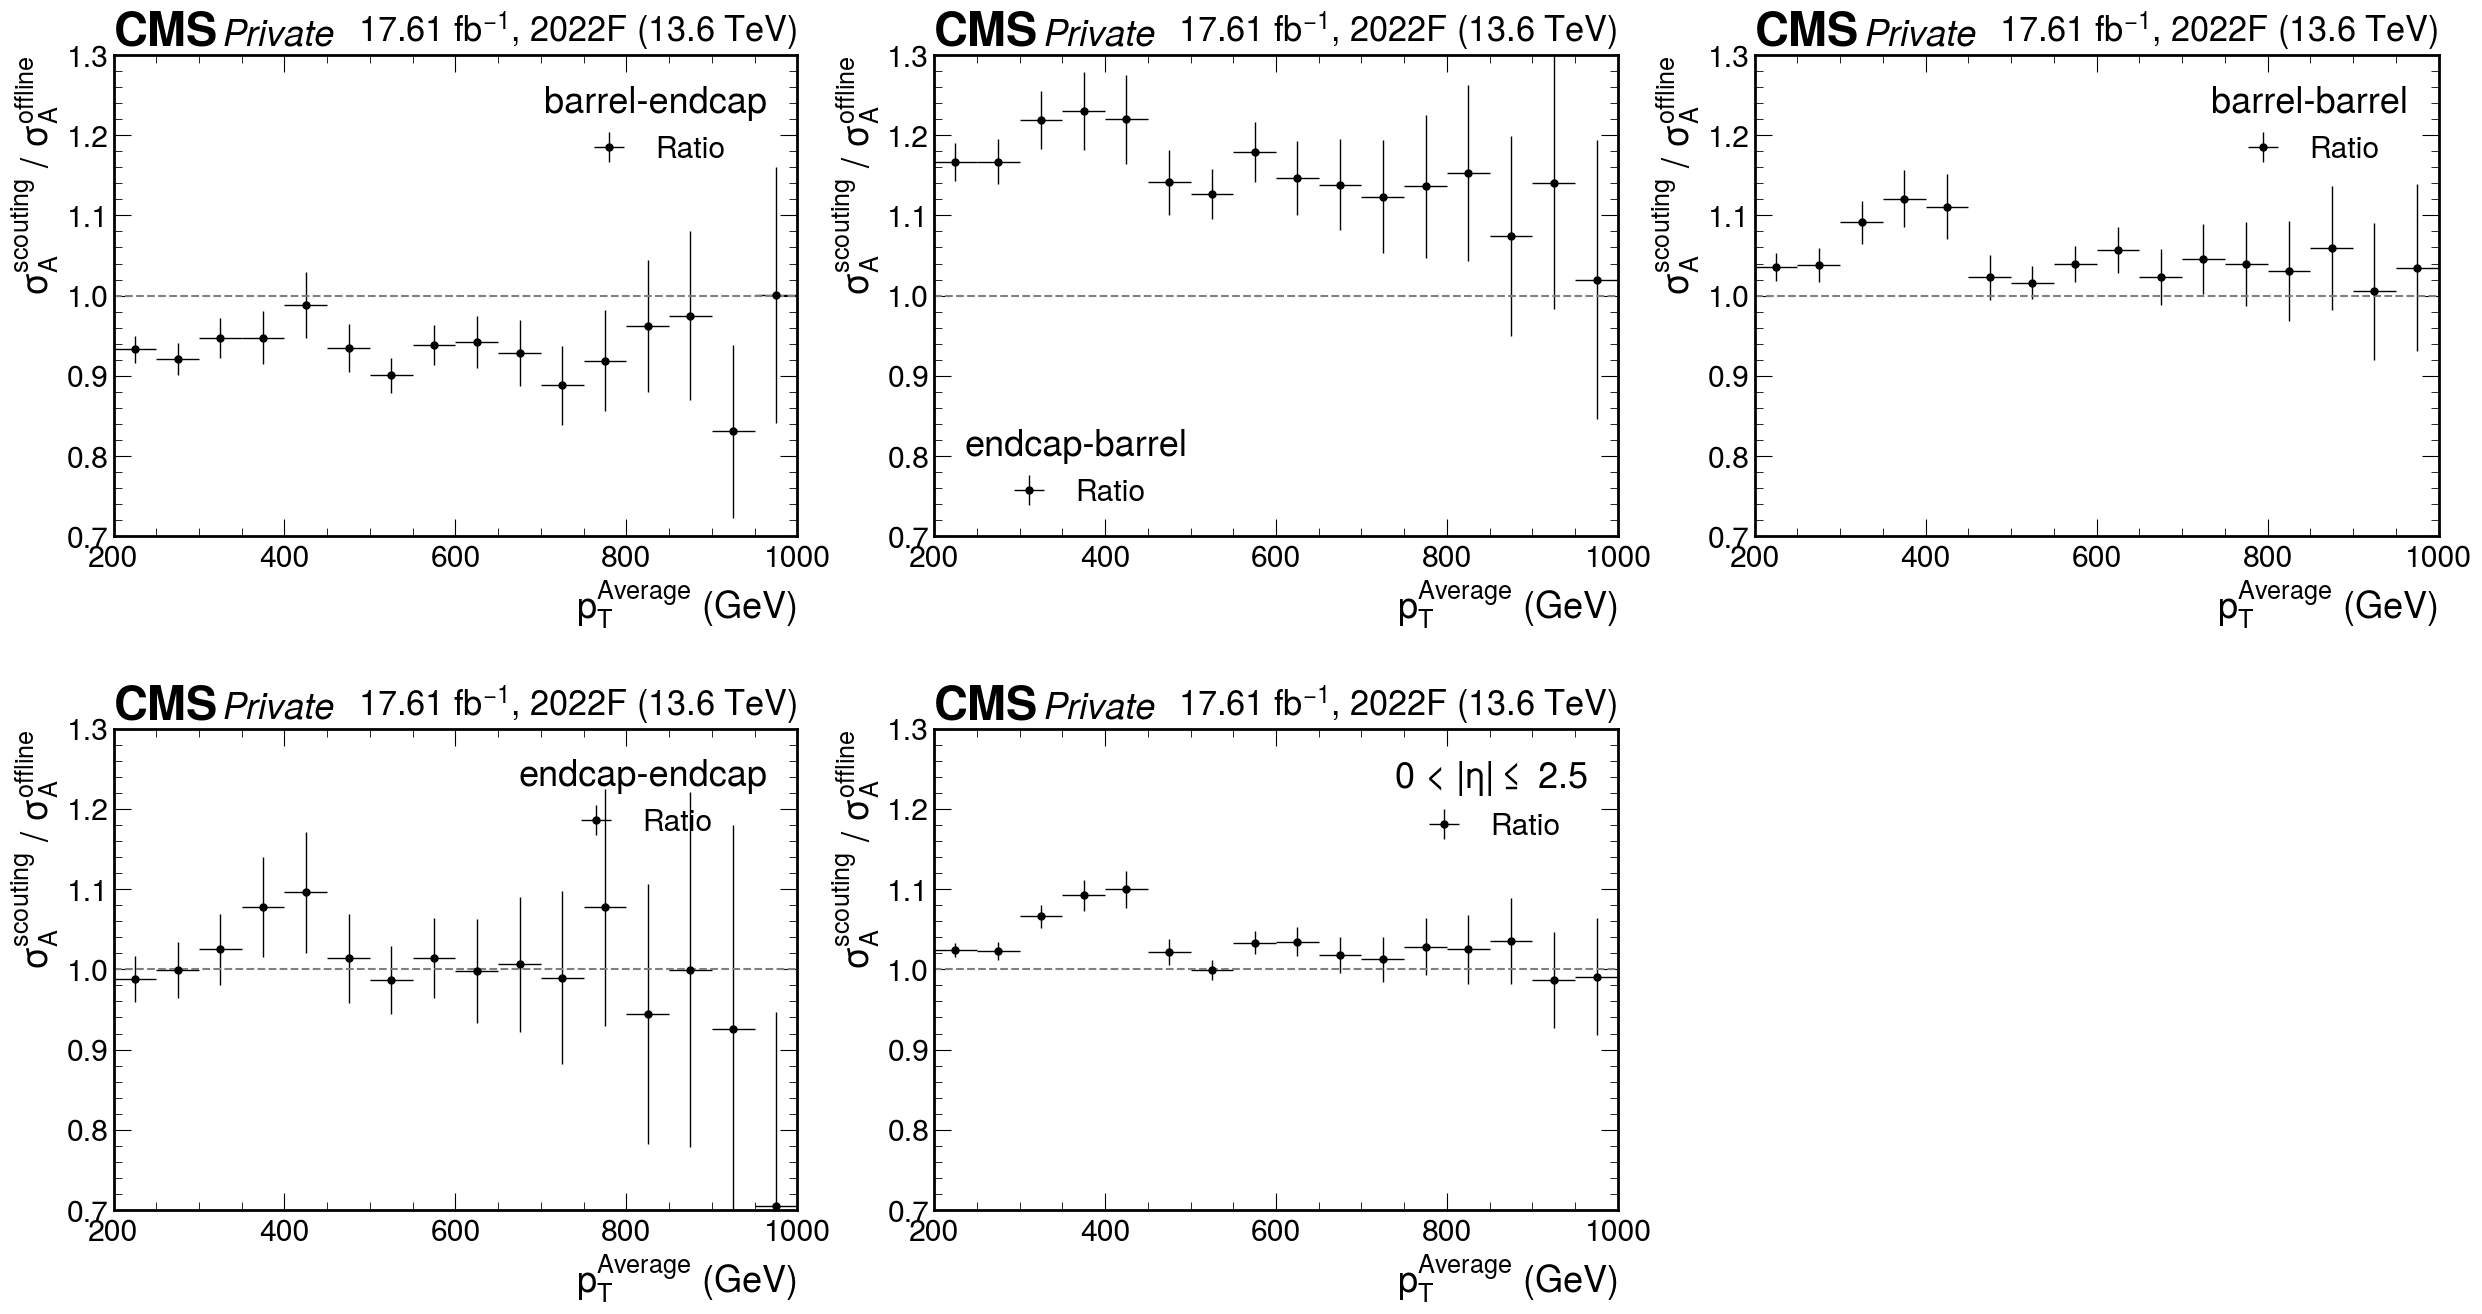

In [121]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
    
    return err

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

title = {
    (0, 1) : "barrel-endcap",
    (1, 0) : "endcap-barrel",
    (0, 0) : "barrel-barrel",
    (1, 1) : "endcap-endcap",
    (-1, -1) : r"0 < |$\eta| \leq$ 2.5",
}

axes = output["scouting"].project("eta1").axes[0]

for era in ["F"]:
    
    for i, j in [(0, 1), (1, 0), (0, 0), (1, 1), (-1, -1)]:
    
        ax = axs[row, column]

        h_s = output["scouting_mean"][:,::hist.rebin(2),::hist.rebin(2),:,:,:][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "eta1" : i if i >= 0 else sum,
                                      "eta2" : j if i >= 0 else sum,
                                      "phi1" : sum,
                                      "phi2" : sum,
                                      }]
        
        h_o = output["offline_mean"][:,::hist.rebin(2),::hist.rebin(2),:,:,:][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "eta1" : i if i >= 0 else sum,
                                      "eta2" : j if i >= 0 else sum,
                                      "phi1" : sum,
                                      "phi2" : sum,
                                     }]
        binwidth = h_s.axes[0].centers[-1] - h_s.axes[0].centers[-2]
        
        if sum(h_s.counts()) == 0:
            continue

        data_err_opts = {
                    'linestyle': 'none',
                    'marker': '.',
                    'markersize': 10.,
                    'elinewidth': 1,
                }

        ax.errorbar(
            h_s.axes[0].centers,
            err(h_s)/err(h_o),
            xerr=binwidth/2,
            yerr=[err * 5 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
            **data_err_opts,
            label="Ratio",
            color="black"
        )

        mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
        ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
        ax.set_ylabel(r"$\sigma_A^{scouting}$ / $\sigma_A^{offline}$")
        ax.axhline(1, color='gray',ls='--')
        ax.legend(loc="best", title=title[(i, j)])
        ax.set_ylim(0.7, 1.3)
        ax.set_xlim(200, 1000)

        column += 1
        if column > 2:
            column = 0
            row += 1
            
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

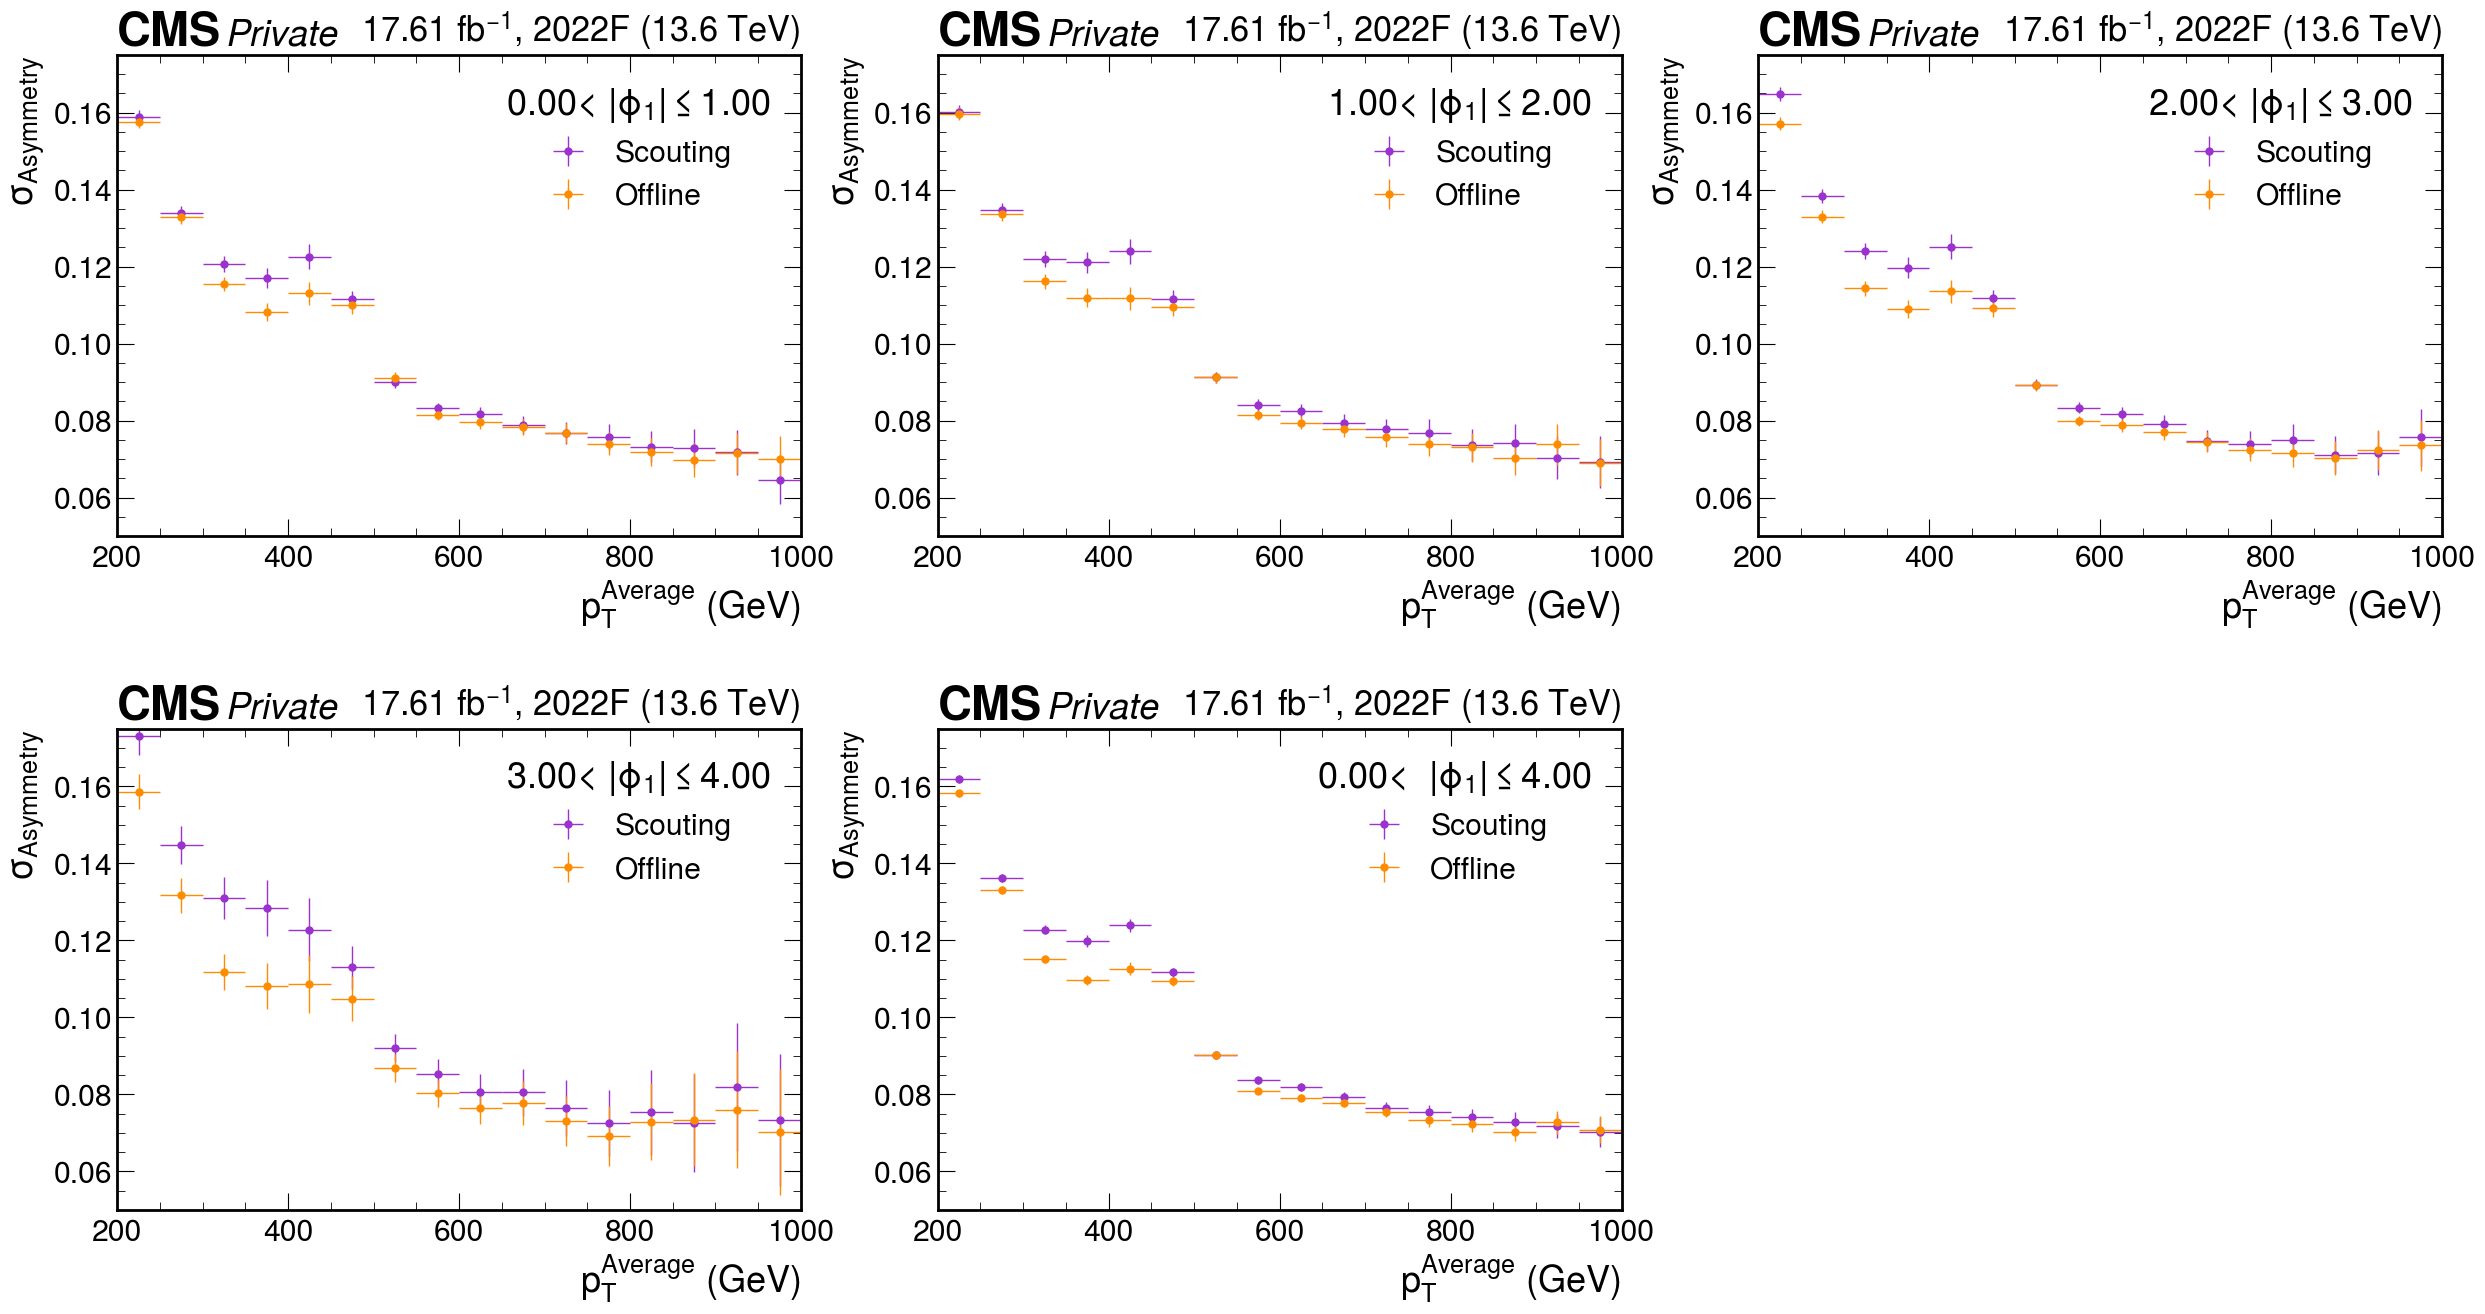

In [123]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

axes = output["scouting"].project("phi1").axes[0]

for era in ["F"]:
    
    for i, phi in enumerate(np.append(axes.centers, np.array(-1))):
    
        ax = axs[row, column]

        h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi1" : i if phi >= 0 else sum,
                                      "phi2" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                      }]
        
        h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi1" : i if phi >= 0 else sum,
                                      "phi2" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                     }]
        binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

        data_err_opts = {
                    'linestyle': 'none',
                    'marker': '.',
                    'markersize': 10.,
                    'elinewidth': 1,
                }
        
        if sum(h_s.counts()) == 0:
            continue

        ax.errorbar(
            h_s.axes[0].centers,
            err(h_s),
            xerr=binwidth/2,
            yerr=[err * 5 for err in err_err(h_s)],
            **data_err_opts,
            color="#9A32CD",
            label="Scouting"
        )

        ax.errorbar(
            h_o.axes[0].centers,
            err(h_o),
            xerr=binwidth/2,
            yerr=[err * 5 for err in err_err(h_o)],
            **data_err_opts,
            color="#FF8C00",
            label="Offline"
        )

        mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
        ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
        ax.set_ylabel(r"$\sigma_{Asymmetry}$")
        ax.axhline(0, color='gray',ls='--')
        title = f"{axes.edges[i]:.2f}" + r"< |$\phi_1| \leq$" + f"{axes.edges[i+1]:.2f}" if phi >= 0 else f"{axes.edges[0]:.2f}" + r"<  |$\phi_1| \leq$" + f"{axes.edges[-1]:.2f}"
        ax.legend(loc="best", title=title)
        ax.set_ylim(0.05, 0.175)
        ax.set_xlim(200, 1000)

        column += 1
        if column > 2:
            column = 0
            row += 1
            
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

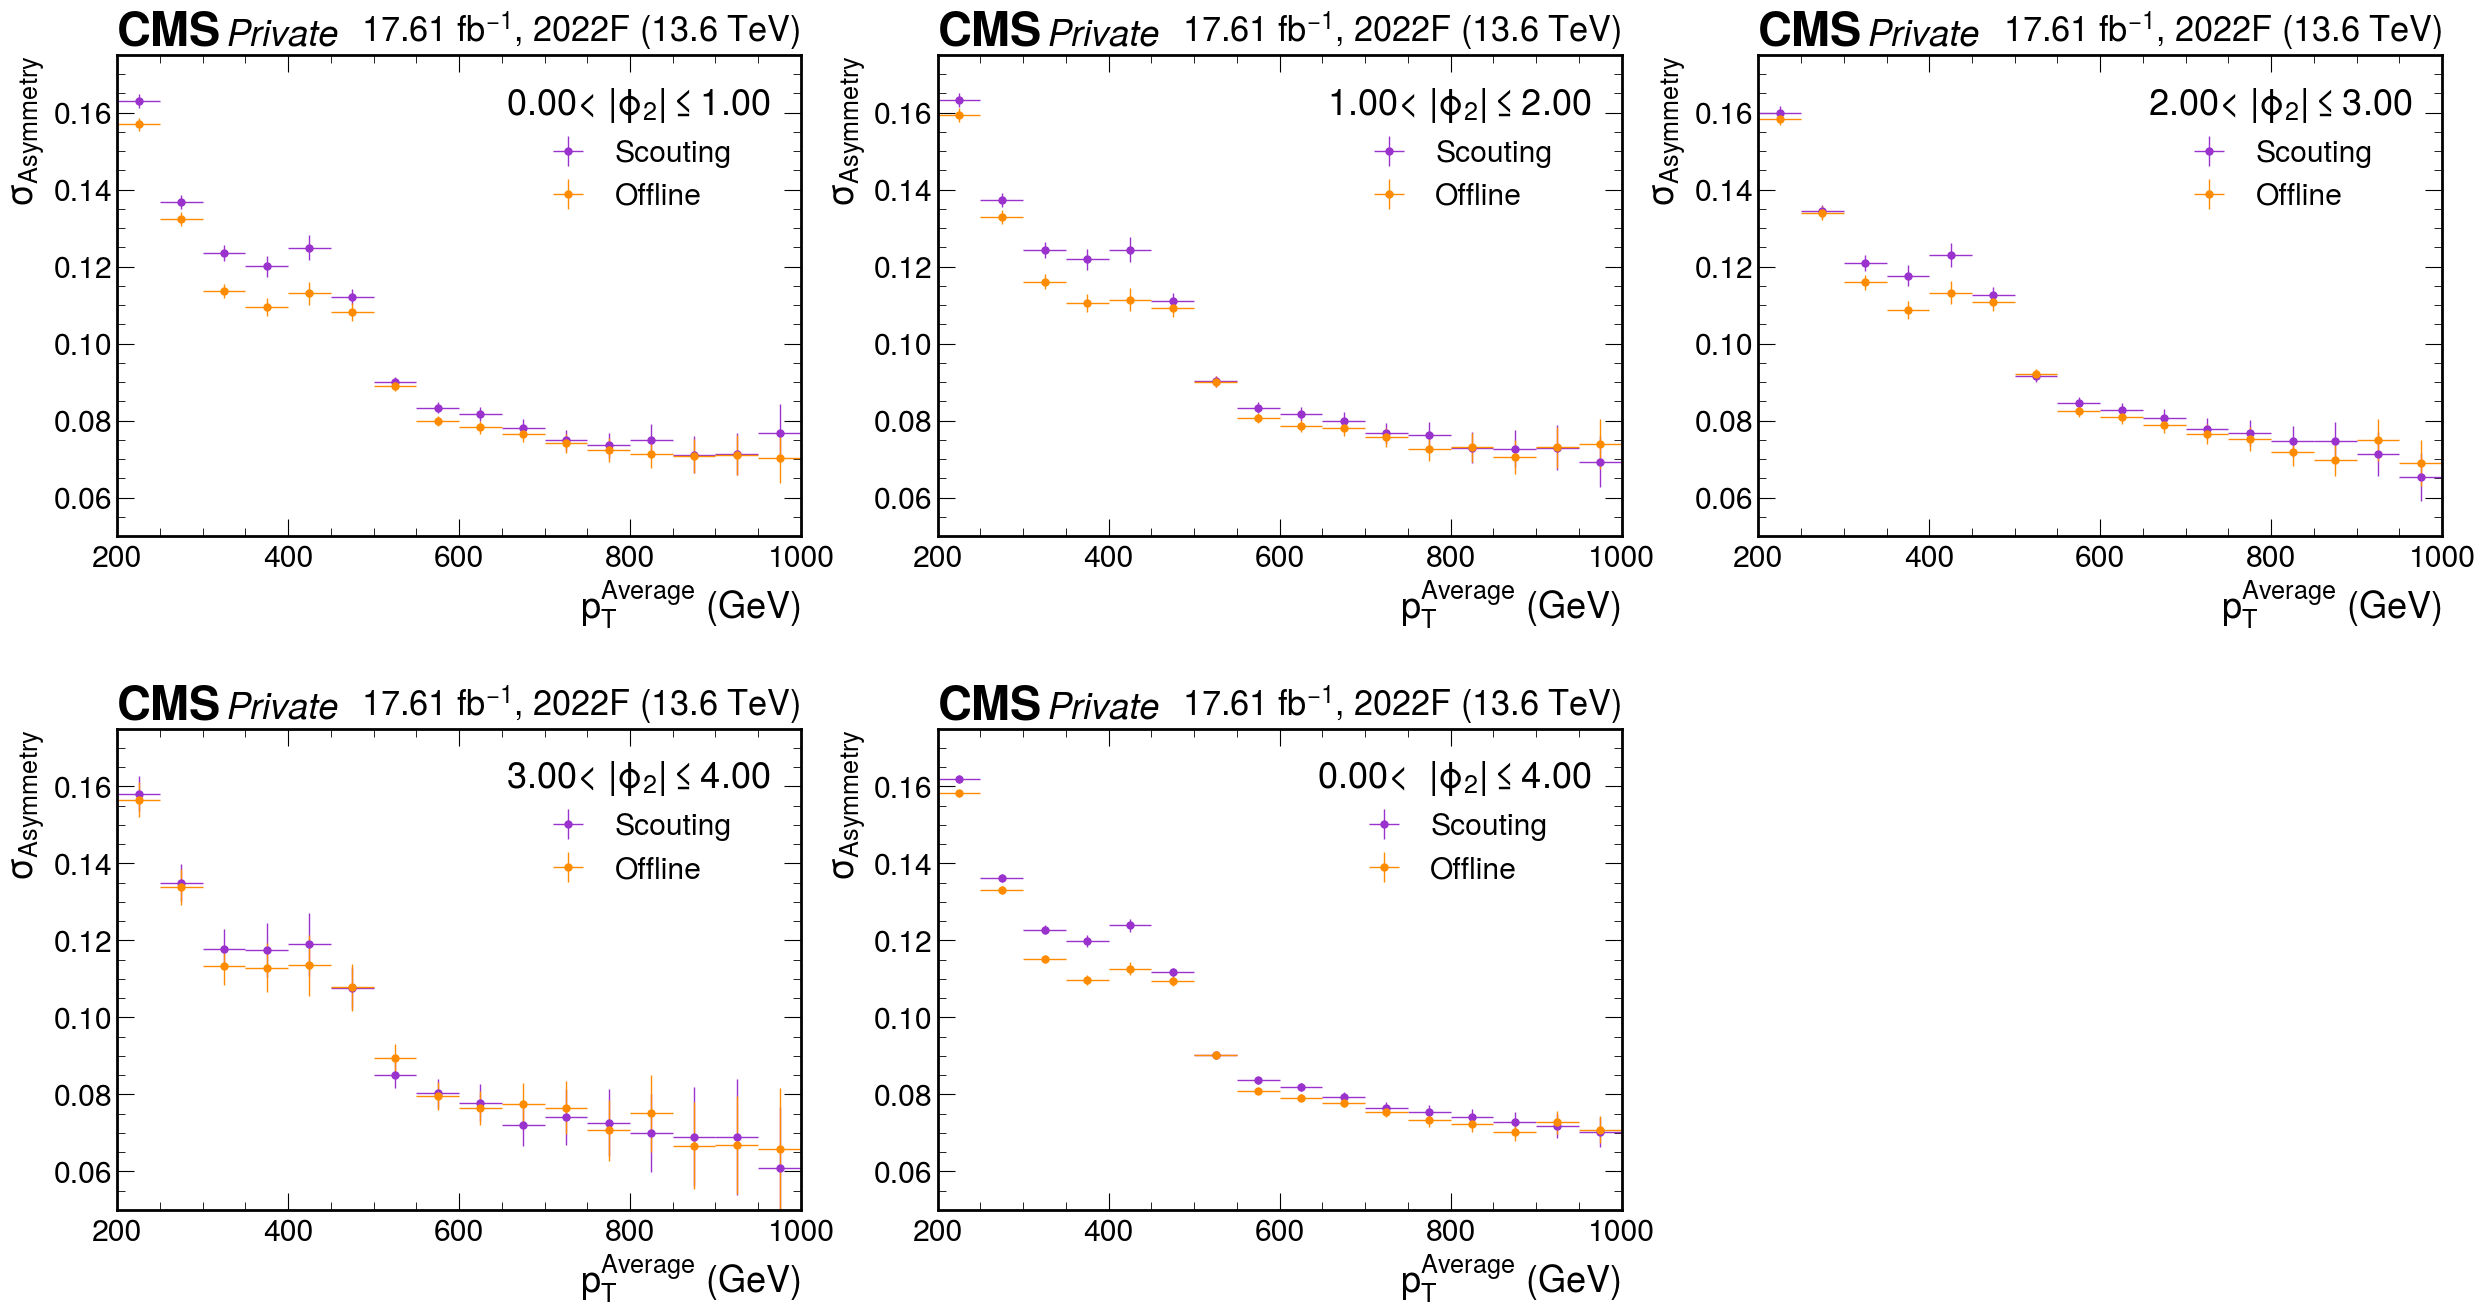

In [124]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

axes = output["scouting"].project("phi1").axes[0]

for era in ["F"]:
    
    for i, phi in enumerate(np.append(axes.centers, np.array(-1))):
    
        ax = axs[row, column]

        h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : i if phi >= 0 else sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                      }]
        
        h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : i if phi >= 0 else sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                     }]
        binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

        data_err_opts = {
                    'linestyle': 'none',
                    'marker': '.',
                    'markersize': 10.,
                    'elinewidth': 1,
                }
        
        if sum(h_s.counts()) == 0:
            continue

        ax.errorbar(
            h_s.axes[0].centers,
            err(h_s),
            xerr=binwidth/2,
            yerr=[err * 5 for err in err_err(h_s)],
            **data_err_opts,
            color="#9A32CD",
            label="Scouting"
        )

        ax.errorbar(
            h_o.axes[0].centers,
            err(h_o),
            xerr=binwidth/2,
            yerr=[err * 5 for err in err_err(h_o)],
            **data_err_opts,
            color="#FF8C00",
            label="Offline"
        )

        mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
        ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
        ax.set_ylabel(r"$\sigma_{Asymmetry}$")
        ax.axhline(0, color='gray',ls='--')
        title = f"{axes.edges[i]:.2f}" + r"< |$\phi_2| \leq$" + f"{axes.edges[i+1]:.2f}" if phi >= 0 else f"{axes.edges[0]:.2f}" + r"<  |$\phi_2| \leq$" + f"{axes.edges[-1]:.2f}"
        ax.legend(loc="best", title=title)
        ax.set_ylim(0.05, 0.175)
        ax.set_xlim(200, 1000)

        column += 1
        if column > 2:
            column = 0
            row += 1
            
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

HLT_PFHT1050  :  615298.0
L1_HTT200er  :  904.0
L1_HTT255er  :  2887.0
L1_HTT360er  :  1418666.0
L1_HTT400er  :  1394218.0
L1_HTT450er  :  1315710.0
L1_SingleJet180  :  1427219.0
had  :  1429917.0


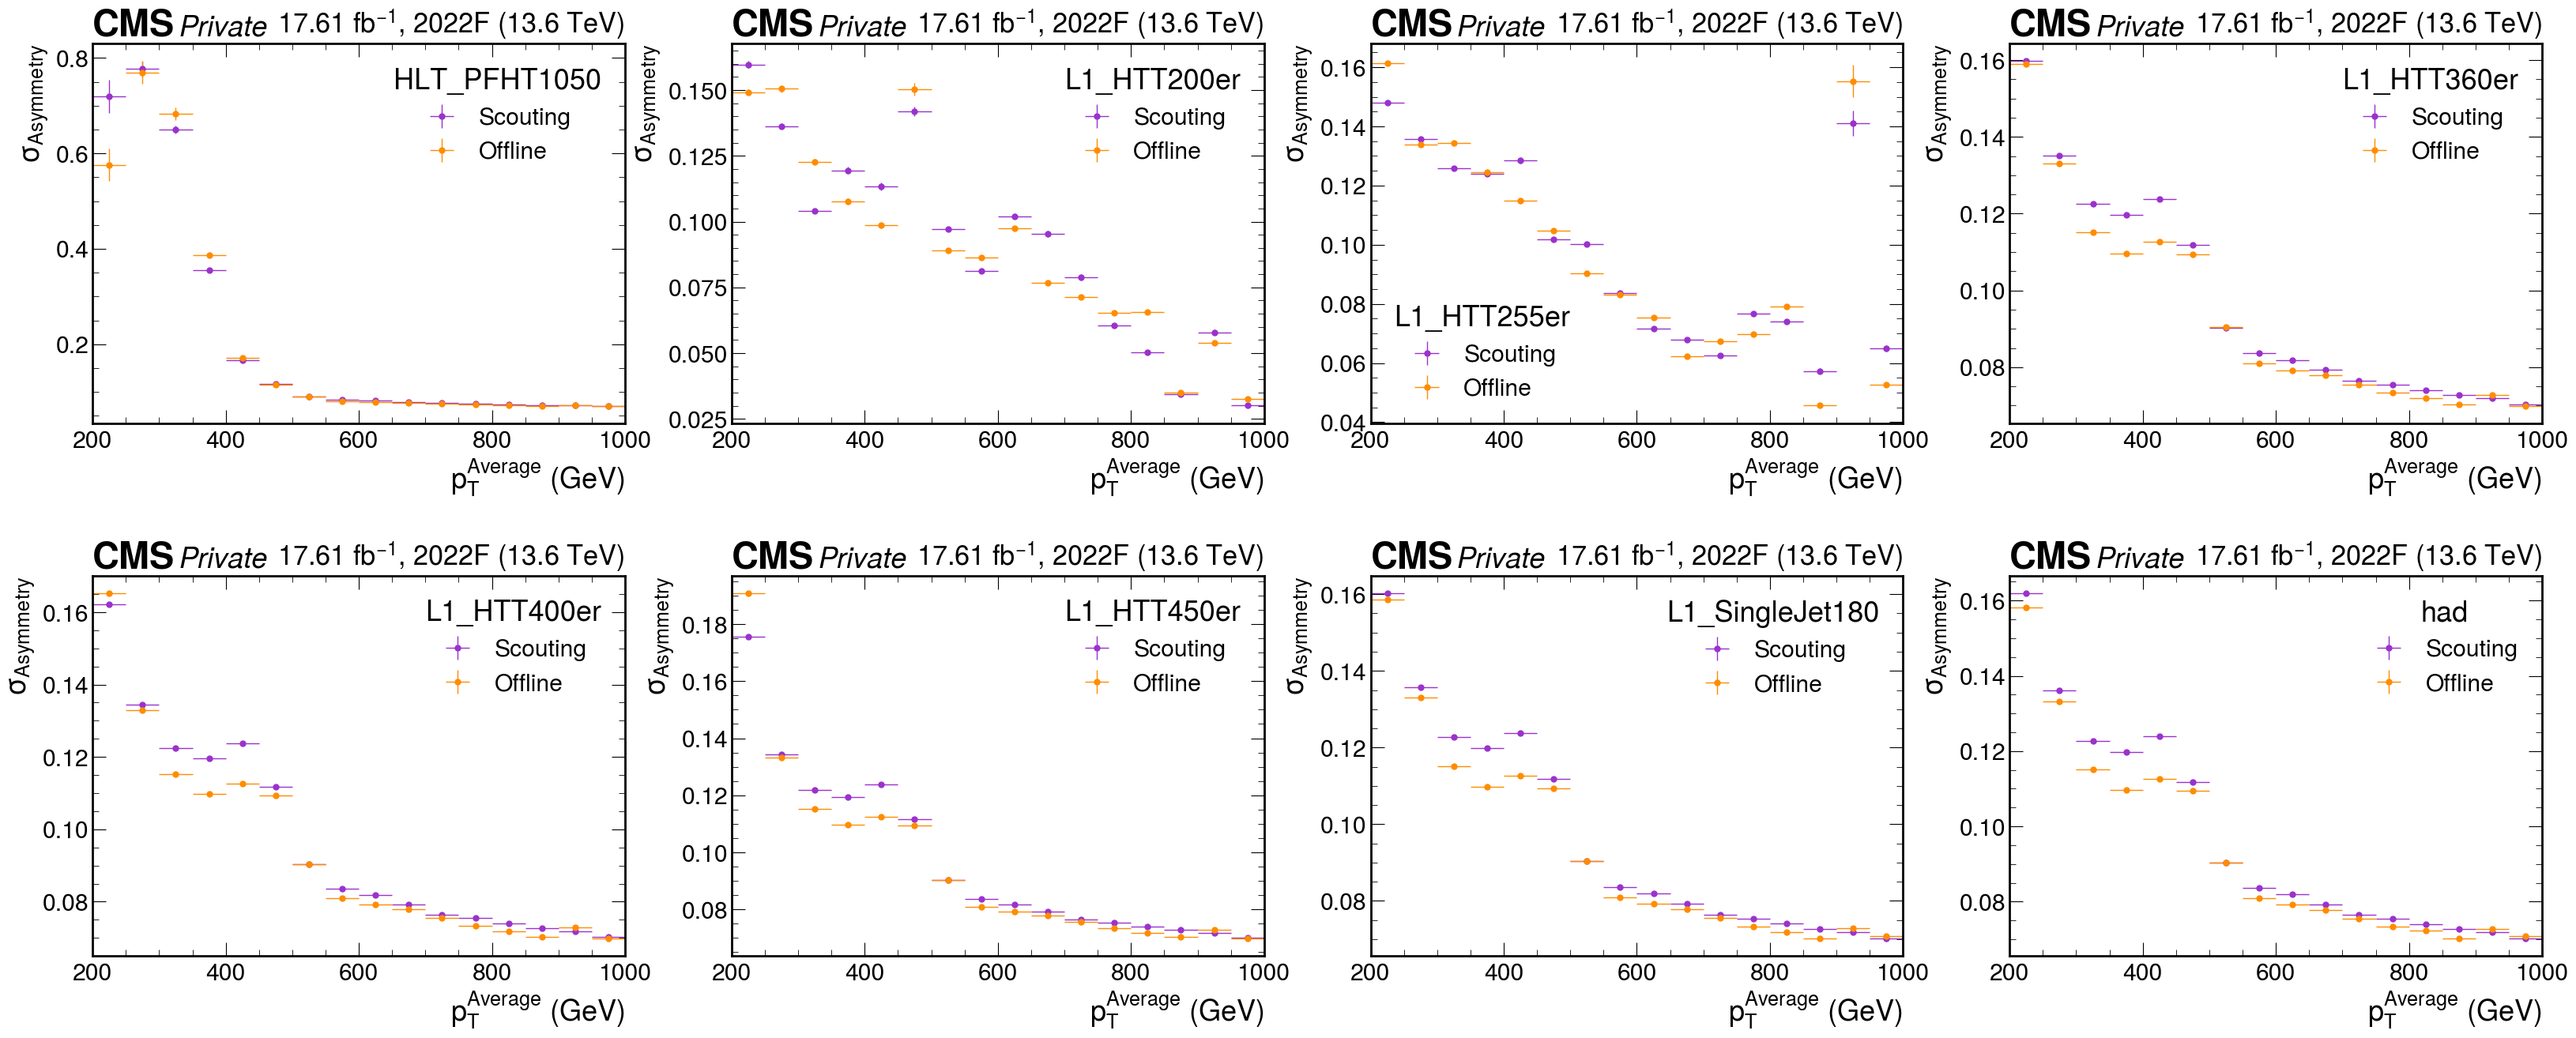

In [19]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist)**2 / np.sqrt(2 * meanhist.counts())

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        
    return err

fig, axs = plt.subplots(2, 4, figsize=(40,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

triggers = ["HLT_PFHT1050","L1_HTT200er","L1_HTT255er", "L1_HTT360er","L1_HTT400er", "L1_HTT450er", "L1_SingleJet180", "had"]
#triggers = ["HLT_Ele115_CaloIdVT_GsfTrkIdT", "HLT_Ele35_WPTight_Gsf", "HLT_IsoMu27",
#            "HLT_Mu50", "HLT_Photon200", "nonhad"]

for trigger in triggers:

    era = "F" if trigger != "nonhad" else ""
    output = util.load(f"outfiles/2022/jer_dijet_ScoutingPFMonitor_2022{era}-CHS_{trigger}.coffea")[0]
    print(trigger, " : ", output["scouting"].sum())
    
    era = "F"
    ax = axs[row, column]
    
    if trigger != "nonhad":

        h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                      }]

        h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                     }]
    else:
        
        h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]

        h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
        
    binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

    if sum(h_s.counts()) == 0:
        continue

    ax.errorbar(
        h_s.axes[0].centers,
        err(h_s),
        xerr=binwidth/2,
        yerr=[err * 1 for err in err_err(h_s)],
        **data_err_opts,
        color="#9A32CD",
        label="Scouting"
    )

    ax.errorbar(
        h_o.axes[0].centers,
        err(h_o),
        xerr=binwidth/2,
        yerr=[err * 1 for err in err_err(h_o)],
        **data_err_opts,
        color="#FF8C00",
        label="Offline"
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_{Asymmetry}$")
    #ax.axhline(0, color='gray',ls='--')
    title = trigger
    ax.legend(loc="best", title=f"{title}")
    #ax.set_ylim(0.05, 0.175)
    ax.set_xlim(200, 1000)

    column += 1
    if column > 3:
        column = 0
        row += 1
            
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

HLT_Ele115_CaloIdVT_GsfTrkIdT  :  197324.0
HLT_Ele35_WPTight_Gsf  :  10363.0
HLT_IsoMu27  :  2328.0
HLT_Mu50  :  35841.0
HLT_Photon200  :  459692.0
nonhad  :  1764872.0


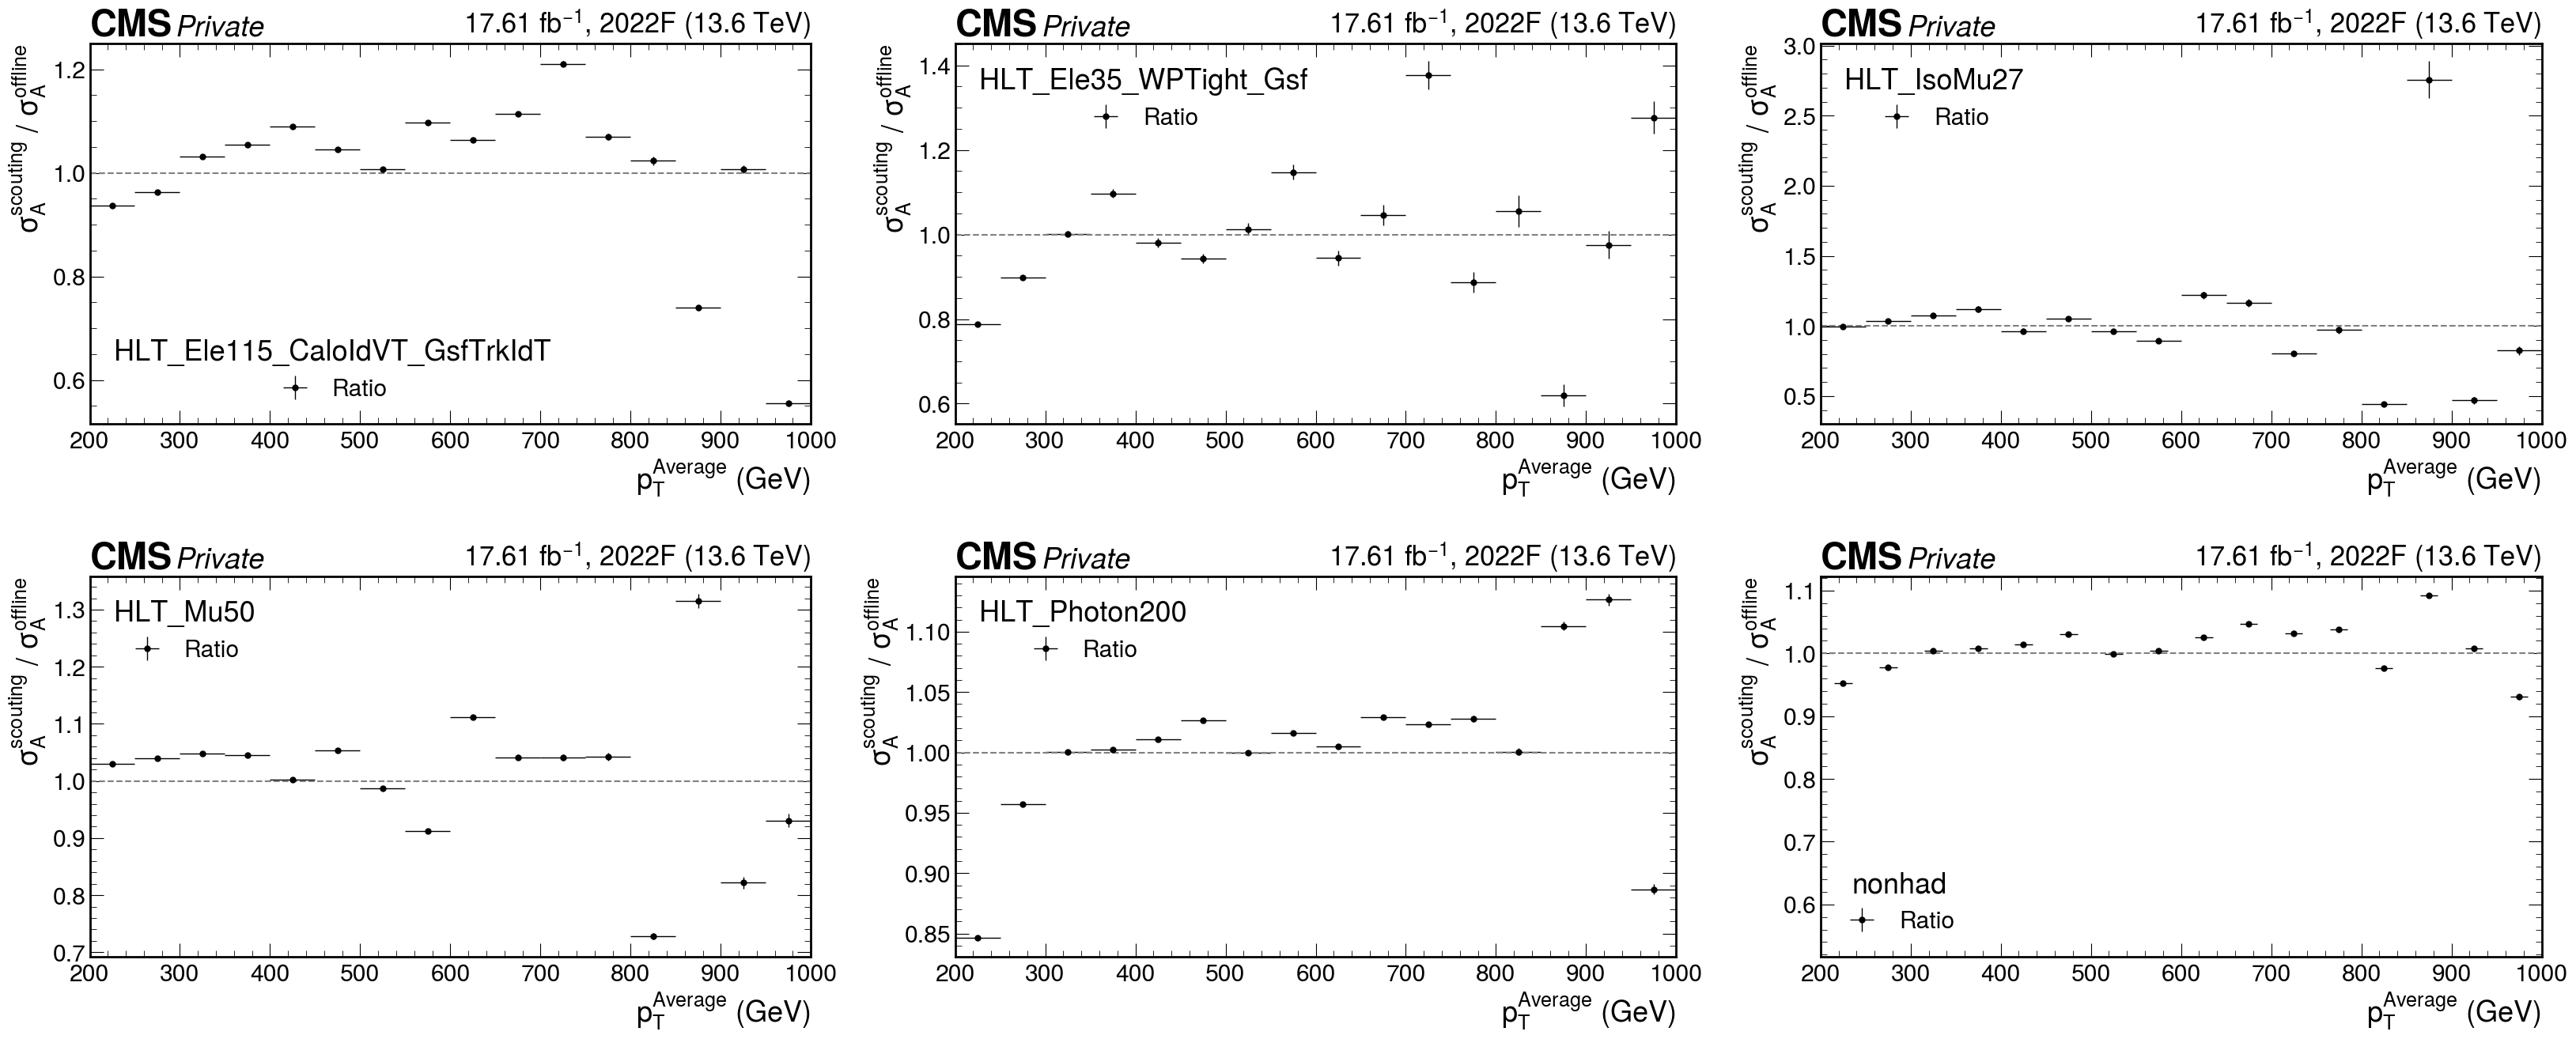

In [21]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist)**2 / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
    
    return err

fig, axs = plt.subplots(2, 3, figsize=(40,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

row = 0
column = 0

# triggers = ["HLT_PFHT1050","L1_HTT200er","L1_HTT255er", "L1_HTT360er","L1_HTT400er",
#             "L1_HTT450er", "L1_SingleJet180", "had"]
triggers = ["HLT_Ele115_CaloIdVT_GsfTrkIdT", "HLT_Ele35_WPTight_Gsf", "HLT_IsoMu27",
            "HLT_Mu50", "HLT_Photon200", "nonhad"]

for trigger in triggers:

    era = "F" if trigger != "nonhad" else ""
    output = util.load(f"outfiles/2022/jer_dijet_ScoutingPFMonitor_2022{era}-CHS_{trigger}.coffea")[0]
    print(trigger, " : ", output["scouting"].sum())
    
    era = "F"
    ax = axs[row, column]
    
    if trigger != "nonhad":

        h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                      }]

        h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                     }]
    else:
        
        h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]

        h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}]
        
    binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

    data_err_opts = {
                'linestyle': 'none',
                'marker': '.',
                'markersize': 10.,
                'elinewidth': 1,
            }

    if sum(h_s.counts()) == 0:
        continue

    ax.errorbar(
        h_s.axes[0].centers,
        err(h_s)/err(h_o),
        xerr=binwidth/2,
        yerr=[err * 1 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
        **data_err_opts,
        color="black",
        label="Ratio",
    )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_A^{scouting}$ / $\sigma_A^{offline}$")
    ax.axhline(1, color='gray',ls='--')
    title = trigger
    ax.legend(loc="best", title=f"{title}")
    #ax.set_ylim(0.05, 0.175)
    ax.set_xlim(200, 1000)

    column += 1
    if column > 2:
        column = 0
        row += 1
            
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

(300.0, 1000.0)

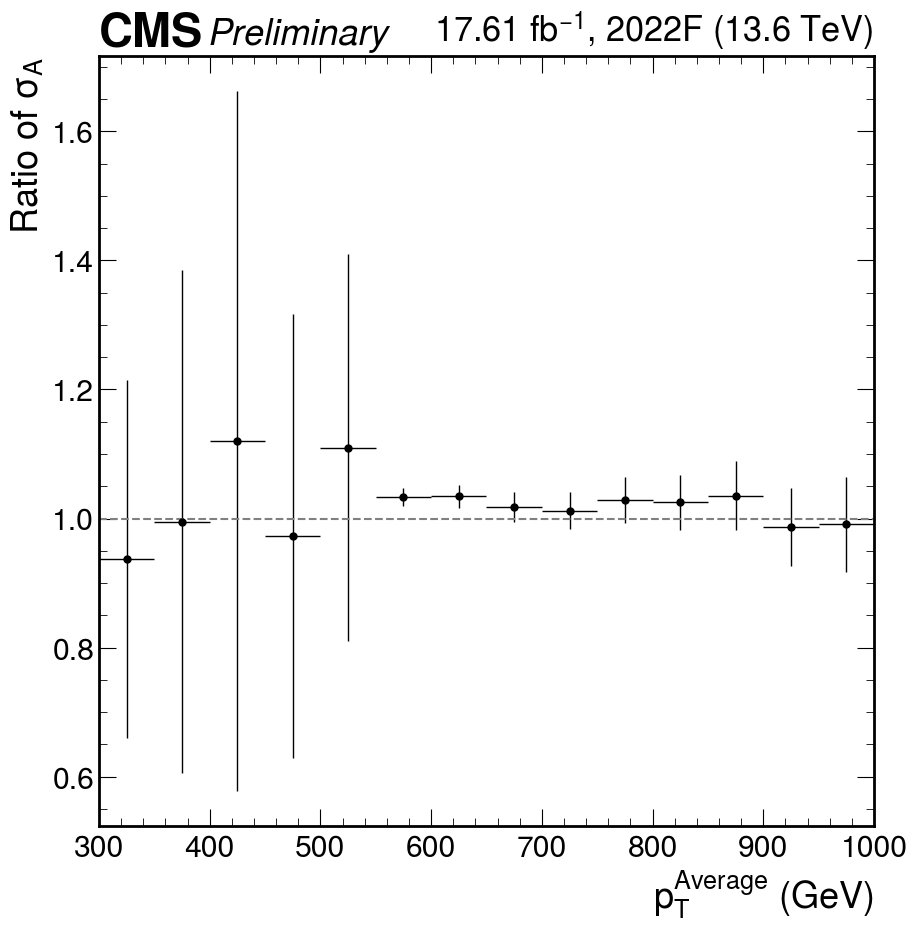

In [67]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
    
    return err

fig, ax = plt.subplots(figsize=(10,10))

era = "F"
trigger = "L1_HTT255er"

output = util.load(f"outfiles/2022/jer_dijet_ScoutingPFMonitor_2022{era}-CHS_{trigger}.coffea")[0]

h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                      }][:7]
h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                      }][:7]
binwidth = h_s.axes[0].centers[-1] - h_s.axes[0].centers[-2]

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

ax.errorbar(
    h_s.axes[0].centers,
    err(h_s)/err(h_o),
    xerr=binwidth/2,
    yerr=[err * 5 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
    **data_err_opts,
    color="black"
)

era = "F"
trigger = "had"

output = util.load(f"outfiles/2022/jer_dijet_ScoutingPFMonitor_2022{era}-CHS_{trigger}.coffea")[0]

h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                      }][7:]
h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era),
                                      "phi2" : sum,
                                      "phi1" : sum,
                                      "eta1" : sum,
                                      "eta2" : sum,
                                      }][7:]
data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

ax.errorbar(
    h_s.axes[0].centers,
    err(h_s)/err(h_o),
    xerr=binwidth/2,
    yerr=[err * 5 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
    **data_err_opts,
    color="black"
)

mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Preliminary", lumi=f"{lumi[era]:.2f}")
ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
ax.set_ylabel(r"Ratio of $\sigma_A$")
ax.axhline(1, color='gray',ls='--')
#ax.set_ylim(0.8, 1.2)
ax.set_xlim(300, 1000)

(300.0, 1000.0)

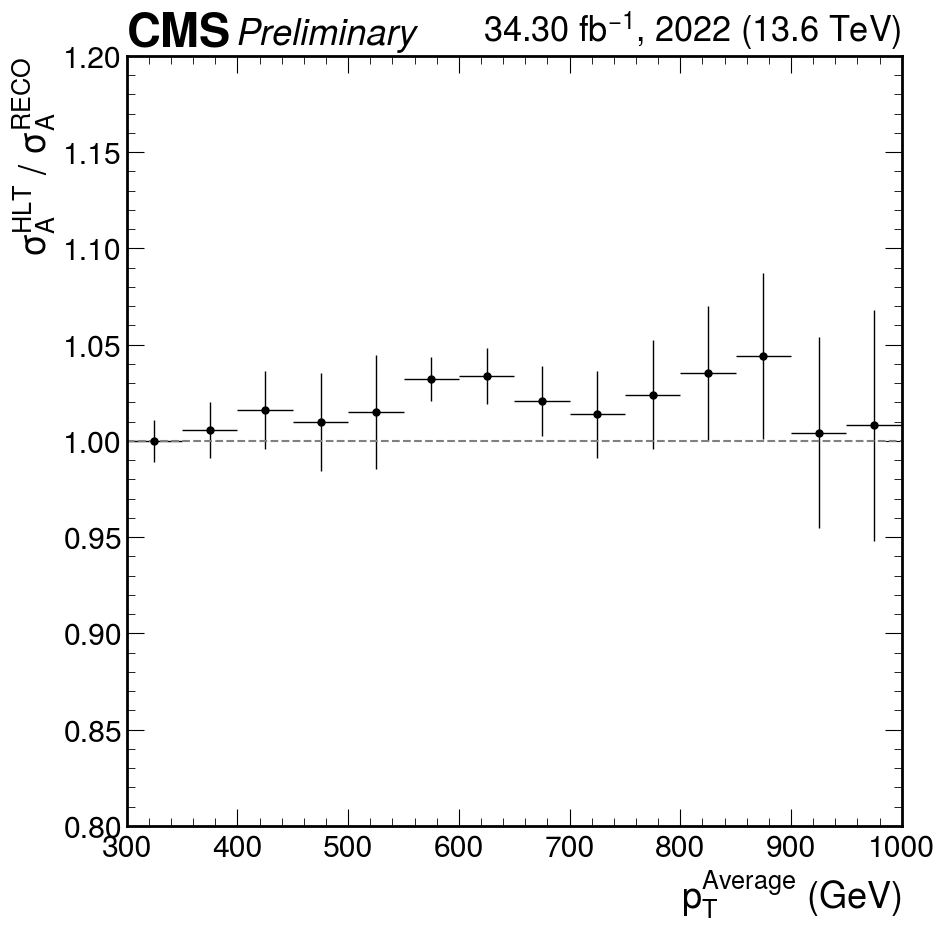

In [16]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist) / np.sqrt(2 * (meanhist.counts() - 1))

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
    
    return err

fig, ax = plt.subplots(figsize=(10,10))

era = ""
trigger = "nonhad"

output = util.load(f"outfiles/2022/jer_dijet_ScoutingPFMonitor_2022{era}-CHS_{trigger}.coffea")[0]

h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}][12:17]
h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}][12:17]
binwidth = h_s.axes[0].centers[-1] - h_s.axes[0].centers[-2]

data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

ax.errorbar(
    h_s.axes[0].centers,
    err(h_s)/err(h_o),
    xerr=binwidth/2,
    yerr=[err * 5 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
    **data_err_opts,
    color="black"
)

era = ""
trigger = "had"

output = util.load(f"outfiles/2022/jer_dijet_ScoutingPFMonitor_2022{era}-CHS_{trigger}.coffea")[0]

h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}][17:]
h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era)}][17:]
data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'elinewidth': 1,
        }

ax.errorbar(
    h_s.axes[0].centers,
    err(h_s)/err(h_o),
    xerr=binwidth/2,
    yerr=[err * 5 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
    **data_err_opts,
    color="black"
)

mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Preliminary", lumi=f"{lumi[era]:.2f}")
ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
ax.set_ylabel(r"$\sigma_A^{HLT}$ / $\sigma_A^{RECO}$")
ax.axhline(1, color='gray',ls='--')
ax.set_ylim(0.8, 1.2)
ax.set_xlim(300, 1000)

In [25]:
low = util.load("outfiles/2022/jer_dijet_ScoutingPFMonitor_2022-CHS_had_low_all_offlinePuppi.coffea")[0]
high = util.load("outfiles/2022/jer_dijet_ScoutingPFMonitor_2022-CHS_had_high_offlinePuppi.coffea")[0]

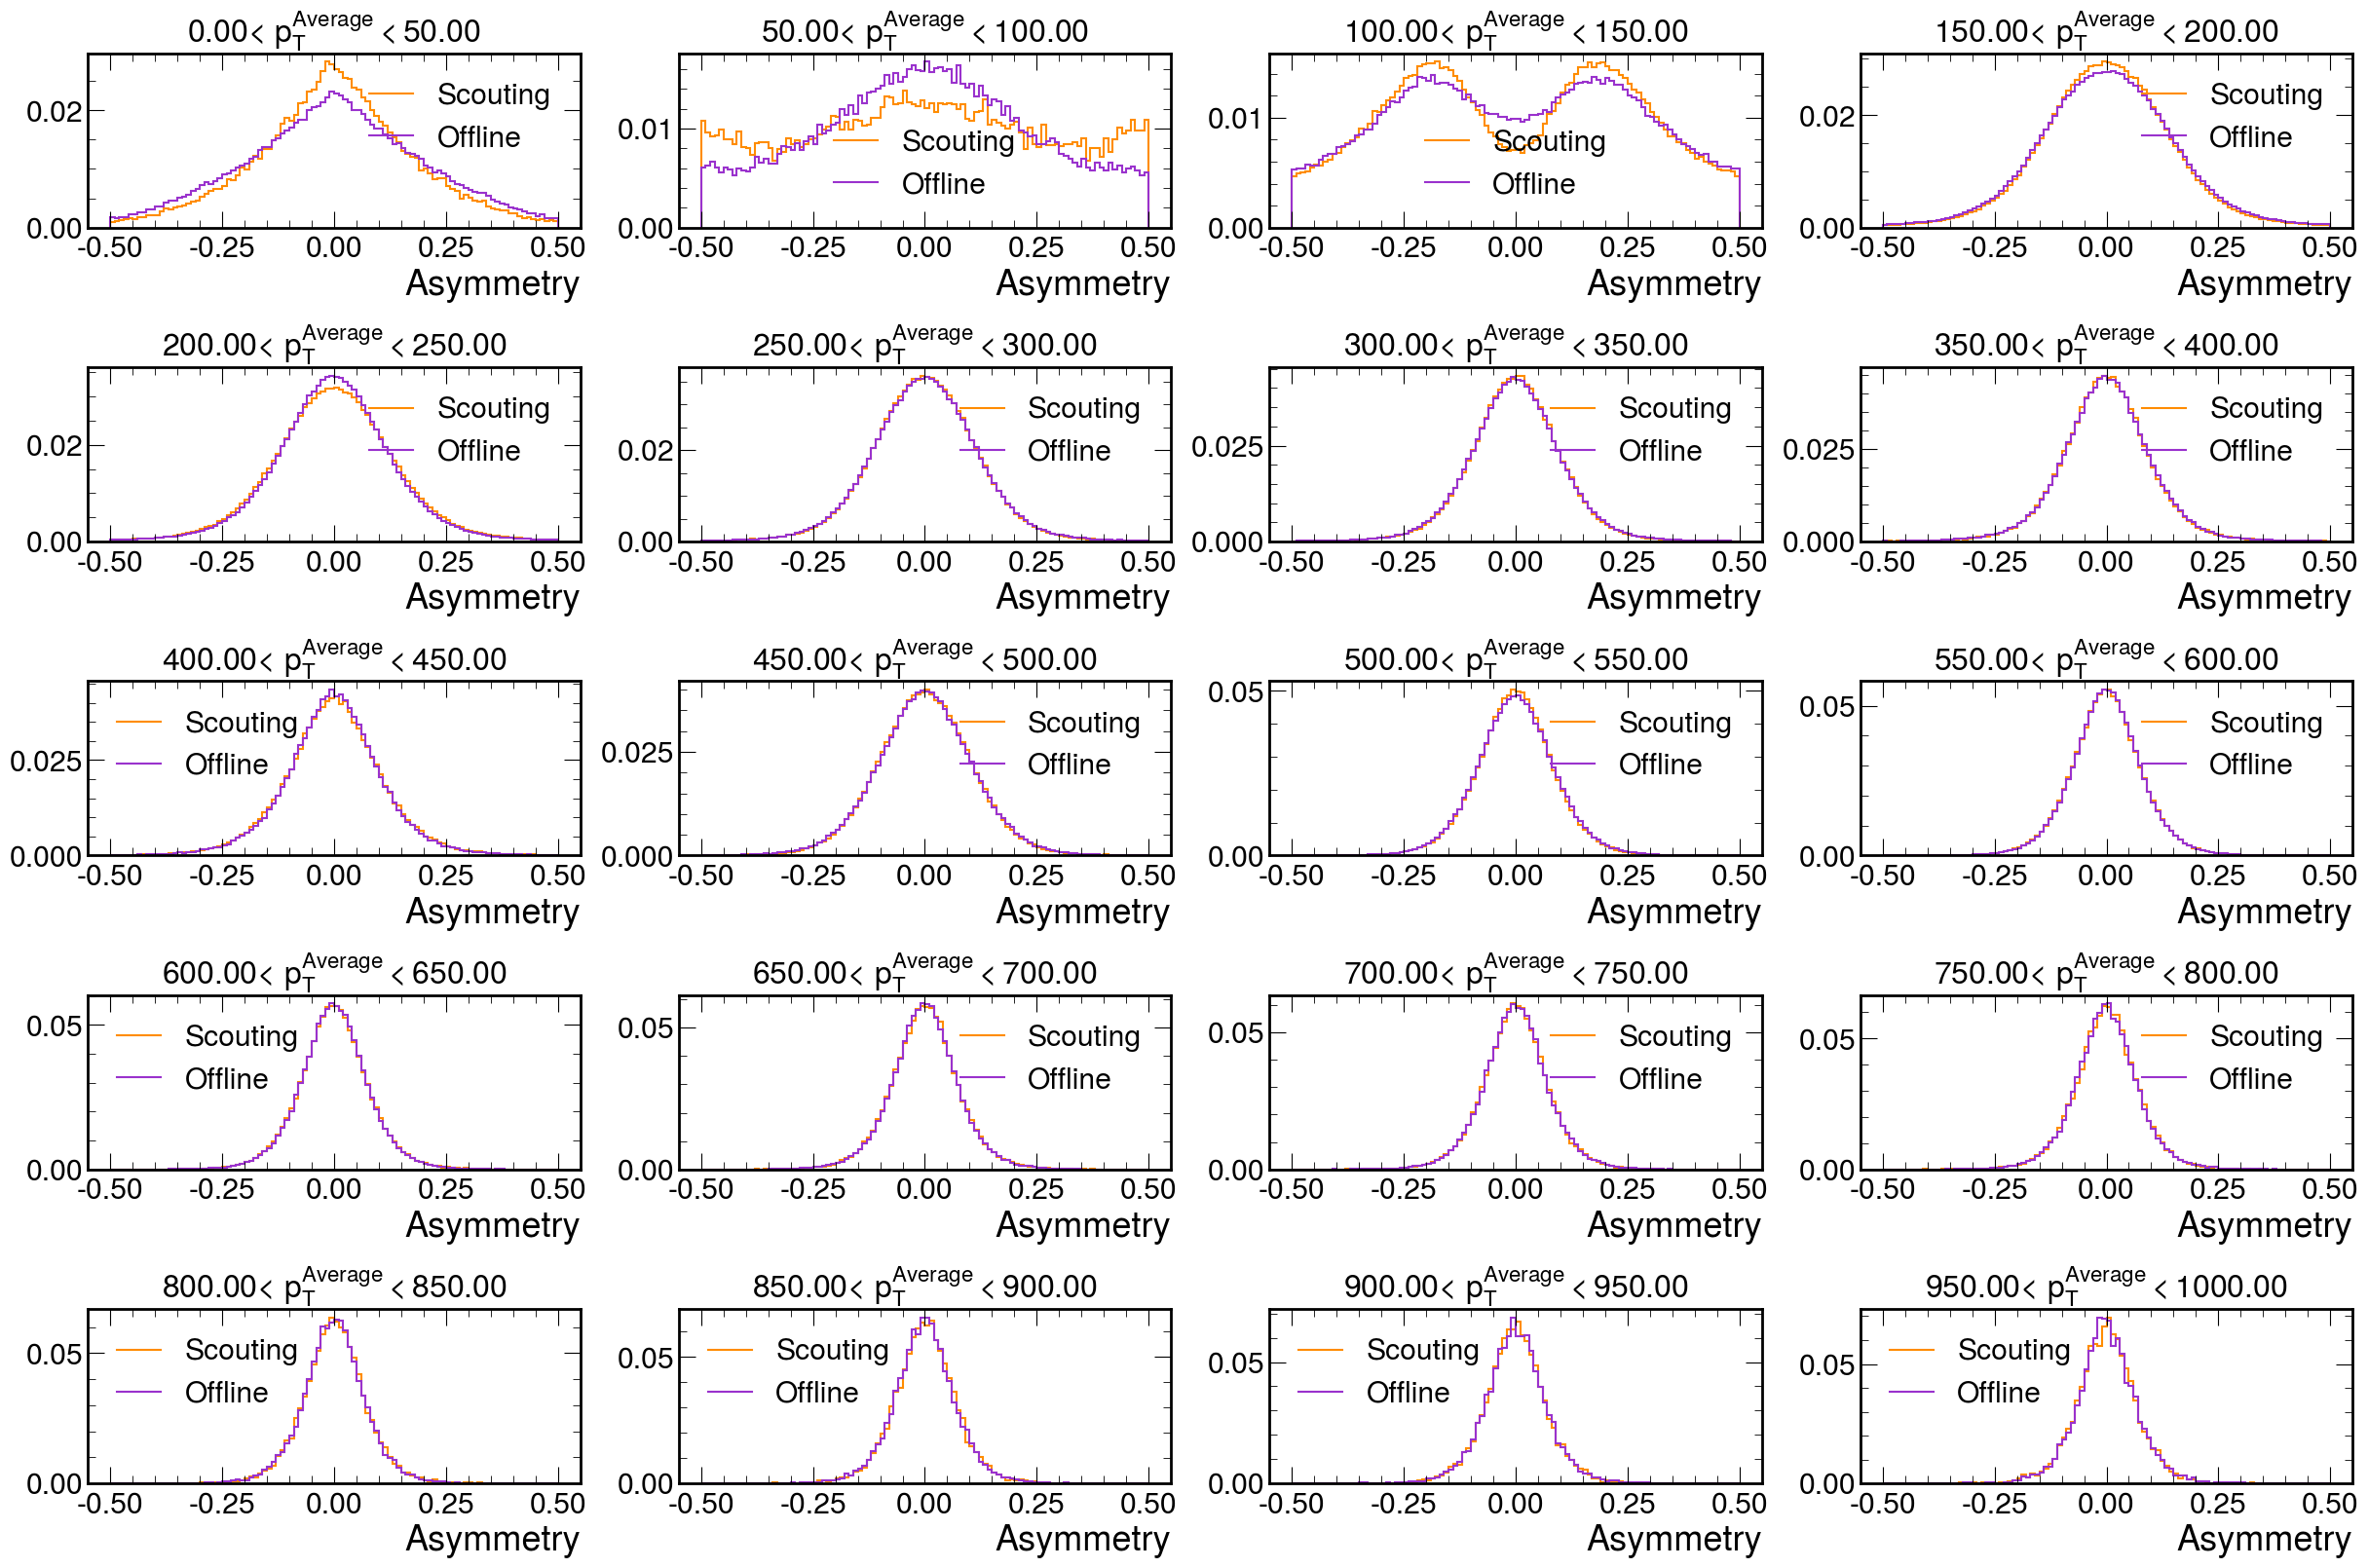

In [26]:
fig, axs = plt.subplots(10, 4, figsize=(30,40))
plt.subplots_adjust(wspace=0.2, hspace=0.8)

label = {
    0 : r"0 $\leq |\eta | <$ 1.3",
    1 : r"1.3 $\leq |\eta | \leq$ 2.5",
    sum : r"0 $\leq |\eta | \leq$ 2.5",
}

colour_eta = {
    0 : "#FF8C00",
    1 : "#9A32CD",
    sum : "black",
}

colour_rec = {
    "scouting" : "#FF8C00",
    "offline" : "#9A32CD",
}


row = 0
column = 0

era = ""

for pt, output in [("low", low), ("high", high)]:
    
    centers = output["scouting"].project("pt_ave").axes[0].centers
    edges = output["scouting"].project("pt_ave").axes[0].edges

    for i, _ in enumerate(centers):
        
        if centers[i] > 1000: break

        ax = axs[row, column]

        for eta1, eta2 in [(sum, sum)]:
            
            for rec in ["scouting", "offline"]:

                h = output[rec][{"dataset" : sum if not era else hist.loc("2022" + era), 
                                  "eta1" : eta1,
                                  "eta2" : eta2,
                                  "pt_ave" : i}]
                h *= 1 / h.sum() if h.sum() != 0 else 1

                if i == (len(centers) - 1) and pt == "high" and False:
                    mplhep.histplot(h, color=colour_rec[rec], ax=ax, label=f"{rec.capitalize()} ({label[eta1]})")
                    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
                else:
                    mplhep.histplot(h, color=colour_rec[rec], ax=ax, label=f"{rec.capitalize()}")

            ax.set_title(f"{edges[i]:.2f}" + r"< $p_T^{Average} <$" + f"{edges[i+1]:.2f}", fontsize=23)
            ax.legend(loc="best")

        column += 1
        if column > 3:
            column = 0
            row += 1
        
for ax in axs.flat:
    if not bool(ax.has_data()):
        fig.delaxes(ax)

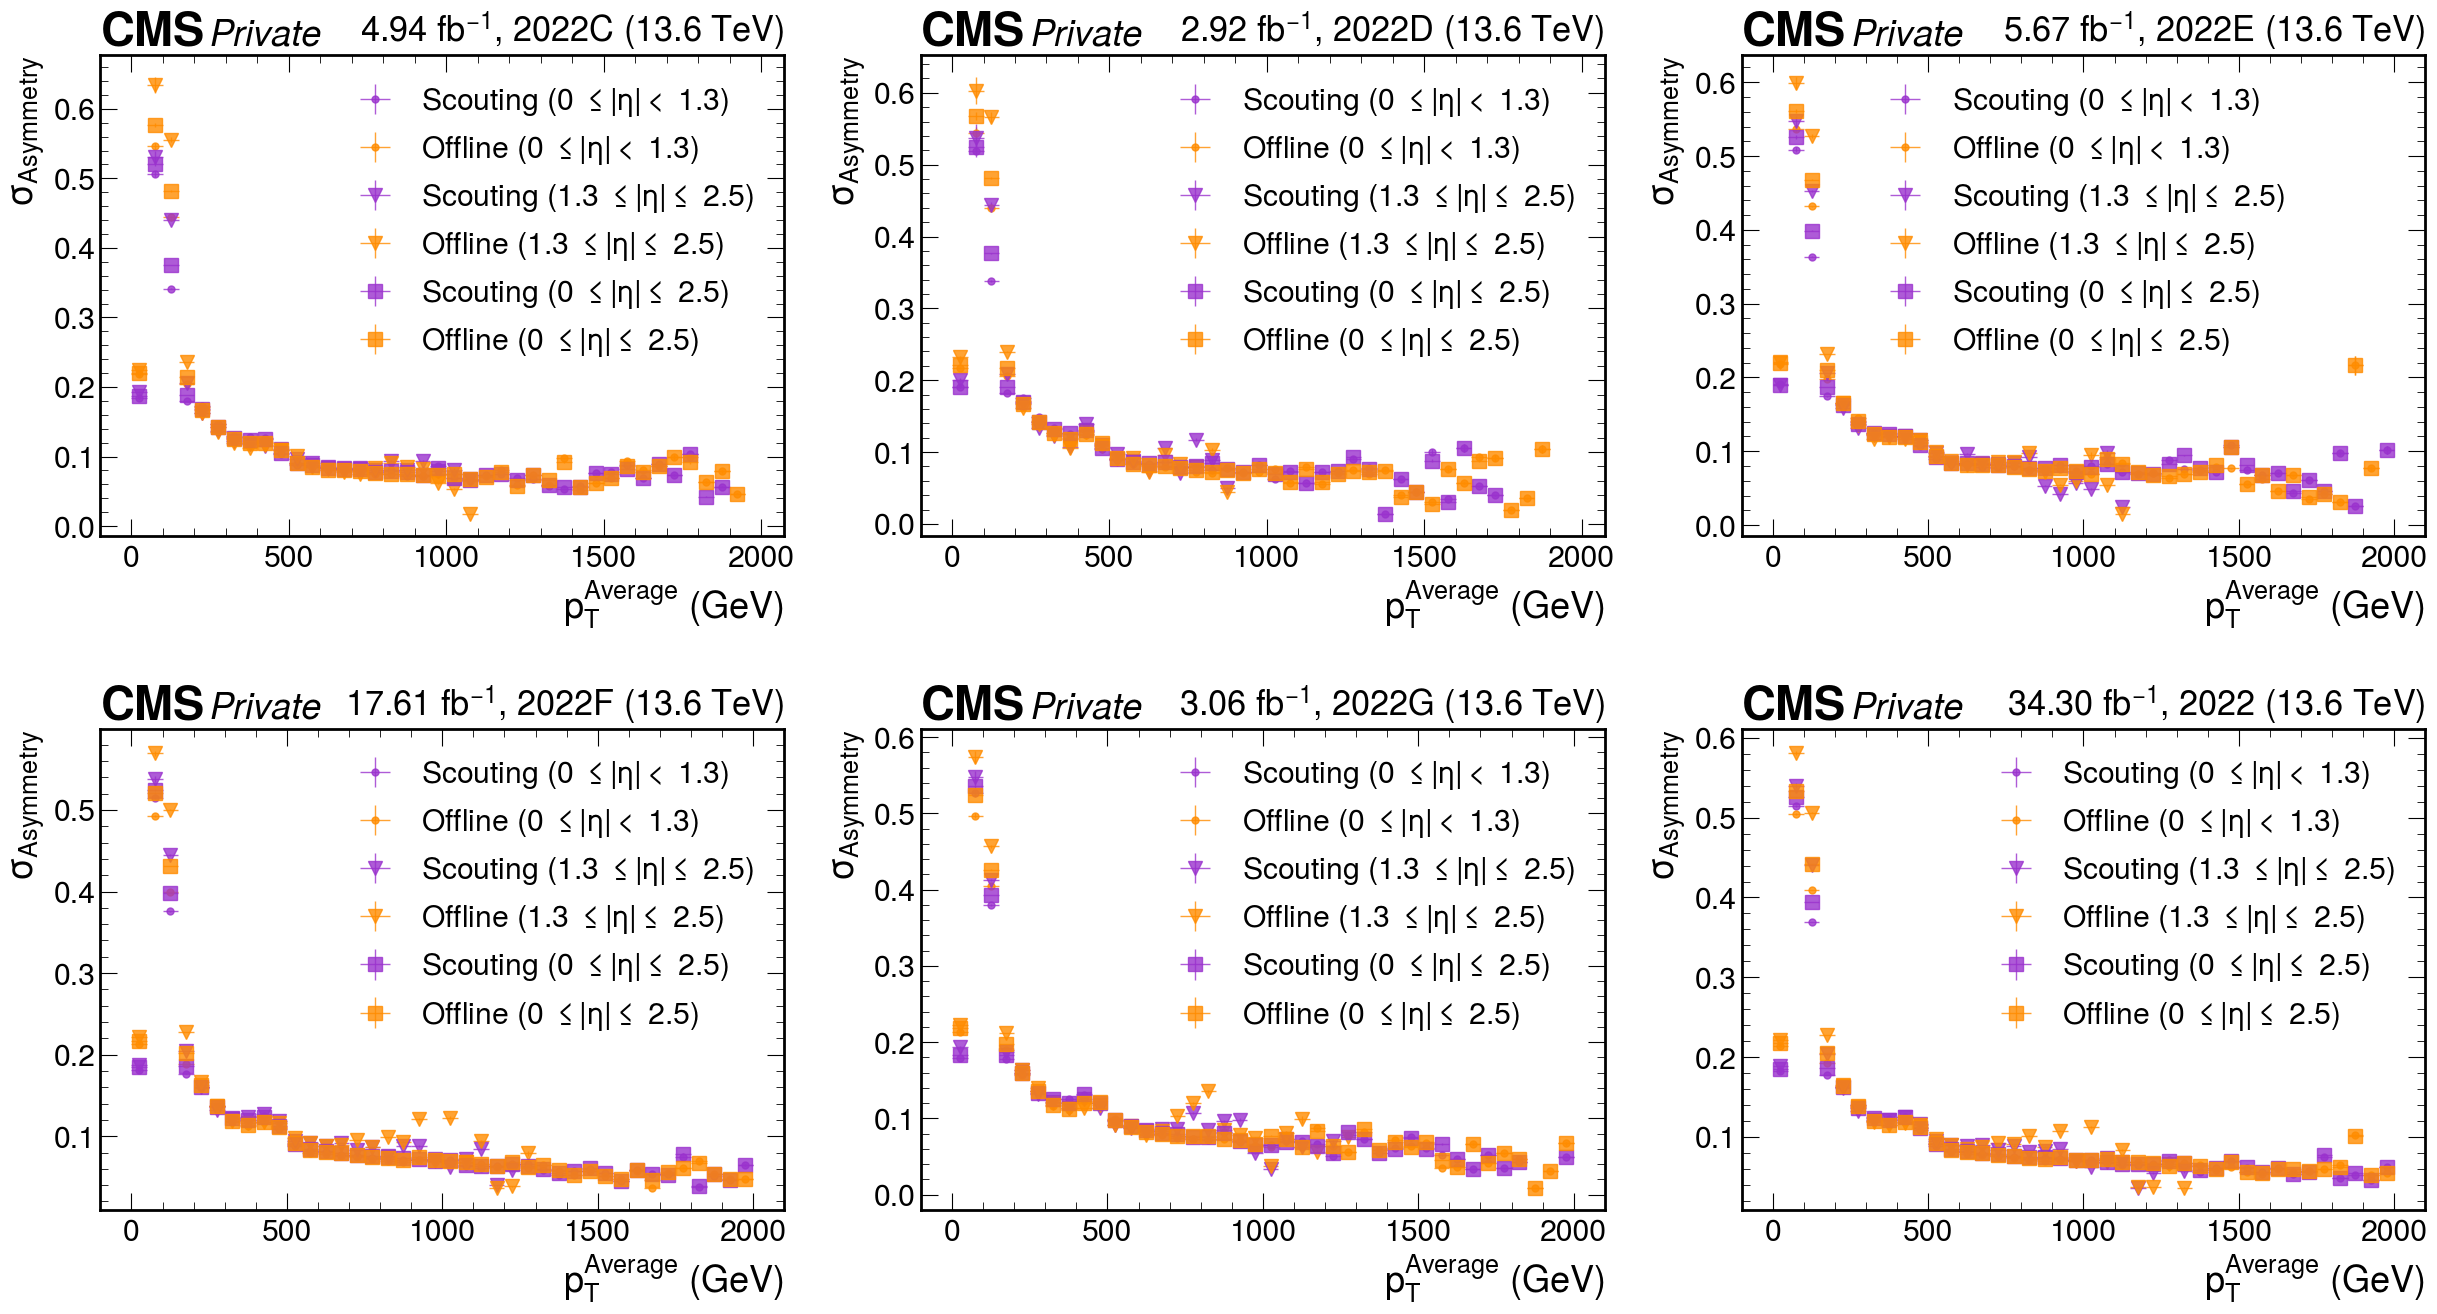

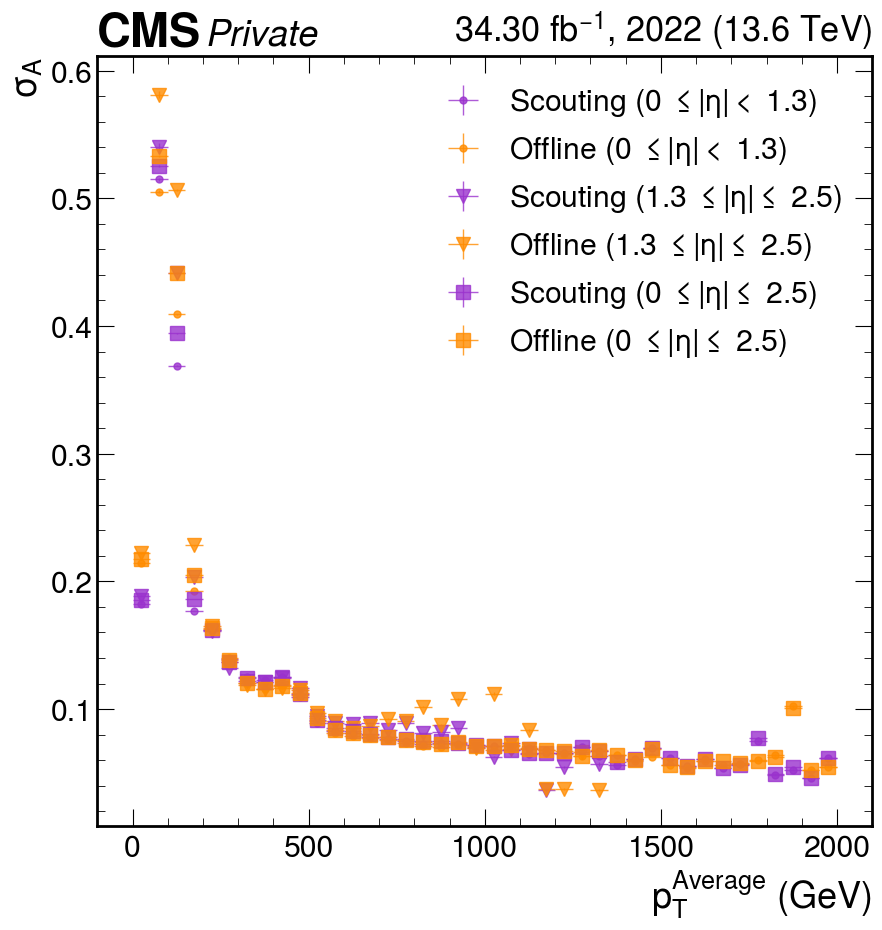

In [29]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

label = {
    0 : r"0 $\leq |\eta | <$ 1.3",
    1 : r"1.3 $\leq |\eta | \leq$ 2.5",
    sum : r"0 $\leq |\eta | \leq$ 2.5",
}

colour = {
    0 : "#FF8C00",
    1 : "#9A32CD",
    sum : "black",
}

marker = {
    0 : ".",
    1 : "v",
    sum : "s",
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist)**2 / np.sqrt(2 * meanhist.counts())

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
        

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

fig1, ax1 = plt.subplots(figsize=(10, 10))

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]
    
    for pt, output in [("low", low), ("high", high)]:
        
        for eta1, eta2 in [(0, 0), (1, 1), (sum, sum)]:

            h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era), 
                                           "eta1" : eta1,
                                           "eta2" : eta2}]
            h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era), 
                                           "eta1" : eta1,
                                           "eta2" : eta2}]
            binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

            data_err_opts = {
                        'linestyle': 'none',
                        'marker': '.',
                        'markersize': 10.,
                        'elinewidth': 1,
                        'marker' : marker[eta1],
                        'alpha' : 0.8,
                    }

            ax.errorbar(
                h_s.axes[0].centers,
                err(h_s),
                xerr=binwidth/2,
                yerr=[err * 1 for err in err_err(h_s)],
                **data_err_opts,
                color="#9A32CD",
                label=f"Scouting ({label[eta1]})" if pt == "low" else ""
            )

            ax.errorbar(
                h_o.axes[0].centers,
                err(h_o),
                xerr=binwidth/2,
                yerr=[err * 1 for err in err_err(h_o)],
                **data_err_opts,
                color="#FF8C00",
                label=f"Offline ({label[eta1]})" if pt == "low" else ""
            )
            
            if not era:
                
                ax1.errorbar(
                    h_s.axes[0].centers,
                    err(h_s),
                    xerr=binwidth/2,
                    yerr=[err * 1 for err in err_err(h_s)],
                    **data_err_opts,
                    color="#9A32CD",
                    label=f"Scouting ({label[eta1]})" if pt == "low" else ""
                )

                ax1.errorbar(
                    h_o.axes[0].centers,
                    err(h_o),
                    xerr=binwidth/2,
                    yerr=[err * 1 for err in err_err(h_o)],
                    **data_err_opts,
                    color="#FF8C00",
                    label=f"Offline ({label[eta1]})" if pt == "low" else ""
                )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_{Asymmetry}$")
    ax.legend(loc="best")
    #ax.set_ylim(0.05, 0.175)

    column += 1
    if column > 2:
        column = 0
        row += 1
            
mplhep.cms.label(ax=ax1, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
ax1.set_xlabel(r"$p_T^{Average}$ (GeV)")
ax1.set_ylabel(r"$\sigma_{A}$")
ax1.legend(loc="best")
#ax1.set_xlim(300, 1000)

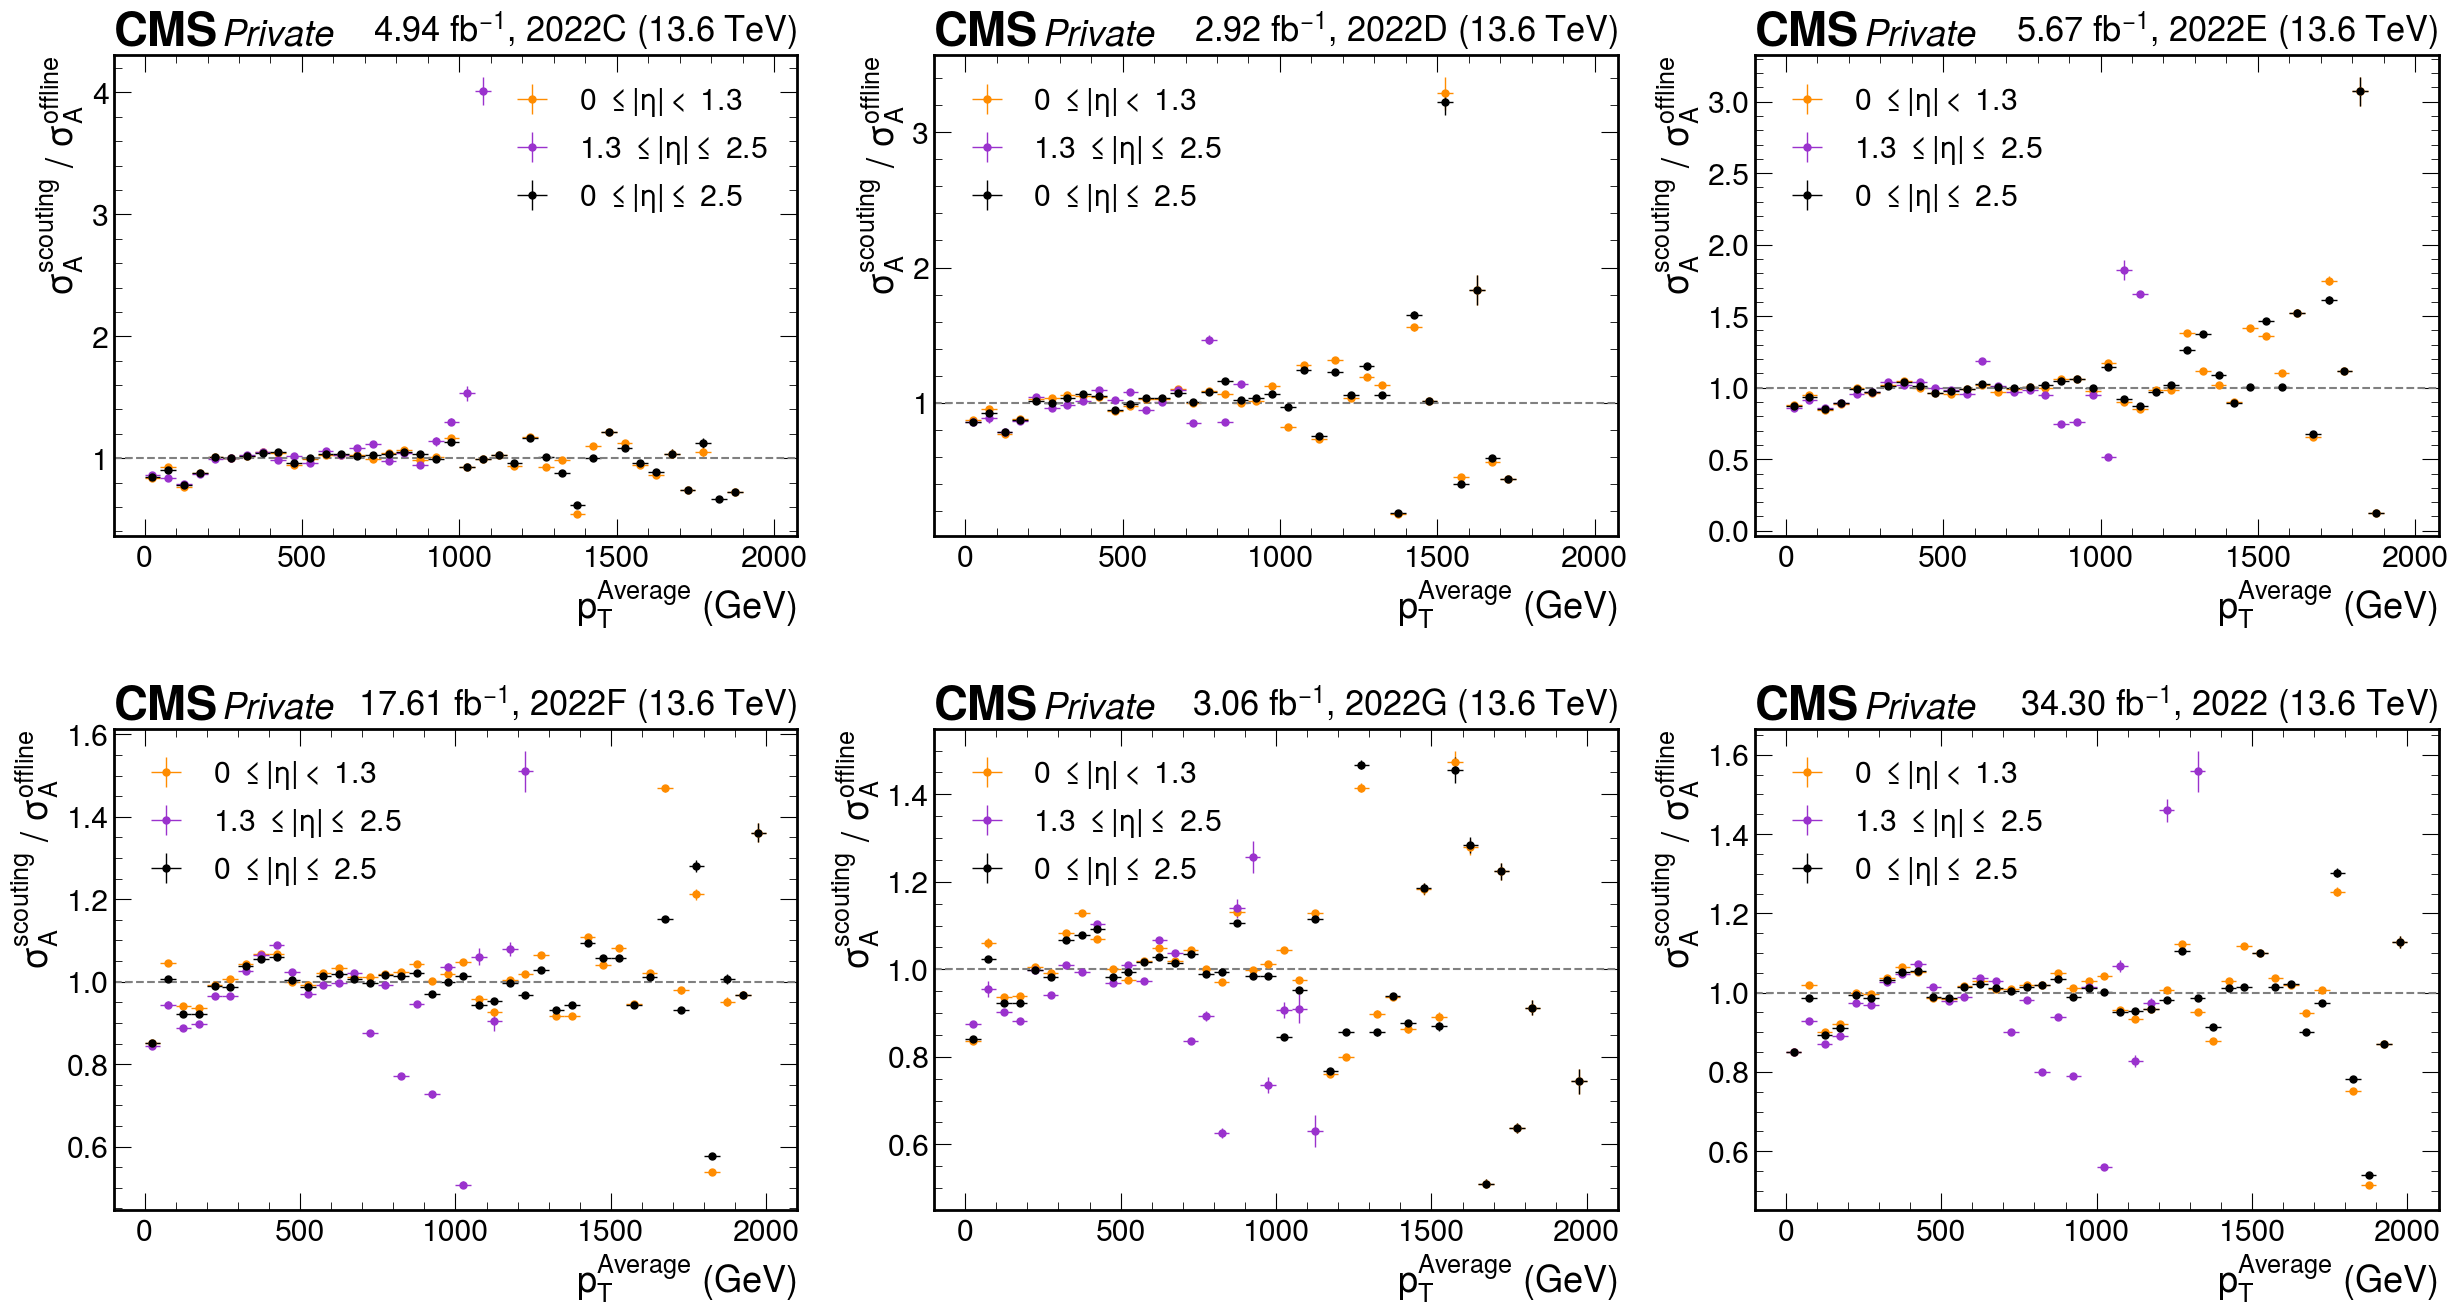

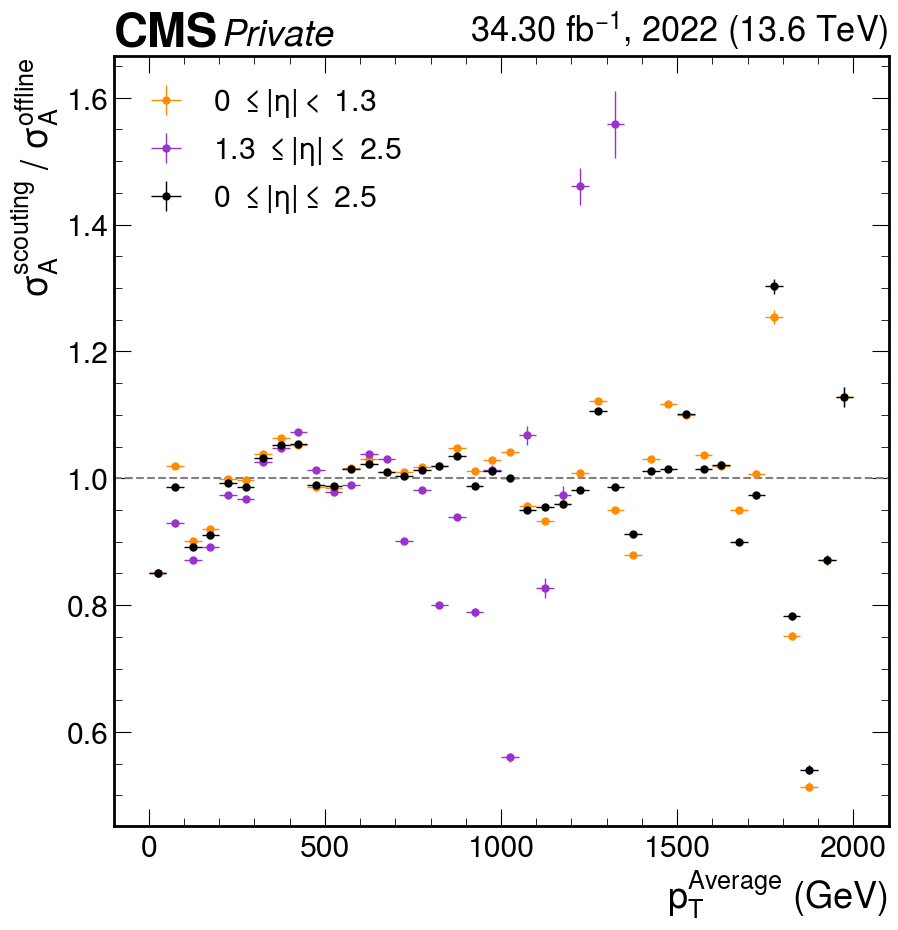

In [30]:
lumi = {
    "C" : 4.943,
    "D" : 2.922 ,
    "E" : 5.672,
    "F" : 17.610,
    "G" : 3.055,
    "" : 34.2984,
}

label = {
    0 : r"0 $\leq |\eta | <$ 1.3",
    1 : r"1.3 $\leq |\eta | \leq$ 2.5",
    sum : r"0 $\leq |\eta | \leq$ 2.5",
}

colour = {
    0 : "#FF8C00",
    1 : "#9A32CD",
    sum : "black",
}

def err(meanhist):
    return np.sqrt(meanhist.variances()*meanhist.counts())

def err_err(meanhist):
    return err(meanhist)**2 / np.sqrt(2 * meanhist.counts())

def err_prop(val_1, val_2, err_1, err_2):
    
    err = []
    
    for i in range(len(val_1)):
        tmp = (val_1[i] / val_2[i]) * np.sqrt((err_1[i] / val_1[i])**2 + (err_2[i] / val_2[i])**2)
        err.append(tmp)
    
    return err

fig, axs = plt.subplots(2, 3, figsize=(30,15))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

fig1, ax1 = plt.subplots(figsize=(10, 10))

row = 0
column = 0

for era in ["C", "D", "E", "F", "G", ""]:
    
    ax = axs[row, column]
    
    for pt, output in [("low", low), ("high", high)]:
        
        for eta1, eta2 in [(0, 0), (1, 1), (sum, sum)]:

            h_s = output["scouting_mean"][{"dataset" : sum if not era else hist.loc("2022" + era), 
                                           "eta1" : eta1,
                                           "eta2" : eta2}]
            h_o = output["offline_mean"][{"dataset" : sum if not era else hist.loc("2022" + era), 
                                           "eta1" : eta1,
                                           "eta2" : eta2}]
            binwidth = h_s.axes[0].centers[2] - h_s.axes[0].centers[1]

            data_err_opts = {
                        'linestyle': 'none',
                        'marker': '.',
                        'markersize': 10.,
                        'color': colour[eta1],
                        'elinewidth': 1,
                    }

            ax.errorbar(
                h_s.axes[0].centers,
                err(h_s)/err(h_o),
                xerr=binwidth/2,
                yerr=[err * 1 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
                **data_err_opts,
                label=label[eta1] if pt == "low" else "",
            )
            
            if not era:
                
                ax1.errorbar(
                    h_s.axes[0].centers,
                    err(h_s)/err(h_o),
                    xerr=binwidth/2,
                    yerr=[err * 1 for err in err_prop(err(h_s), err(h_o), err_err(h_s), err_err(h_o))],
                    **data_err_opts,
                    label=label[eta1] if pt == "low" else "",
                )

    mplhep.cms.label(ax=ax, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
    ax.set_xlabel(r"$p_T^{Average}$ (GeV)")
    ax.set_ylabel(r"$\sigma_{A}^{scouting}$ / $\sigma_{A}^{offline}$")
    ax.legend(loc="best")
    ax.axhline(1, color='gray',ls='--')
    #ax.set_ylim(0.05, 0.175)

    column += 1
    if column > 2:
        column = 0
        row += 1
            
mplhep.cms.label(ax=ax1, data=True, year="2022" + era, com=13.6, label="Private", lumi=f"{lumi[era]:.2f}")
ax1.set_xlabel(r"$p_T^{Average}$ (GeV)")
ax1.set_ylabel(r"$\sigma_{A}^{scouting}$ / $\sigma_{A}^{offline}$")
ax1.legend(loc="best")
ax1.axhline(1, color='gray',ls='--')
#ax1.set_ylim(0.05, 0.175)
#ax1.set_xlim(300, 1000)